<a href="https://colab.research.google.com/github/MayaHayat/FinalProject-DDSM/blob/main/DDSM_compare_models_implementation__Last_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import os
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score, precision_score,
    f1_score, cohen_kappa_score, matthews_corrcoef
)
import copy

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define your custom colors
colors = ['#D0E0CD', '#e4cfc3', '#D7CCC8', '#F5E1DA', '#EDE7E3', '#DFE4D4', '#C9C5BA']


# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Register a new colormap with a different name
plt.register_cmap(name='custom_cmap_v2', cmap=cmap)

# Set the color cycle globally
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['image.cmap'] = 'custom_cmap'

<ipython-input-4-9065a9fcf69e>:12: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='custom_cmap_v2', cmap=cmap)


In [51]:
mass_train = pd.read_csv('/content/drive/MyDrive/DDSM data/mass_case_description_train_set.csv', sep=',')
mass_test = pd.read_csv('/content/drive/MyDrive/DDSM data/mass_case_description_test_set.csv', sep=',')
mass = pd.concat([mass_train, mass_test], axis=0)
mass.reset_index(drop=True, inplace=True)

In [52]:
# Adding 'tumor_id' column with unique numbers
mass['tumor_id'] = range(1, len(mass) + 1)

In [53]:
mass_full = mass
mass_full

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

      abnormality id abnormality type                          mass shape  \
0                  1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
1                  1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
2                  1             mass            ARCHITECTURAL_DISTORTION   
3                  1             mass            ARCHITECTURAL_DISTORTION   
4                  1             mass                                OVAL   
...              ...              ...                                 ...   
1691               1             mass                           LOBULATED   
1692               1             mass                           IRREGULAR   
1693               1             mass                           IRREGULAR   
1694               1             mass                           IRREGULAR   
1695               1             mass                           IRREGULAR   

        mass margins  assessment                pathology  subtlety  \
0         SPICULATED           4                MALIGNANT         4   
1         SPICULATED           4                MALIGNANT         4   
2        ILL_DEFINED           4                   BENIGN         3   
3        ILL_DEFINED           4                   BENIGN         3   
4      CIRCUMSCRIBED           4                   BENIGN         5   
...              ...         ...                      ...       ...   
1691  MICROLOBULATED           3  BENIGN_WITHOUT_CALLBACK         3   
1692     ILL_DEFINED           5                MALIGNANT         5   
1693     ILL_DEFINED           4                MALIGNANT         2   
1694      SPICULATED           5                MALIGNANT         4   
1695      SPICULATED           5                MALIGNANT         4   

                                        image file path  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   
...                                                 ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                                cropped image file path  \
0     Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1     Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2     Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3     Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4     Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   
...                                                 ...   
1691  Mass-Test_P_01825_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
1692  Mass-Test_P_01833_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
1693  Mass-Test_P_01865_LEFT_MLO_1/1.3.6.1.4.1.9590....   
1694  Mass-Test_P_01912_RIGHT_CC_1/1.3.6.1.4.1.9590....   
1695  Mass-Test_P_01912_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

    

In [54]:
mass['pathology'] = mass['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')

In [55]:
# Add another column to note if there are multiple number of tumors
grouped_data = mass.groupby(['patient_id', 'left or right breast'])

def calculate_multiple_tumors(group):
    max_abnormality_id = group['abnormality id'].max()
    return pd.Series({tumor_id: (0 if max_abnormality_id == 1 else 1)
                      for tumor_id in group['abnormality id']})

multiple_tumors_df = grouped_data.apply(calculate_multiple_tumors).unstack().reset_index()

multiple_tumors_df = multiple_tumors_df.rename(columns={'level_2': 'abnormality id'})

multiple_tumors_melted = multiple_tumors_df.melt(id_vars=['patient_id', 'left or right breast'],
                                                 var_name='abnormality id',
                                                 value_name='multiple_tumors')

mass = mass.merge(multiple_tumors_melted, on=['patient_id', 'left or right breast', 'abnormality id'], how='left')
mass

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type                          mass shape  \
0                 1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
1                 1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   
2                 1             mass            ARCHITECTURAL_DISTORTION   
3                 1             mass            ARCHITECTURAL_DISTORTION   
4                 1             mass                                OVAL   
...             ...              ...                                 ...   
1691              1             mass                           LOBULATED   
1692              1             mass                           IRREGULAR   
1693              1             mass                           IRREGULAR   
1694              1             mass                           IRREGULAR   
1695              1             mass                           IRREGULAR   

        mass margins  assessment  pathology  subtlety  \
0         SPICULATED           4  MALIGNANT         4   
1         SPICULATED           4  MALIGNANT         4   
2        ILL_DEFINED           4     BENIGN         3   
3        ILL_DEFINED           4     BENIGN         3   
4      CIRCUMSCRIBED           4     BENIGN         5   
...              ...         ...        ...       ...   
1691  MICROLOBULATED           3     BENIGN         3   
1692     ILL_DEFINED           5  MALIGNANT         5   
1693     ILL_DEFINED           4  MALIGNANT         2   
1694      SPICULATED           5  MALIGNANT         4   
1695      SPICULATED           5  MALIGNANT         4   

                                        image file path  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   
...                                                 ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                                cropped image file path  \
0     Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1     Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2     Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3     Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4     Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   
...                                                 ...   
1691  Mass-Test_P_01825_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
1692  Mass-Test_P_01833_RIGHT_MLO_1/1.3.6.1.4.1.9590...   
1693  Mass-Test_P_01865_LEFT_MLO_1/1.3.6.1.4.1.9590....   
1694  Mass-Test_P_01912_RIGHT_CC_1/1.3.6.1.4.1.9590....   
1695  Mass-Test_P_01912_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

                                     ROI mask file path  tumor_id  \
0     Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...         1   
1     Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1

In [56]:
full_mass = mass

In [57]:
# Get unique values for 'mass shape'
unique_shapes = mass['mass shape'].unique()

# Get unique values for 'mass margins'
unique_margins = mass['mass margins'].unique()

# Print the unique values
print("Unique 'mass shape' values:")
print(unique_shapes)

print("\nUnique 'mass margins' values:")
print(unique_margins)

Unique 'mass shape' values:
['IRREGULAR-ARCHITECTURAL_DISTORTION' 'ARCHITECTURAL_DISTORTION' 'OVAL'
 'IRREGULAR' 'LYMPH_NODE' 'LOBULATED-LYMPH_NODE' 'LOBULATED'
 'FOCAL_ASYMMETRIC_DENSITY' 'ROUND' 'LOBULATED-ARCHITECTURAL_DISTORTION'
 'ASYMMETRIC_BREAST_TISSUE' 'LOBULATED-IRREGULAR' nan 'OVAL-LYMPH_NODE'
 'LOBULATED-OVAL' 'ROUND-OVAL' 'IRREGULAR-FOCAL_ASYMMETRIC_DENSITY'
 'ROUND-IRREGULAR-ARCHITECTURAL_DISTORTION' 'ROUND-LOBULATED'
 'OVAL-LOBULATED' 'IRREGULAR-ASYMMETRIC_BREAST_TISSUE']

Unique 'mass margins' values:
['SPICULATED' 'ILL_DEFINED' 'CIRCUMSCRIBED' 'ILL_DEFINED-SPICULATED'
 'OBSCURED' 'OBSCURED-ILL_DEFINED' nan 'MICROLOBULATED'
 'MICROLOBULATED-ILL_DEFINED-SPICULATED' 'MICROLOBULATED-SPICULATED'
 'CIRCUMSCRIBED-ILL_DEFINED' 'MICROLOBULATED-ILL_DEFINED'
 'CIRCUMSCRIBED-OBSCURED' 'OBSCURED-SPICULATED'
 'OBSCURED-ILL_DEFINED-SPICULATED' 'CIRCUMSCRIBED-MICROLOBULATED'
 'OBSCURED-CIRCUMSCRIBED' 'CIRCUMSCRIBED-SPICULATED'
 'CIRCUMSCRIBED-OBSCURED-ILL_DEFINED'
 'CIRCUMSCRIBED-MICR

In [58]:
mass_new = mass

In [59]:
# Fill NaNs with an empty string for ease of splitting
mass_new['mass shape'] = mass_new['mass shape'].fillna('undefined_shape')

# Split the 'mass shape' entries by '-' and explode them into individual rows
exploded_mass = mass_new.assign(mass_shape=mass_new['mass shape'].str.split('-')).explode('mass_shape')

# One-hot encode the exploded 'mass_shape' column
one_hot_mass = pd.get_dummies(exploded_mass['mass_shape'])

# Combine the one-hot encoded columns back to the original DataFrame
result_mass_shape = mass_new.drop(columns=['mass shape']).join(one_hot_mass.groupby(one_hot_mass.index).sum())
result_mass_shape = result_mass_shape.drop('undefined_shape', axis = 1)

# Print the result DataFrame
result_mass_shape


patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type    mass margins  assessment  pathology  \
0                 1             mass      SPICULATED           4  MALIGNANT   
1                 1             mass      SPICULATED           4  MALIGNANT   
2                 1             mass     ILL_DEFINED           4     BENIGN   
3                 1             mass     ILL_DEFINED           4     BENIGN   
4                 1             mass   CIRCUMSCRIBED           4     BENIGN   
...             ...              ...             ...         ...        ...   
1691              1             mass  MICROLOBULATED           3     BENIGN   
1692              1             mass     ILL_DEFINED           5  MALIGNANT   
1693              1             mass     ILL_DEFINED           4  MALIGNANT   
1694              1             mass      SPICULATED           5  MALIGNANT   
1695              1             mass      SPICULATED           5  MALIGNANT   

      subtlety  ... tumor_id multiple_tumors ARCHITECTURAL_DISTORTION  \
0            4  ...        1             0.0                        1   
1            4  ...        2             0.0                        1   
2            3  ...        3             0.0                        1   
3            3  ...        4             0.0                        1   
4            5  ...        5             0.0                        0   
...        ...  ...      ...             ...                      ...   
1691         3  ...     1692             0.0                        0   
1692         5  ...     1693             0.0                        0   
1693         2  ...     1694             0.0                        0   
1694         4  ...     1695             0.0                        0   
1695         4  ...     1696             0.0                        0   

      ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  \
0                            0                         0          1   
1                            0                         0          1   
2                            0                         0          0   
3                            0                         0          0   
4                            0                         0          0   
...                        ...                       ...        ...   
1691                         0                         0          0   
1692                         0                         0          1   
1693                         0                         0          1   
1694                         0                         0          1   
1695                         0                         0          1   

      LOBULATED  LYMPH_NODE  OVAL  ROUND  
0             0           0     0      0  
1             0           0     0      0  
2             0           0     0      0  
3             0           0     0      0  
4             0           0     1      0  
...         ...         ...   ...    ...  
1691          1           0     0      0  
1692          0           0     0      0  
1693          0           0     0      0  
1694          0           0     0      0  
1695          0           0     0      0  

[169

In [60]:
print(result_mass_shape.columns)

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass margins', 'assessment',
       'pathology', 'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND'],
      dtype='object')


In [61]:
# Fill NaNs with an empty string for ease of splitting
result_mass_shape['mass margins'] = mass['mass margins'].fillna('')

# Split the 'mass shape' entries by '-' and explode them into individual rows
exploded_mass = result_mass_shape.assign(mass_margins=result_mass_shape['mass margins'].str.split('-')).explode('mass_margins')

# One-hot encode the exploded 'mass_margins' column
one_hot_mass = pd.get_dummies(exploded_mass['mass_margins'])

# Combine the one-hot encoded columns back to the original DataFrame
result_mass = result_mass_shape.drop(columns=['mass margins']).join(one_hot_mass.groupby(one_hot_mass.index).sum())
result_mass = result_mass.drop('', axis = 1)
# Print the result DataFrame
result_mass

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ... IRREGULAR  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...         1   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...         1   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...         0   
...                                                 ...  ...       ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         1   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...         1   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...         1   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         1   

     LOBULATED  LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  \
0            0           0     0      0              0            0   
1            0           0     0      0              0            0   
2            0           0     0      0              0            1   
3            0           0     0      0              0            1   
4            0           0     1      0              1            0   
...        ...         ...   ...    ...            ...          ...   
1691         1           0     0      0              0            0   
1692         0           0     0      0              0            1   
1693         0           0     0      0              0            1   
1694         0           0     0      0              0            0   
1695         0           0     0      0              0            0   

      MICROLOBULATED  OBSCURED  SPICULATED  
0                  0         0           1  
1                  0         0           1  
2                  0         0           0  
3                  0         0           0  
4                  0         0           0  
...              ...       ...         ...  
1691               1         0           0  
1692               0         0           0  
1693               0         0           0  
1694               0         0           1  
1695               0         0           1  

[1696 rows x 27 columns]

# Analysing the original data

In [62]:
result_mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   patient_id                1696 non-null   object 
 1   breast_density            1696 non-null   int64  
 2   left or right breast      1696 non-null   object 
 3   image view                1696 non-null   object 
 4   abnormality id            1696 non-null   object 
 5   abnormality type          1696 non-null   object 
 6   assessment                1696 non-null   int64  
 7   pathology                 1696 non-null   object 
 8   subtlety                  1696 non-null   int64  
 9   image file path           1696 non-null   object 
 10  cropped image file path   1696 non-null   object 
 11  ROI mask file path        1696 non-null   object 
 12  tumor_id                  1696 non-null   int64  
 13  multiple_tumors           1696 non-null   float64
 14  ARCHITEC

In [63]:
mass = result_mass

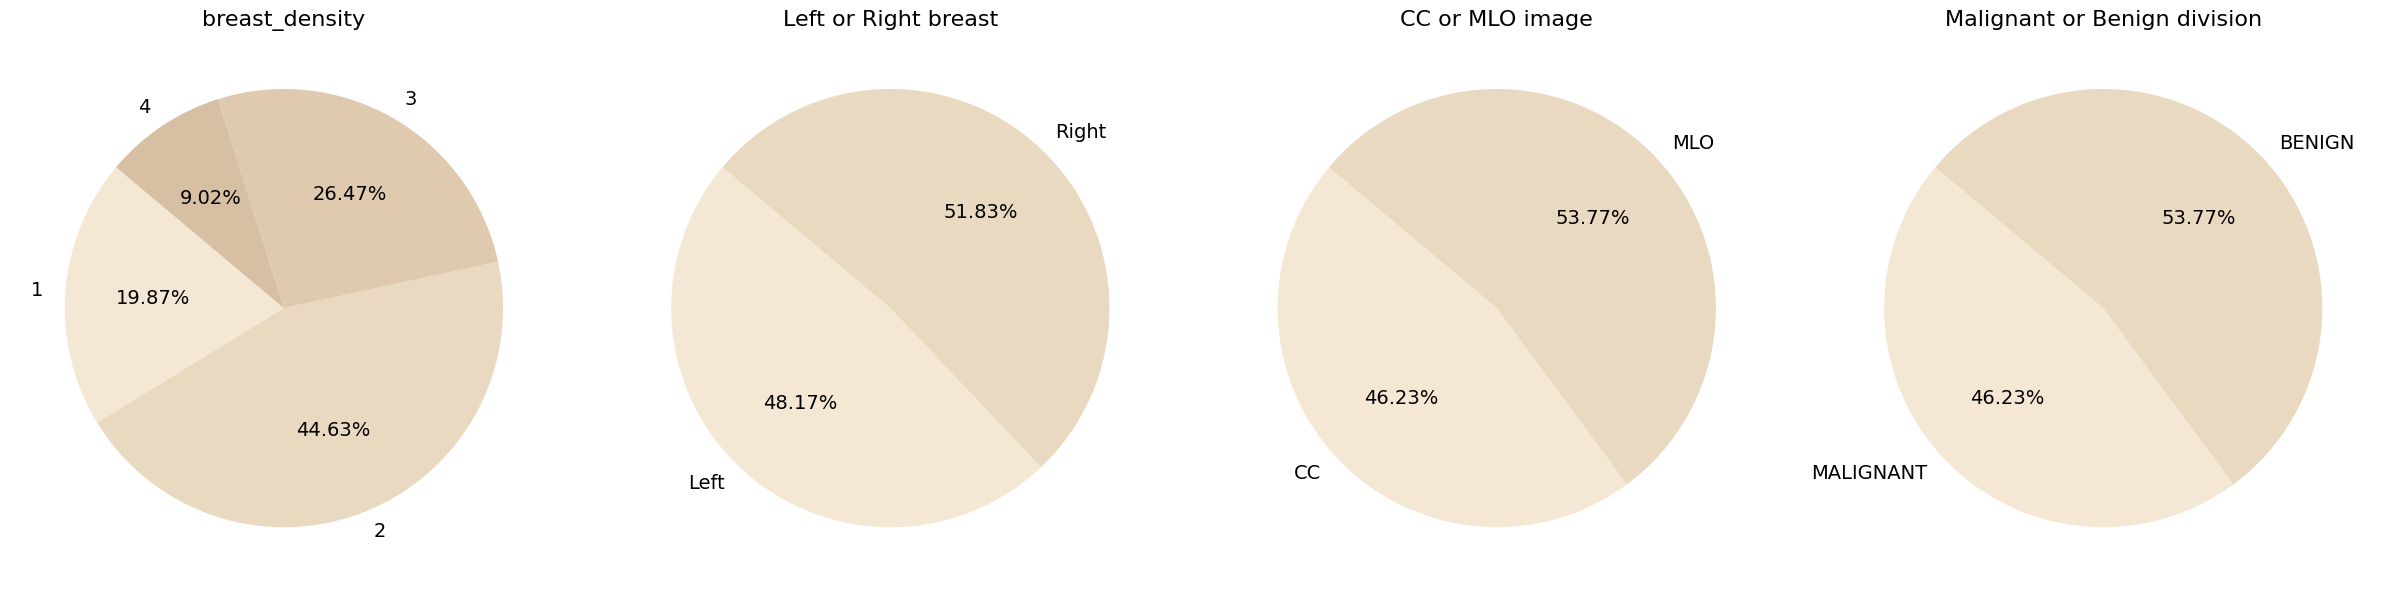

In [64]:
# Create a 1x4 grid of subplots
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
(ax1, ax2, ax3, ax4) = ax

colors1 = ['#f4e7d3', '#e9d9c0', '#dfcab0', '#d6bfa2']

# Subplot 1: Laterality Distribution
density_count = mass['breast_density'].value_counts()
count_1 = density_count.loc[1]
count_2 = density_count.loc[2]
count_3 = density_count.loc[3]
count_4 = density_count.loc[4]

ax1.pie([count_1, count_2, count_3, count_4], labels=['1', '2', '3', '4'], autopct='%1.2f%%', startangle=140, textprops={'fontsize': 14}, colors=colors1)
ax1.set_title('breast_density', fontsize=16)

# Subplot 2: Orientation Distribution
mass_side = mass['left or right breast'].value_counts()
count_Left = mass_side.get('LEFT', 0)
count_Right = mass_side.get('RIGHT', 0)

ax2.pie([count_Left, count_Right], labels=['Left', 'Right'], autopct='%1.2f%%', startangle=140, textprops={'fontsize': 14}, colors=colors1)
ax2.set_title('Left or Right breast', fontsize=16)

# Subplot 3: CC vs MLO
mass_side = mass['image view'].value_counts()
count_CC = mass_side.get('CC', 0)
count_MLO = mass_side.get('MLO', 0)

ax3.pie([count_CC, count_MLO], labels=['CC', 'MLO'], autopct='%1.2f%%', startangle=140, textprops={'fontsize': 14}, colors=colors1)
ax3.set_title('CC or MLO image', fontsize=16)

# Subplot 4: Malignant or benign
mass_side = mass['pathology'].value_counts()
count_malignant = mass_side.get('MALIGNANT', 0)
count_benign = mass_side.get('BENIGN', 0)

ax4.pie([count_malignant, count_benign], labels=['MALIGNANT', 'BENIGN'], autopct='%1.2f%%', startangle=140, textprops={'fontsize': 14}, colors=colors1)
ax4.set_title('Malignant or Benign division', fontsize=16)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


After having looked at the data's distribution, we would like to see how the malignant and benign tumors are divided through out the same data.

In [65]:
mass['malignant'] = mass['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0})

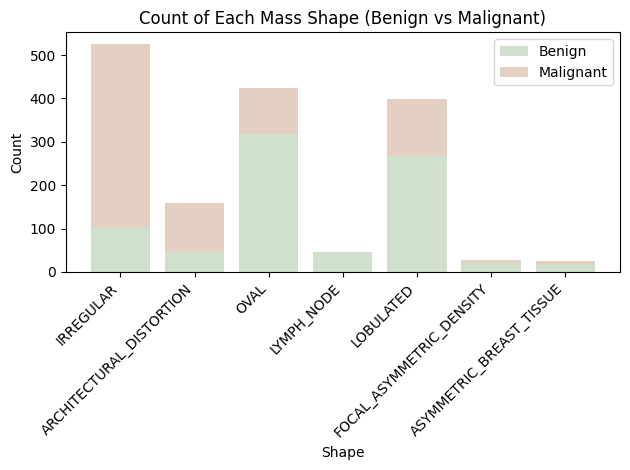

In [66]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE']

malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

malignant_sums = malignant_mass[shapes_of_interest].sum()
benign_sums = benign_mass[shapes_of_interest].sum()

fig, ax = plt.subplots()

ax.bar(shapes_of_interest, benign_sums, label='Benign', color='#D0E0CD')
ax.bar(shapes_of_interest, malignant_sums, bottom=benign_sums, label='Malignant', color='#e4cfc3')
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Mass Shape (Benign vs Malignant)')

plt.xticks(rotation=45, ha='right')

ax.legend()
plt.tight_layout()
plt.show()


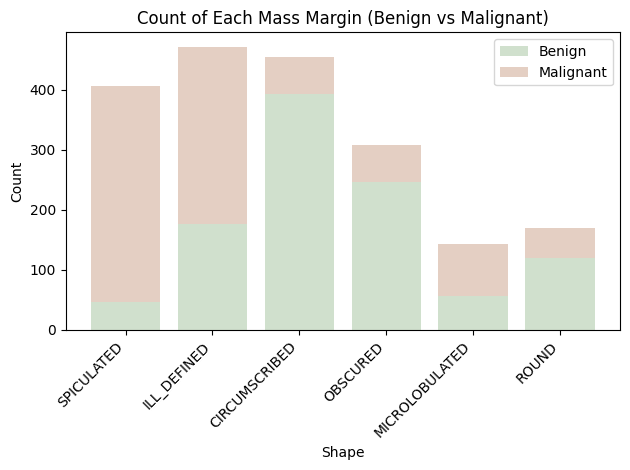

In [67]:
shapes_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED', 'ROUND']

malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

malignant_sums = malignant_mass[shapes_of_interest].sum()
benign_sums = benign_mass[shapes_of_interest].sum()

fig, ax = plt.subplots()

ax.bar(shapes_of_interest, benign_sums, label='Benign', color='#D0E0CD')
ax.bar(shapes_of_interest, malignant_sums, bottom=benign_sums, label='Malignant', color='#e4cfc3')
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Mass Margin (Benign vs Malignant)')

plt.xticks(rotation=45, ha='right')

ax.legend()
plt.tight_layout()
plt.show()


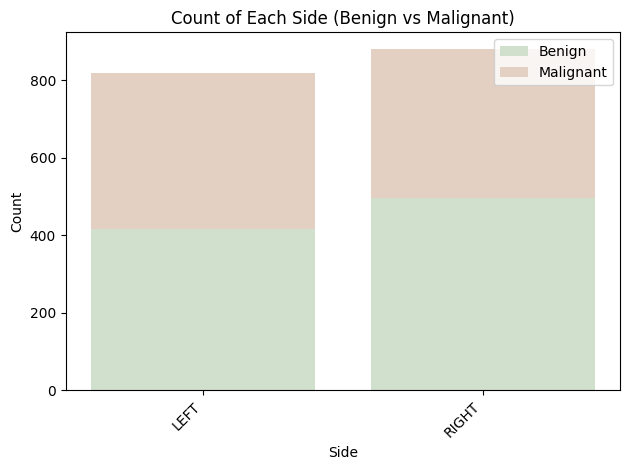

In [68]:
side_of_interest = ['LEFT', 'RIGHT']

malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

malignant_sums = malignant_mass['left or right breast'].value_counts()
benign_sums = benign_mass['left or right breast'].value_counts()

malignant_sums = malignant_sums.reindex(side_of_interest, fill_value=0)
benign_sums = benign_sums.reindex(side_of_interest, fill_value=0)

fig, ax = plt.subplots()

# Plot benign and malignant counts
ax.bar(side_of_interest, benign_sums, label='Benign', color='#D0E0CD')
ax.bar(side_of_interest, malignant_sums, bottom=benign_sums, label='Malignant', color='#e4cfc3')

ax.set_xlabel('Side')
ax.set_ylabel('Count')
ax.set_title('Count of Each Side (Benign vs Malignant)')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

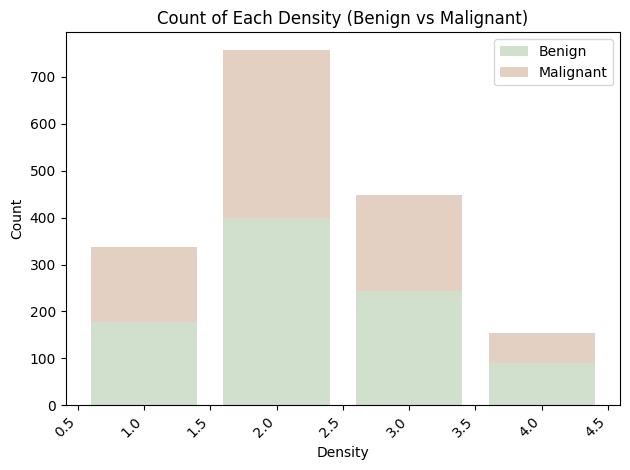

In [69]:
# Filter malignant and benign masses
malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

# Count occurrences for each side
malignant_sums = malignant_mass['breast_density'].value_counts()
benign_sums = benign_mass['breast_density'].value_counts()

# Ensure both malignant and benign have the same indices
density_of_interest = [1, 2, 3, 4]
malignant_sums = malignant_sums.reindex(density_of_interest, fill_value=0)
benign_sums = benign_sums.reindex(density_of_interest, fill_value=0)

fig, ax = plt.subplots()

ax.bar(density_of_interest, benign_sums, label='Benign', color='#D0E0CD')
ax.bar(density_of_interest, malignant_sums, bottom=benign_sums, label='Malignant', color='#e4cfc3')

ax.set_xlabel('Density')
ax.set_ylabel('Count')
ax.set_title('Count of Each Density (Benign vs Malignant)')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

As we can see, the only two attributes that have different malignant and benign distributions are the mass margins and shape, therefore we will need to further explore their affect.

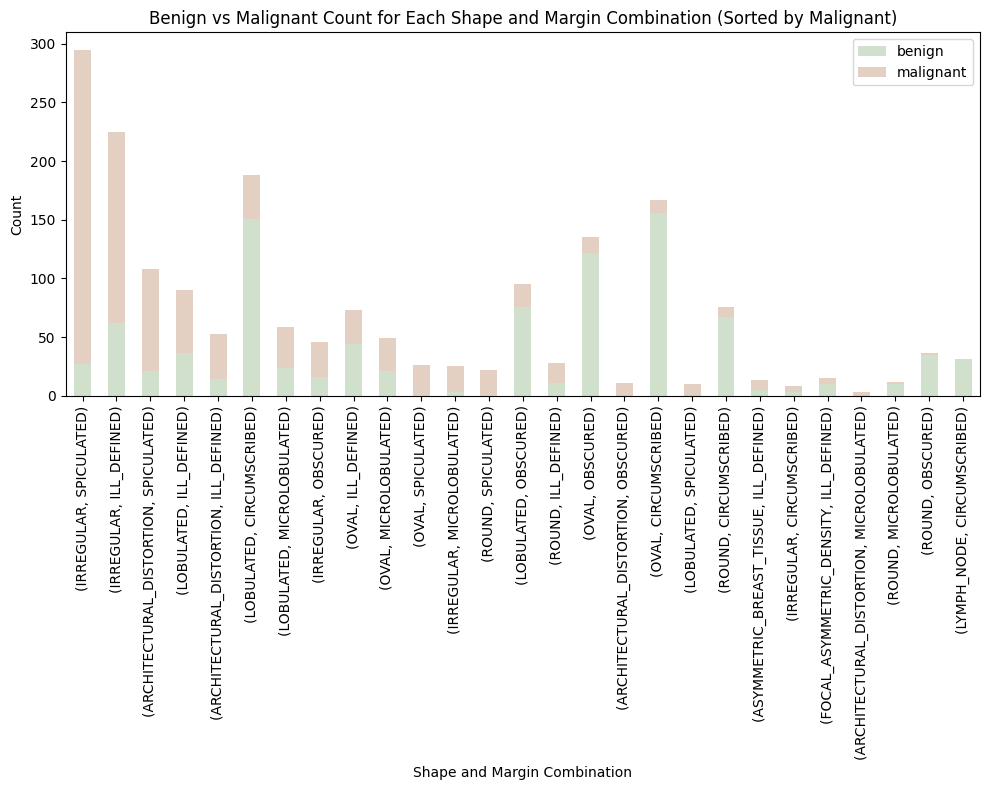

In [70]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE', 'ROUND']

margins_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED']

# Create a DataFrame to store the counts
combinations = []

# Loop through each shape and margin combination
for shape in shapes_of_interest:
    for margin in margins_of_interest:
        # Count the number of benign and malignant cases for each combination
        malignant_count = mass[(mass[shape] == 1) & (mass[margin] == 1) & (mass['malignant'] == 1)].shape[0]
        benign_count = mass[(mass[shape] == 1) & (mass[margin] == 1) & (mass['malignant'] == 0)].shape[0]

        # Append the result to the combinations list
        combinations.append({'shape': shape, 'margin': margin, 'malignant': malignant_count, 'benign': benign_count})

# Convert to DataFrame for easier manipulation
combinations_df = pd.DataFrame(combinations)

# Filter combinations that have more than 1 appearance (either malignant or benign)
combinations_df = combinations_df[(combinations_df['malignant'] + combinations_df['benign']) > 1]

# Sort the DataFrame by malignant count in descending order
combinations_df = combinations_df.sort_values(by='malignant', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Stack the bars for malignant and benign counts with the specified colors
combinations_df.set_index(['shape', 'margin'])[['benign', 'malignant']].plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=['#D0E0CD', '#e4cfc3']
)

# Adding labels and title
ax.set_xlabel('Shape and Margin Combination')
ax.set_ylabel('Count')
ax.set_title('Benign vs Malignant Count for Each Shape and Margin Combination (Sorted by Malignant)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

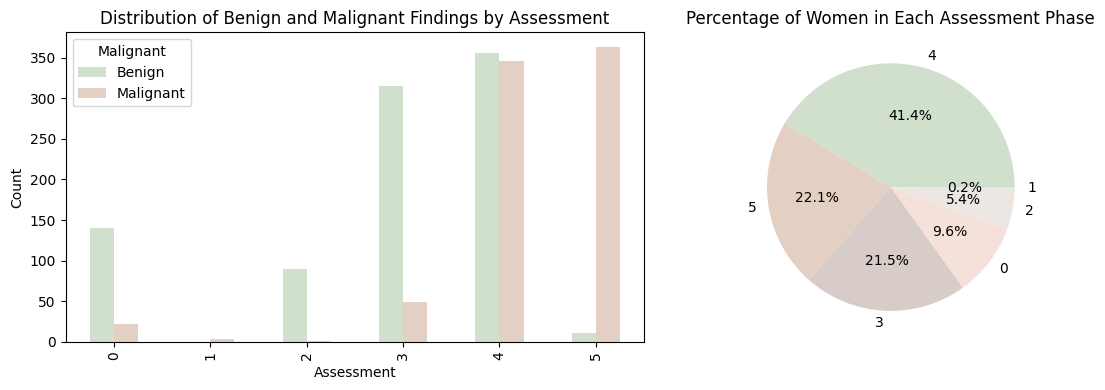

In [71]:
grouped_data = mass.groupby(['assessment', 'malignant']).size().unstack(fill_value=0)
assessment_counts = mass['assessment'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#D0E0CD', '#e4cfc3']
grouped_data.plot(kind='bar', stacked=False, ax=ax1, color=colors)

ax1.set_xlabel('Assessment')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Benign and Malignant Findings by Assessment')
ax1.legend(title='Malignant', labels=['Benign', 'Malignant'])

ax2.pie(assessment_counts, labels=assessment_counts.index, autopct='%1.1f%%')
ax2.set_title('Percentage of Women in Each Assessment Phase')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [72]:
grouped_data_array = grouped_data.to_numpy()
percentages = (grouped_data_array / grouped_data_array.sum(axis=1)[:, np.newaxis] * 100).round(2)
percentages_df = pd.DataFrame(percentages, index=grouped_data.index, columns=grouped_data.columns)

for assessment, row in percentages_df.iterrows():
    print(f"Assessment {assessment}: Benign: {row[0]}%, Malignant: {row[1]}%")


Assessment 0: Benign: 86.42%, Malignant: 13.58%
Assessment 1: Benign: 0.0%, Malignant: 100.0%
Assessment 2: Benign: 98.9%, Malignant: 1.1%
Assessment 3: Benign: 86.54%, Malignant: 13.46%
Assessment 4: Benign: 50.71%, Malignant: 49.29%
Assessment 5: Benign: 2.94%, Malignant: 97.06%


Full assessment explained at:

https://www.cancer.org/cancer/types/breast-cancer/screening-tests-and-early-detection/mammograms/understanding-your-mammogram-report.html

In [73]:
mass = mass.drop(columns=['image file path', 'cropped image file path', 'ROI mask file path', 'subtlety', 'assessment', 'abnormality type'])

In [74]:
mass_new = mass
print(mass.columns)

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'pathology', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant'],
      dtype='object')


In [75]:
columns_to_encode_mass = ['breast_density','left or right breast', 'image view']
mass_one_hot = pd.get_dummies(mass, columns=columns_to_encode_mass, dtype=int)
mass_one_hot = mass_one_hot.drop('pathology', axis =1)

mass_one_hot

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      SPICULATED  malignant  breast_density_1  breast_density_2  \
0              1          1                 0                 0   
1              1          1                 0                 0   
2              0          0                 0                 0   
3              0          0                 0                 0   
4              0          0                 0                 0   
...          ...        ...               ...               ...   
1691           0          0                 0                 1   
1692           0          1                 0                 1   
1693           0          1                 0                 1   
1694           1          1                 0                 0   
1695           1          1                 0                 0   

      breast_density_3  breast_density_4  left or right breast_LEFT  \
0                    1                 0                          1   
1                    1                 0                          1   
2                    1                 0                          1   
3                    1                 0                          1   
4                    1                 0                          0   
...                ...               ...                        ...   
1691                 0                 0                          0   
1692                 0                 0                          0   
1693                 0                 0                          1   
1694                 1                 0                          0   
1695                 1                 0                          0   

      left or ri

# Compare models
Create a table per each algorithm and iteration (100 iterations) with 10 folds for cross validation


In [137]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Ridge Classifier": RidgeClassifier(),
    "Ada Boost Classifier": AdaBoostClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM - Linear": SVC(kernel='linear', probability=True),
    "Naive Bayes": GaussianNB()
}

num_runs = 100
n_splits = 10

for run in range(num_runs):
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_shuffled = mass_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_one_hot_shuffled['malignant']
    groups = mass_one_hot_shuffled['patient_id']
    abnormality_ids = mass_one_hot_shuffled['abnormality id']
    tumor_id = mass_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    group_kfold = GroupKFold(n_splits=n_splits)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model) # run folds on og
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]

        #predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Results_shapeDivided_{model_name}_{run + 1}.csv', index=False)


['P_00054' 'P_01413']


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/'

# Define the models
models = [
    "Logistic Regression", "Linear Discriminant Analysis", "Ridge Classifier",
    "Ada Boost Classifier", "Extra Trees Classifier", "LightGBM",
    "XGBoost", "Random Forest", "K Neighbors Classifier",
    "Decision Tree", "SVM - Linear", "Naive Bayes"
]

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'Results_shapeDivided_{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}
for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Print the average metrics for each model
for model_name, avg_metrics in average_results.items():
    print(f"Model: {model_name}")
    for metric, value in avg_metrics.items():
        if value is not None:
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  {metric}: None")
    print("\n")


Model: Logistic Regression
  accuracy: 0.7943
  recall: 0.7797
  precision: 0.7763
  f1_score: 0.7780
  auc: 0.8619


Model: Linear Discriminant Analysis
  accuracy: 0.7886
  recall: 0.7968
  precision: 0.7583
  f1_score: 0.7771
  auc: 0.8611


Model: Ridge Classifier
  accuracy: 0.7883
  recall: 0.7953
  precision: 0.7585
  f1_score: 0.7765
  auc: None


Model: Ada Boost Classifier
  accuracy: 0.7950
  recall: 0.7750
  precision: 0.7801
  f1_score: 0.7775
  auc: 0.8625


Model: Extra Trees Classifier
  accuracy: 0.7767
  recall: 0.7290
  precision: 0.7747
  f1_score: 0.7511
  auc: 0.8176


Model: LightGBM
  accuracy: 0.7860
  recall: 0.7691
  precision: 0.7683
  f1_score: 0.7687
  auc: 0.8534


Model: XGBoost
  accuracy: 0.7818
  recall: 0.7658
  precision: 0.7631
  f1_score: 0.7644
  auc: 0.8420


Model: Random Forest
  accuracy: 0.7811
  recall: 0.7606
  precision: 0.7646
  f1_score: 0.7626
  auc: 0.8362


Model: K Neighbors Classifier
  accuracy: 0.7739
  recall: 0.7358
  precision

In [ ]:
# Create empty DataFrame
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Value'])

# Calculate average and std for each metric
rows_to_concat = []

for model_name, metrics_list in results.items():
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(d['auc'] for d in metrics_list if d['auc'] is not None) / len([d for d in metrics_list if d['auc'] is not None]) if len([d for d in metrics_list if d['auc'] is not None]) > 0 else None
    }

    # Calculate standard deviation
    std_metrics = {
        'accuracy': np.std([d['accuracy'] for d in metrics_list]),
        'precision': np.std([d['precision'] for d in metrics_list]),
        'recall': np.std([d['recall'] for d in metrics_list]),
        'f1_score': np.std([d['f1_score'] for d in metrics_list]),
        'auc': np.std([d['auc'] for d in metrics_list if d['auc'] is not None])
    }

    # Add average metrics to DataFrame
    for metric, value in avg_metrics.items():
        if value is not None:
            rows_to_concat.append({'Model': model_name, 'Metric': metric, 'Value': value})

    # Add std metrics to DataFrame
    for metric, value in std_metrics.items():
        rows_to_concat.append({'Model': model_name, 'Metric': metric + '_std', 'Value': value})

# Concatenate the rows
results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)

# Pivot the DataFrame for better readability
results_df = results_df.pivot(index='Model', columns='Metric', values='Value')

# Display the results DataFrame
results_df


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-19-bc0cd809715d>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)


Metric                        accuracy  accuracy_std       auc   auc_std  \
Model                                                                      
Ada Boost Classifier          0.795000      0.004066  0.862486  0.001988   
Decision Tree                 0.771663      0.005786  0.804410  0.007726   
Extra Trees Classifier        0.776669      0.004062  0.817603  0.005177   
K Neighbors Classifier        0.773909      0.006604  0.828137  0.004388   
LightGBM                      0.786032      0.005071  0.853385  0.003823   
Linear Discriminant Analysis  0.788650      0.003843  0.861053  0.001926   
Logistic Regression           0.794298      0.003244  0.861859  0.001833   
Naive Bayes                   0.532889      0.005105  0.837273  0.002329   
Random Forest                 0.781067      0.004615  0.836246  0.003974   
Ridge Classifier              0.788343      0.003620       NaN       NaN   
SVM - Linear                  0.789440      0.001647  0.781812  0.005733   
XGBoost                       0.781816      0.004770  0.842013  0.004257   

Metric                        f1_score  f1_score_std  precision  \
Model                                                             
Ada Boost Classifier          0.777545      0.004471   0.780091   
Decision Tree                 0.744172      0.006781   0.771839   
Extra Trees Classifier        0.751091      0.004754   0.774660   
K Neighbors Classifier        0.750493      0.008570   0.766052   
LightGBM                      0.768690      0.005451   0.768309   
Linear Discriminant Analysis  0.777068      0.004062   0.758275   
Logistic Regression           0.778000      0.003559   0.776293   
Naive Bayes                   0.657084      0.002740   0.497321   
Random Forest                 0.762583      0.004985   0.764586   
Ridge Classifier              0.776487      0.003825   0.758542   
SVM - Linear                  0.795424      0.001490   0.721971   
XGBoost                       0.764419      0.005307   0.763091   

Metric                        precision_std    recall  recall_std  
Model                                                              
Ada Boost Classifier               0.005017  0.775038    0.005766  
Decision Tree                      0.007221  0.718469    0.008743  
Extra Trees Classifier             0.005383  0.728954    0.006779  
K Neighbors Classifier             0.009316  0.735816    0.015944  
LightGBM                           0.006570  0.769120    0.007291  
Linear Discriminant Analysis       0.004802  0.796849    0.005861  
Logistic Regression                0.004399  0.779745    0.005411  
Naive Bayes                        0.002825  0.968099    0.003142  
Random Forest                      0.005931  0.760625    0.006469  
Ridge Classifier                   0.004611  0.795332    0.005622  
SVM - Linear                       0.001880  0.885523    0.002122  
XGBoost                            0.005719  0.765791    0.007280

### Observations

After having run the models 100 iterations, we calculated the average metrics and stds for all models.
Top 3 accuracies:


*   Logistic Regression
*   Ada Boost Classifier
*   Linear Discriminant Analysis



# Try to experiment with AdaBoost hyperparameters

https://www.kaggle.com/code/shubhamlipare/adaboost-tutorial-with-hyperparameter-tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

num_runs = 100
n_splits = 10

# Define the parameter grid for AdaBoost
base_estimators = [
    DecisionTreeClassifier(max_depth=2)
    ]

param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'base_estimator': base_estimators
}

models = {
    "Ada Boost Classifier": AdaBoostClassifier()
}


# Rest of your code remains the same
for run in range(num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_shuffled = mass_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_one_hot_shuffled['malignant']
    groups = mass_one_hot_shuffled['patient_id']
    abnormality_ids = mass_one_hot_shuffled['abnormality id']
    tumor_id = mass_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the AdaBoost model
            if model_name == "Ada Boost Classifier":
                grid_search = GridSearchCV(model, param_grid_adaboost, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_HyperTuned/HyperParametersTuning_{model_name}_{run + 1}.csv', index=False)


Run:  0
['P_00054' 'P_01413']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01412               1       1       1  0.533424            1       988
1    P_01543               1       0       0  0.472243            1      1070
2    P_00997               1       1       1  0.512611            1       693
3    P_01153               1       0       0  0.466533            1       800
4    P_01273               3       0       1  0.581487            1       902
Run:  1
['P_01510' 'P_01604']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.318881            1        79
1    P_01119               1       1       1  0.524998            1      1555
2    P_00411               1       0       0  0.483139            1       276
3    P_01281               1       1       0  0.328674            1       907
4    P_01131               1       0       0  0.475837            1       779
Run:  2
['P_01264' 'P_01438']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01411               1       1       0  0.452947            1       987
1    P_00733               1       0       1  0.507994            1       518
2    P_00652               1       0       0  0.468753            1      1471
3    P_01720               1       0       0  0.471233            1      1203
4    P_01685               1       0       0  0.455198            1      1176
Run:  3
['P_01312' 'P_01841']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00303               1       0       0  0.463550            1       203
1    P_00415               1       1       0  0.471867            1       284
2    P_01093               1       1       0  0.466169            1       752
3    P_00969               4       1       0  0.464824            1      1527
4    P_01008               1       1       1  0.524371            1       700
Run:  4
['P_00886' 'P_01270']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.532303            1      1402
1    P_01090               1       0       0  0.440712            1      1548
2    P_00462               1       0       0  0.415471            1       333
3    P_00462               1       0       0  0.441119            1       334
4    P_01326               1       1       1  0.537189            1       929
Run:  5
['P_01000' 'P_01441']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01886               1       0       1  0.594886            1      1300
1    P_01130               1       1       1  0.600531            1       776
2    P_01047               1       1       0  0.402330            1       724
3    P_00915               1       1       0  0.402330            1       644
4    P_01008               1       1       1  0.594886            1       699
Run:  6
['P_01238' 'P_01508']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00032               1       0       0  0.417595            1      1323
1    P_00387               1       0       0  0.482404            1      1407
2    P_00224               1       0       0  0.381139            1       154
3    P_00095               1       1       1  0.506190            1        76
4    P_00212               1       1       1  0.506190            1      1374
Run:  7
['P_00431' 'P_01684']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00882               1       0       0  0.475772            1      1504
1    P_01503               1       0       0  0.472736            1      1048
2    P_01831               1       0       0  0.474124            1      1274
3    P_00334               1       0       0  0.491996            1       232
4    P_01294               1       1       1  0.617684            1      1580
Run:  8
['P_00644' 'P_00766']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00391               1       0       0  0.458377            1      1411
1    P_01654               1       1       0  0.386738            1      1155
2    P_01644               1       1       1  0.575621            1      1146
3    P_00421               1       0       0  0.455684            1       297
4    P_01712               1       0       0  0.442873            1      1194
Run:  9
['P_00419' 'P_01518']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00816               1       0       0  0.473604            1       574
1    P_01467               2       1       1  0.645250            1      1610
2    P_00773               1       1       1  0.508701            1      1492
3    P_01411               1       1       0  0.427929            1       987
4    P_01840               1       0       0  0.454338            1      1277
Run:  10
['P_00039' 'P_00710']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01035               1       1       1  0.519074            1       708
1    P_01261               1       1       1  0.503491            1       879
2    P_01712               1       0       1  0.500175            1      1196
3    P_01279               1       0       1  0.524307            1       904
4    P_01124               1       0       0  0.449886            1       774
Run:  11
['P_00359' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00496               1       0       0  0.482107            1       351
1    P_01733               1       0       1  0.517166            1      1207
2    P_00241               1       1       1  0.555007            1       173
3    P_00451               1       0       0  0.459538            1       327
4    P_01595               1       0       0  0.452004            1      1639
Run:  12
['P_00984' 'P_01632']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00278               1       0       1  0.503429            1      1381
1    P_00886               1       1       1  0.590902            1       617
2    P_00137               1       0       0  0.423564            1       111
3    P_01438               1       1       1  0.568316            1      1006
4    P_01717               1       0       1  0.576212            1      1202
Run:  13
['P_01506' 'P_01832']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00430               1       0       0  0.411459            1       305
1    P_01716               1       0       0  0.387653            1      1666
2    P_01225               1       0       0  0.445220            1       855
3    P_01150               1       0       0  0.411459            1       793
4    P_00081               1       0       0  0.407774            1        61
Run:  14
['P_00122' 'P_01108']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00935               1       1       0  0.426246            1       657
1    P_01323               1       1       1  0.531082            1      1591
2    P_01398               1       0       0  0.414731            1       982
3    P_00428               1       0       0  0.489747            1       303
4    P_00550               1       0       0  0.438799            1       390
Run:  15
['P_00893' 'P_00929']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01739               1       0       0  0.417949            1      1214
1    P_00433               1       0       0  0.488342            1      1419
2    P_00844               1       0       0  0.467149            1       590
3    P_00629               1       0       1  0.605403            1      1464
4    P_00068               1       1       1  0.605403            1        51
Run:  16
['P_00099' 'P_01381']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.539743            1      1402
1    P_01243               1       0       0  0.412005            1       871
2    P_01737               1       0       0  0.385164            1      1211
3    P_00450               1       1       1  0.539743            1       325
4    P_01243               1       0       0  0.412005            1       872
Run:  17
['P_00648' 'P_01194']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01158               1       0       0  0.456814            1       803
1    P_00421               1       0       0  0.451347            1       298
2    P_01632               1       0       0  0.233640            1      1123
3    P_01787               1       1       1  0.538162            1      1678
4    P_00481               1       1       1  0.547628            1      1428
Run:  18
['P_01213' 'P_01712']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.466806            1       164
1    P_00559               1       0       0  0.478481            1       396
2    P_00056               1       0       0  0.479941            1      1327
3    P_00902               1       1       0  0.493107            1       631
4    P_00695               1       1       0  0.496515            1       477
Run:  19
['P_00495' 'P_00914']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.219932            1        79
1    P_00417               1       0       1  0.503020            1       286
2    P_01716               1       0       0  0.427216            1      1666
3    P_00851               1       1       0  0.455271            1       598
4    P_00700               1       0       0  0.478703            1       480
Run:  20
['P_00064' 'P_00670']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00386               1       1       1  0.539763            1       262
1    P_00870               1       1       1  0.561477            1       609
2    P_01322               1       0       0  0.492226            1      1588
3    P_00581               1       1       1  0.562490            1       412
4    P_00837               1       0       0  0.452689            1      1500
Run:  21
['P_00347' 'P_00698']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01775               1       1       1  0.505284            1      1234
1    P_00662               1       0       1  0.545662            1      1473
2    P_01179               1       1       1  0.507002            1       824
3    P_00549               1       0       0  0.425920            1       389
4    P_01151               1       1       1  0.500317            1       795
Run:  22
['P_00949' 'P_01983']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00289               1       0       0  0.453737            1       196
1    P_00389               1       0       0  0.437184            1       264
2    P_01712               1       0       0  0.460244            1      1194
3    P_01123               1       0       0  0.477986            1       773
4    P_01163               1       1       1  0.553889            1       808
Run:  23
['P_01406' 'P_01638']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01192               1       0       1  0.508907            1      1564
1    P_00816               1       0       0  0.483718            1       574
2    P_00829               1       0       0  0.407213            1       583
3    P_01698               1       0       0  0.445675            1      1185
4    P_01716               1       0       0  0.425936            1      1667
Run:  24
['P_00816' 'P_01103']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00099               1       0       0  0.450384            1      1330
1    P_00241               1       1       1  0.555853            1       173
2    P_01412               1       1       1  0.546049            1       988
3    P_01573               1       1       1  0.524551            1      1087
4    P_00108               1       0       0  0.447577            1        94
Run:  25
['P_00849' 'P_01822']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00901               1       1       1  0.610834            1       628
1    P_01682               1       1       1  0.504502            1      1175
2    P_00171               1       0       1  0.537259            1      1351
3    P_00126               1       0       0  0.384857            1      1339
4    P_01447               1       0       0  0.419021            1      1017
Run:  26
['P_00086' 'P_00384']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01280               1       0       0  0.471586            1       906
1    P_01682               1       1       1  0.501255            1      1175
2    P_01305               1       0       0  0.472799            1       921
3    P_01090               1       0       0  0.480434            1      1548
4    P_01076               1       1       1  0.503957            1       741
Run:  27
['P_00054' 'P_00987']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00436               1       0       1  0.508666            1       314
1    P_00016               1       1       1  0.538793            1      1319
2    P_00413               1       1       1  0.538761            1       280
3    P_00265               1       1       1  0.523628            1       187
4    P_01090               4       0       0  0.472727            1      1547
Run:  28
['P_01152' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01780               1       1       1  0.567525            1      1237
1    P_01439               1       0       0  0.445409            1      1008
2    P_00037               1       1       1  0.562420            1      1326
3    P_00435               1       1       1  0.537103            1       312
4    P_00739               1       0       0  0.431552            1       523
Run:  29
['P_00917' 'P_01680']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.407469            1       164
1    P_00995               1       1       1  0.574484            1       691
2    P_00347               1       1       1  0.549153            1      1393
3    P_01663               1       0       0  0.460320            1      1163
4    P_00995               1       1       1  0.574484            1       690
Run:  30
['P_00630' 'P_00665']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


Run:  79
['P_00630' 'P_01402']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01486               1       0       0  0.472407            1      1036
1    P_00639               1       0       1  0.510803            1      1468
2    P_01203               1       0       0  0.469663            1       839
3    P_01144               1       1       1  0.596505            1       787
4    P_00429               1       0       1  0.596505            1      1417
Run:  80
['P_00865' 'P_01853']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01912               1       1       1  0.533888            1      1695
1    P_00528               2       0       0  0.458516            1       374
2    P_00694               1       0       0  0.477089            1       475
3    P_00465               1       1       1  0.532209            1       336
4    P_01350               1       1       0  0.483401            1       943
Run:  81
['P_00666' 'P_01701']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01889               1       0       0  0.421117            1      1304
1    P_01484               1       0       1  0.537871            1      1032
2    P_00738               1       0       0  0.485619            1      1484
3    P_00175               1       1       0  0.472588            1       131
4    P_00932               1       1       0  0.493874            1      1514
Run:  82
['P_00023' 'P_00435']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00797               1       0       0  0.422276            1       559
1    P_00298               1       0       0  0.491971            1       200
2    P_01018               1       0       0  0.415900            1       703
3    P_00776               1       1       1  0.504315            1       541
4    P_00737               1       1       0  0.453684            1       520
Run:  83
['P_00171' 'P_00289']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00147               1       1       1  0.503360            1      1346
1    P_01070               1       1       1  0.509259            1       737
2    P_00021               1       0       0  0.478059            1        13
3    P_00095               1       1       1  0.502103            1        76
4    P_00106               2       0       0  0.315004            1        91
Run:  84
['P_00732' 'P_01572']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00539               1       1       1  0.623392            1       382
1    P_01331               1       0       1  0.530576            1      1592
2    P_00584               1       1       1  0.533104            1       413
3    P_01557               1       0       0  0.453488            1      1075
4    P_01267               1       0       0  0.490783            1       887
Run:  85
['P_00896' 'P_01702']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01103               3       1       1  0.509104            1       761
1    P_01853               1       1       1  0.529363            1      1287
2    P_00218               1       1       0  0.491318            1       150
3    P_00177               1       0       1  0.511645            1      1358
4    P_01600               1       1       0  0.477793            1      1101
Run:  86
['P_00431' 'P_01103']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01589               1       1       1  0.539587            1      1093
1    P_01558               1       1       1  0.517957            1      1630
2    P_00984               1       1       0  0.471668            1       683
3    P_00636               1       1       0  0.490305            1      1466
4    P_00026               1       0       0  0.467085            1        17
Run:  87
['P_00081' 'P_00159']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00554               1       1       0  0.400770            1       393
1    P_01305               1       0       0  0.416064            1       921
2    P_00731               1       0       0  0.420710            1       513
3    P_00781               1       0       0  0.382960            1       549
4    P_00287               1       1       1  0.609351            1       194
Run:  88
['P_01566' 'P_01620']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01146               1       0       0  0.474872            1       789
1    P_00207               1       1       1  0.525244            1       140
2    P_01163               1       1       1  0.530278            1       808
3    P_00626               1       0       0  0.482047            1       435
4    P_01331               1       0       1  0.531363            1      1592
Run:  89
['P_00356' 'P_00894']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01155               1       1       0  0.479296            1       801
1    P_01761               1       1       1  0.516435            1      1231
2    P_00264               1       1       0  0.385354            1       184
3    P_00192               1       0       0  0.448652            1      1360
4    P_01682               1       1       1  0.531363            1      1174
Run:  90
['P_00644' 'P_01484']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               5       0       0  0.315459            1        86
1    P_01475               1       0       0  0.483496            1      1026
2    P_00475               1       0       1  0.508728            1       341
3    P_01355               1       1       1  0.524900            1       945
4    P_01232               1       1       1  0.532797            1       861
Run:  91
['P_00493' 'P_01212']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00803               1       1       0  0.482209            1       568
1    P_01423               1       0       0  0.493975            1       995
2    P_01908               1       1       0  0.492616            1      1307
3    P_01849               1       0       0  0.239979            1      1284
4    P_00076               1       0       0  0.477502            1        56
Run:  92
['P_00733' 'P_02092']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00406               1       1       1  0.535190            1       271
1    P_00061               1       0       0  0.428632            1        46
2    P_00411               1       0       0  0.454469            1       275
3    P_00893               1       0       0  0.492785            1      1507
4    P_01371               1       1       1  0.517706            1       958
Run:  93
['P_00224' 'P_01312']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00673               3       0       0  0.312273            1       464
1    P_00454               1       0       0  0.475370            1       331
2    P_01226               1       0       0  0.479508            1       857
3    P_00972               1       1       1  0.507683            1       676
4    P_01391               1       1       1  0.570826            1       974
Run:  94
['P_00278' 'P_01332']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00739               1       0       0  0.452908            1       522
1    P_01330               1       0       1  0.533227            1       933
2    P_01673               1       0       0  0.491284            1      1657
3    P_01684               1       0       0  0.459375            1      1661
4    P_00444               1       1       1  0.522971            1       324
Run:  95
['P_01110' 'P_01741']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00242               1       0       0  0.466956            1       175
1    P_01014               1       1       0  0.450102            1      1537
2    P_00753               1       1       1  0.580970            1       530
3    P_00870               1       1       1  0.575832            1       609
4    P_00128               1       1       1  0.502389            1       106
Run:  96
['P_00016' 'P_01438']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01103               3       1       1  0.535109            1       758
1    P_00134               1       1       0  0.499348            1       109
2    P_00273               1       0       0  0.444938            1       188
3    P_01606               1       1       0  0.452268            1      1105
4    P_01235               1       1       1  0.570361            1      1571
Run:  97
['P_00076' 'P_00092']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01175               1       0       0  0.463530            1       818
1    P_00081               1       0       0  0.475855            1        62
2    P_00779               1       1       1  0.558270            1       548
3    P_01175               1       0       0  0.461787            1       819
4    P_00716               1       1       1  0.555185            1       501
Run:  98
['P_01649' 'P_01890']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00319               1       1       1  0.578575            1       216
1    P_00239               1       0       0  0.483671            1       169
2    P_01398               1       0       0  0.392274            1       981
3    P_01140               1       1       1  0.553436            1      1557
4    P_00289               1       0       0  0.450294            1       196
Run:  99
['P_00935' 'P_01218']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01290               1       1       1  0.554555            1       911
1    P_00414               1       1       1  0.552387            1       281
2    P_00200               1       0       0  0.445759            1      1366
3    P_01185               1       0       0  0.432165            1       829
4    P_01209               1       0       0  0.481699            1       843


In [ ]:
# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_HyperTuned/'

# Define the models
models = ['HyperParametersTuning_Ada Boost Classifier']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")


Model: HyperParametersTuning_Ada Boost Classifier
  accuracy: 0.7999
  recall: 0.7928
  precision: 0.7785
  f1_score: 0.7856
  auc: 0.8598




#### Removing Image view & Sides

In [58]:
## ANOTHER TRYYYYY - removing left/right breast and MLO/ CC---------------
from sklearn.model_selection import GridSearchCV

num_runs = 33
n_splits = 10

# Define the parameter grid for AdaBoost
base_estimators = [
    DecisionTreeClassifier(max_depth=2)
    ]

param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'base_estimator': base_estimators
}

models = {
    "Ada Boost Classifier": AdaBoostClassifier()
}


# Rest of your code remains the same
for run in range(5, num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_shuffled = mass_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id', 'left or right breast_LEFT', 'left or right breast_RIGHT', 'image view_CC', 'image view_MLO'], axis=1)
    y = mass_one_hot_shuffled['malignant']
    groups = mass_one_hot_shuffled['patient_id']
    abnormality_ids = mass_one_hot_shuffled['abnormality id']
    tumor_id = mass_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the AdaBoost model
            if model_name == "Ada Boost Classifier":
                grid_search = GridSearchCV(model, param_grid_adaboost, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withoutCCMLO_SIDEs/HyperParametersTuning_{model_name}_{run + 1}.csv', index=False)


Run:  5
['P_01000' 'P_01441']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01886               1       0       1  0.596937            1      1300
1    P_01130               1       1       1  0.602265            1       776
2    P_01047               1       1       0  0.398765            1       724
3    P_00915               1       1       0  0.398765            1       644
4    P_01008               1       1       1  0.596937            1       699
Run:  6
['P_01238' 'P_01508']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00032               1       0       0  0.453506            1      1323
1    P_00387               1       0       0  0.480273            1      1407
2    P_00224               1       0       0  0.431141            1       154
3    P_00095               1       1       1  0.505405            1        76
4    P_00212               1       1       1  0.502493            1      1374
Run:  7
['P_00431' 'P_01684']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00882               1       0       0  0.468985            1      1504
1    P_01503               1       0       0  0.465115            1      1048
2    P_01831               1       0       0  0.465243            1      1274
3    P_00334               1       0       0  0.489896            1       232
4    P_01294               1       1       1  0.598471            1      1580
Run:  8
['P_00644' 'P_00766']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00391               1       0       0  0.468058            1      1411
1    P_01654               1       1       0  0.407937            1      1155
2    P_01644               1       1       1  0.558163            1      1146
3    P_00421               1       0       0  0.466566            1       297
4    P_01712               1       0       0  0.456844            1      1194
Run:  9
['P_00419' 'P_01518']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00816               1       0       0  0.481658            1       574
1    P_01467               2       1       1  0.640545            1      1610
2    P_00773               1       1       1  0.503441            1      1492
3    P_01411               1       1       0  0.448355            1       987
4    P_01840               1       0       0  0.466735            1      1277
Run:  10
['P_00039' 'P_00710']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01035               1       1       1  0.508365            1       708
1    P_01261               1       1       1  0.502469            1       879
2    P_01712               1       0       1  0.502041            1      1196
3    P_01279               1       0       1  0.513718            1       904
4    P_01124               1       0       0  0.476080            1       774
Run:  11
['P_00359' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00496               1       0       0  0.493767            1       351
1    P_01733               1       0       1  0.509824            1      1207
2    P_00241               1       1       1  0.536851            1       173
3    P_00451               1       0       0  0.471784            1       327
4    P_01595               1       0       0  0.465393            1      1639
Run:  12
['P_00984' 'P_01632']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00278               1       0       1  0.504973            1      1381
1    P_00886               1       1       1  0.606583            1       617
2    P_00137               1       0       0  0.431591            1       111
3    P_01438               1       1       1  0.553578            1      1006
4    P_01717               1       0       1  0.558016            1      1202
Run:  13
['P_01506' 'P_01832']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00430               1       0       0  0.411459            1       305
1    P_01716               1       0       0  0.387653            1      1666
2    P_01225               1       0       0  0.440550            1       855
3    P_01150               1       0       0  0.411459            1       793
4    P_00081               1       0       0  0.407774            1        61
Run:  14
['P_00122' 'P_01108']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00935               1       1       0  0.443992            1       657
1    P_01323               1       1       1  0.524984            1      1591
2    P_01398               1       0       0  0.397576            1       982
3    P_00428               1       0       0  0.492861            1       303
4    P_00550               1       0       0  0.447254            1       390
Run:  15
['P_00893' 'P_00929']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01739               1       0       0  0.417949            1      1214
1    P_00433               1       0       0  0.488342            1      1419
2    P_00844               1       0       0  0.467149            1       590
3    P_00629               1       0       1  0.605403            1      1464
4    P_00068               1       1       1  0.605403            1        51
Run:  16
['P_00099' 'P_01381']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.518437            1      1402
1    P_01243               1       0       0  0.446305            1       871
2    P_01737               1       0       0  0.434772            1      1211
3    P_00450               1       1       1  0.518437            1       325
4    P_01243               1       0       0  0.446305            1       872
Run:  17
['P_00648' 'P_01194']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01158               1       0       0  0.466737            1       803
1    P_00421               1       0       0  0.463856            1       298
2    P_01632               1       0       0  0.222112            1      1123
3    P_01787               1       1       1  0.531635            1      1678
4    P_00481               1       1       1  0.544919            1      1428
Run:  18
['P_01213' 'P_01712']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.381356            1       164
1    P_00559               1       0       0  0.421347            1       396
2    P_00056               1       0       0  0.421347            1      1327
3    P_00902               1       1       0  0.458409            1       631
4    P_00695               1       1       1  0.506966            1       477
Run:  19
['P_00495' 'P_00914']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.231648            1        79
1    P_00417               1       0       1  0.503214            1       286
2    P_01716               1       0       0  0.412759            1      1666
3    P_00851               1       1       0  0.444213            1       598
4    P_00700               1       0       0  0.472977            1       480
Run:  20
['P_00064' 'P_00670']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00386               1       1       1  0.565671            1       262
1    P_00870               1       1       1  0.620127            1       609
2    P_01322               1       0       0  0.491086            1      1588
3    P_00581               1       1       1  0.622194            1       412
4    P_00837               1       0       0  0.416925            1      1500
Run:  21
['P_00347' 'P_00698']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01775               1       1       1  0.501748            1      1234
1    P_00662               1       0       1  0.519709            1      1473
2    P_01179               1       1       1  0.507284            1       824
3    P_00549               1       0       0  0.424529            1       389
4    P_01151               1       1       1  0.505066            1       795
Run:  22
['P_00949' 'P_01983']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00289               1       0       0  0.472037            1       196
1    P_00389               1       0       0  0.457466            1       264
2    P_01712               1       0       0  0.479531            1      1194
3    P_01123               1       0       0  0.482655            1       773
4    P_01163               1       1       1  0.527963            1       808
Run:  23
['P_01406' 'P_01638']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01192               1       0       1  0.507176            1      1564
1    P_00816               1       0       0  0.482031            1       574
2    P_00829               1       0       0  0.407437            1       583
3    P_01698               1       0       0  0.444768            1      1185
4    P_01716               1       0       0  0.426584            1      1667
Run:  24
['P_00816' 'P_01103']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00099               1       0       0  0.411155            1      1330
1    P_00241               1       1       1  0.601194            1       173
2    P_01412               1       1       1  0.574467            1       988
3    P_01573               1       1       1  0.547167            1      1087
4    P_00108               1       0       0  0.402120            1        94
Run:  25
['P_00849' 'P_01822']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00901               1       1       1  0.610800            1       628
1    P_01682               1       1       1  0.501021            1      1175
2    P_00171               1       0       1  0.537333            1      1351
3    P_00126               1       0       0  0.386322            1      1339
4    P_01447               1       0       0  0.418989            1      1017
Run:  26
['P_00086' 'P_00384']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01280               1       0       0  0.449266            1       906
1    P_01682               1       1       0  0.498727            1      1175
2    P_01305               1       0       0  0.447049            1       921
3    P_01090               1       0       0  0.462244            1      1548
4    P_01076               1       1       1  0.509242            1       741
Run:  27
['P_00054' 'P_00987']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00436               1       0       1  0.504623            1       314
1    P_00016               1       1       1  0.526512            1      1319
2    P_00413               1       1       1  0.524547            1       280
3    P_00265               1       1       1  0.519502            1       187
4    P_01090               4       0       0  0.482075            1      1547
Run:  28
['P_01152' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01780               1       1       1  0.597317            1      1237
1    P_01439               1       0       0  0.422677            1      1008
2    P_00037               1       1       1  0.593495            1      1326
3    P_00435               1       1       1  0.550560            1       312
4    P_00739               1       0       0  0.398011            1       523
Run:  29
['P_00917' 'P_01680']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.427556            1       164
1    P_00995               1       1       1  0.558417            1       691
2    P_00347               1       1       1  0.536424            1      1393
3    P_01663               1       0       0  0.467799            1      1163
4    P_00995               1       1       1  0.558417            1       690
Run:  30
['P_00630' 'P_00665']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01090               1       0       0  0.467106            1      1541
1    P_00092               1       1       0  0.459353            1        70
2    P_00117               1       0       0  0.469816            1       100
3    P_01787               1       1       1  0.519501            1      1678
4    P_01212               1       0       1  0.503165            1       845
Run:  31
['P_00741' 'P_01551']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00515               2       0       0  0.451190            1       361
1    P_01090               1       0       0  0.485945            1      1541
2    P_00515               1       0       0  0.495327            1       363
3    P_01189               1       1       1  0.529176            1       831
4    P_01090               2       0       0  0.491954            1      1545
Run:  32
['P_01327' 'P_01719']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01273               1       0       0  0.486491            1       900
1    P_00892               1       1       1  0.526475            1       623
2    P_00190               1       1       1  0.518115            1       134
3    P_00304               1       0       1  0.507525            1       205
4    P_00717               1       1       1  0.512124            1       502


In [60]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withoutCCMLO_SIDEs/'

# Define the models
models = ['HyperParametersTuning_Ada Boost Classifier']

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics

# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average and standard deviation metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    accuracies = [d['accuracy'] for d in metrics_list if d['accuracy'] is not None]
    recalls = [d['recall'] for d in metrics_list if d['recall'] is not None]
    precisions = [d['precision'] for d in metrics_list if d['precision'] is not None]
    f1_scores = [d['f1_score'] for d in metrics_list if d['f1_score'] is not None]
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]

    avg_metrics = {
        'accuracy': np.mean(accuracies) if len(accuracies) > 0 else None,
        'recall': np.mean(recalls) if len(recalls) > 0 else None,
        'precision': np.mean(precisions) if len(precisions) > 0 else None,
        'f1_score': np.mean(f1_scores) if len(f1_scores) > 0 else None,
        'auc': np.mean(valid_auc_values) if len(valid_auc_values) > 0 else None
    }

    # Calculate standard deviations
    std_metrics = {
        'accuracy_std': np.std(accuracies) if len(accuracies) > 0 else None,
        'recall_std': np.std(recalls) if len(recalls) > 0 else None,
        'precision_std': np.std(precisions) if len(precisions) > 0 else None,
        'f1_score_std': np.std(f1_scores) if len(f1_scores) > 0 else None,
        'auc_std': np.std(valid_auc_values) if len(valid_auc_values) > 0 else None
    }

    # Store both average and std metrics in the result
    average_results[model_name] = {
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics
    }

# Sort models by average accuracy in descending order
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['avg_metrics']['accuracy'], reverse=True)

# Print the average and std metrics for each model
for model_name, metrics_dict in sorted_results:
    avg_metrics = metrics_dict['avg_metrics']
    std_metrics = metrics_dict['std_metrics']

    print(f"Model: {model_name}")
    # Print average metrics
    print("  Averages:")
    for metric, value in avg_metrics.items():
        if value is not None:
            print(f"    {metric}: {value:.4f}")
        else:
            print(f"    {metric}: None")

    # Print standard deviation metrics
    print("  Standard Deviations:")
    for metric, value in std_metrics.items():
        if value is not None:
            print(f"    {metric}: {value:.4f}")
        else:
            print(f"    {metric}: None")

    print("\n")  # Add an extra newline for readability between models


Model: HyperParametersTuning_Ada Boost Classifier
  Averages:
    accuracy: 0.7994
    recall: 0.7909
    precision: 0.7787
    f1_score: 0.7848
    auc: 0.8595
  Standard Deviations:
    accuracy_std: 0.0045
    recall_std: 0.0066
    precision_std: 0.0055
    f1_score_std: 0.0050
    auc_std: 0.0037




# Understanding the Results

In [35]:
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_HyperTuned/'
result_df = pd.DataFrame()

# Loop through all the relevant CSV files
for i in range(1, 101):
    # Construct the filename
    filename = f'{base_path}HyperParametersTuning_Ada Boost Classifier_{i}.csv'

    # Load the CSV file into a DataFrame
    new_df = pd.read_csv(filename)

    # Add a column with the file number
    new_df['file_number'] = i

    # Append the DataFrame to the result DataFrame
    result_df = pd.concat([result_df, new_df], ignore_index=True)

# Save the combined DataFrame to a new CSV file
result_df.to_csv(f'{base_path}ALL_HyperParametersTuning_Ada_Boost.csv', index=False)


In [36]:
result_df

patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  \
0         P_01412               1       1       1  0.533424            1   
1         P_01543               1       0       0  0.472243            1   
2         P_00997               1       1       1  0.512611            1   
3         P_01153               1       0       0  0.466533            1   
4         P_01273               3       0       1  0.581487            1   
...           ...             ...     ...     ...       ...          ...   
169595    P_00342               2       0       0  0.433823           10   
169596    P_00224               1       0       1  0.508415           10   
169597    P_01243               1       0       0  0.424672           10   
169598    P_00313               1       1       1  0.508650           10   
169599    P_01481               1       1       1  0.574438           10   

        tumor_id  file_number  
0            988            1  
1           1070            1  
2            693            1  
3            800            1  
4            902            1  
...          ...          ...  
169595       236          100  
169596       155          100  
169597       871          100  
169598       211          100  
169599      1029          100  

[169600 rows x 8 columns]

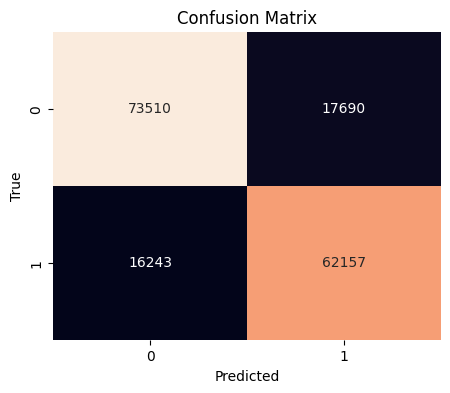

In [37]:
y_true = result_df['y_true']
y_pred = result_df['y_pred']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Full Results analysis

In [38]:
result_mass.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'assessment', 'pathology',
       'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant'],
      dtype='object')

In [39]:
# Merging y_pred and y_prob from result_df into full_mass
full_mass_results = result_mass.merge(result_df[['tumor_id', 'y_pred', 'y_prob', 'fold_number', 'file_number']], on='tumor_id', how='left')

In [40]:
full_mass_results.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'assessment', 'pathology',
       'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'y_pred', 'y_prob',
       'fold_number', 'file_number'],
      dtype='object')

In [41]:
full_mass_results['malignant'] = full_mass_results['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0})

In [42]:
full_mass_results

patient_id  breast_density left or right breast image view  \
0         P_00001               3                 LEFT         CC   
1         P_00001               3                 LEFT         CC   
2         P_00001               3                 LEFT         CC   
3         P_00001               3                 LEFT         CC   
4         P_00001               3                 LEFT         CC   
...           ...             ...                  ...        ...   
169595    P_01912               3                RIGHT        MLO   
169596    P_01912               3                RIGHT        MLO   
169597    P_01912               3                RIGHT        MLO   
169598    P_01912               3                RIGHT        MLO   
169599    P_01912               3                RIGHT        MLO   

       abnormality id abnormality type  assessment  pathology  subtlety  \
0                   1             mass           4  MALIGNANT         4   
1                   1             mass           4  MALIGNANT         4   
2                   1             mass           4  MALIGNANT         4   
3                   1             mass           4  MALIGNANT         4   
4                   1             mass           4  MALIGNANT         4   
...               ...              ...         ...        ...       ...   
169595              1             mass           5  MALIGNANT         4   
169596              1             mass           5  MALIGNANT         4   
169597              1             mass           5  MALIGNANT         4   
169598              1             mass           5  MALIGNANT         4   
169599              1             mass           5  MALIGNANT         4   

                                          image file path  ... CIRCUMSCRIBED  \
0       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
1       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
2       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
3       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
4       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...             0   
...                                                   ...  ...           ...   
169595  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169596  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169597  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169598  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   
169599  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...             0   

       ILL_DEFINED  MICROLOBULATED  OBSCURED  SPICULATED  malignant  y_pred  \
0                0               0         0           1          1       1   
1                0               0         0           1          1       1   
2                0               0         0           1          1       1   
3                0               0         0           1          1       1   
4                0               0         0           1          1       1   
...            ...             ...       ...         ...        ...     ...   
169595           0               0         0           1          1       1   
169596           0               0         0           1          1       1   
169597           0               0         0           1          1       1   
169598           0               0         0           1          1       1   
169599           0               0         0           1          1       1   

          y_prob  fold_number  file_number  
0       0.547186            4            1  
1       0.546038            8            2  
2       0.529768            6            3  
3       0.566225            3            4  
4       0.528517            4            5  
...          ...          ...          ...  
169595  0.549095            8           96  
169596 

In [43]:
full_mass_results.to_csv('full_mass_results_withFold.csv', index=False)

## Exploring important attributes

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define your custom colors
colors = ['#D0E0CD', '#71a16a','#e4cfc3', '#CCA58c', '#EDE7E3', '#DFE4D4', '#C9C5BA']


# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap_exp', colors, N=256)

# Register a new colormap with a different name
plt.register_cmap(name='custom_cmap_exp', cmap=cmap)

# Set the color cycle globally
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['image.cmap'] = 'custom_cmap_exp'


<ipython-input-44-6132a1a18aa9>:12: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='custom_cmap_exp', cmap=cmap)


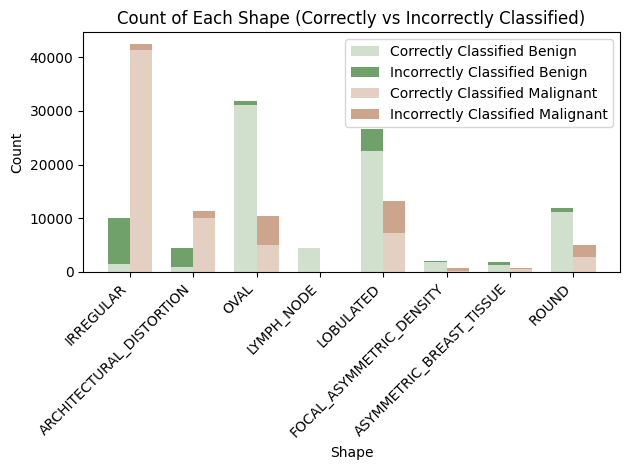

In [45]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE', 'ROUND']

# Filter data
malignant_mass_hit = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 1)]
benign_mass_hit = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 0)]
malignant_mass_miss = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 0)]
benign_mass_miss = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 1)]

# Aggregate counts for each shape
malignant_hit_sums = malignant_mass_hit[shapes_of_interest].sum()
benign_hit_sums = benign_mass_hit[shapes_of_interest].sum()
malignant_miss_sums = malignant_mass_miss[shapes_of_interest].sum()
benign_miss_sums = benign_mass_miss[shapes_of_interest].sum()

# Positions for bars
x = np.arange(len(shapes_of_interest))
width = 0.35

fig, ax = plt.subplots()

# Plot bars for benign tumors
rects1 = ax.bar(x - width/2, benign_hit_sums, width, label='Correctly Classified Benign')#, color='#D0E0CD')
rects2 = ax.bar(x - width/2, benign_miss_sums, width, bottom=benign_hit_sums, label='Incorrectly Classified Benign')#, color='#71a16a')

# Plot bars for malignant tumors
rects3 = ax.bar(x + width/2, malignant_hit_sums, width, label='Correctly Classified Malignant')#, color='#e4cfc3')
rects4 = ax.bar(x + width/2, malignant_miss_sums, width, bottom=malignant_hit_sums, label='Incorrectly Classified Malignant')#, color='#CCA58c')

# Set labels and title
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Shape (Correctly vs Incorrectly Classified)')
ax.set_xticks(x)
ax.set_xticklabels(shapes_of_interest, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


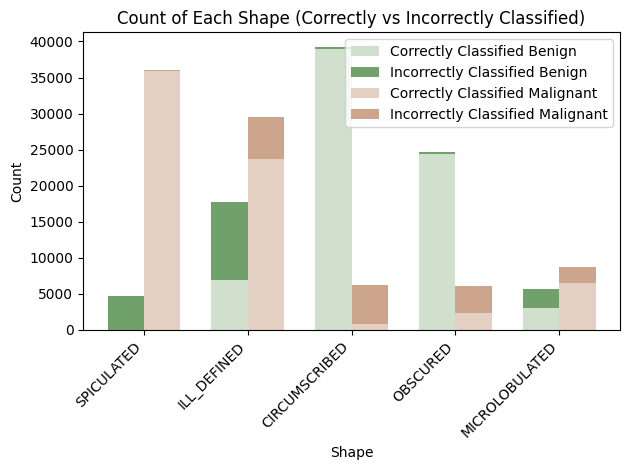

In [46]:
margins_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED']

# Filter data
malignant_mass_hit = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 1)]
benign_mass_hit = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 0)]
malignant_mass_miss = full_mass_results[(full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 0)]
benign_mass_miss = full_mass_results[(full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 1)]

# Aggregate counts for each shape
malignant_hit_sums = malignant_mass_hit[margins_of_interest].sum()
benign_hit_sums = benign_mass_hit[margins_of_interest].sum()
malignant_miss_sums = malignant_mass_miss[margins_of_interest].sum()
benign_miss_sums = benign_mass_miss[margins_of_interest].sum()

# Positions for bars
x = np.arange(len(margins_of_interest))
width = 0.35

fig, ax = plt.subplots()

# Plot bars for benign tumors
rects1 = ax.bar(x - width/2, benign_hit_sums, width, label='Correctly Classified Benign')#, color='#66b3ff')
rects2 = ax.bar(x - width/2, benign_miss_sums, width, bottom=benign_hit_sums, label='Incorrectly Classified Benign')#, color='#2D68C4')

# Plot bars for malignant tumors
rects3 = ax.bar(x + width/2, malignant_hit_sums, width, label='Correctly Classified Malignant')#, color='#ff9999')
rects4 = ax.bar(x + width/2, malignant_miss_sums, width, bottom=malignant_hit_sums, label='Incorrectly Classified Malignant')#, color='#DE3163')

# Set labels and title
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Shape (Correctly vs Incorrectly Classified)')
ax.set_xticks(x)
ax.set_xticklabels(margins_of_interest, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


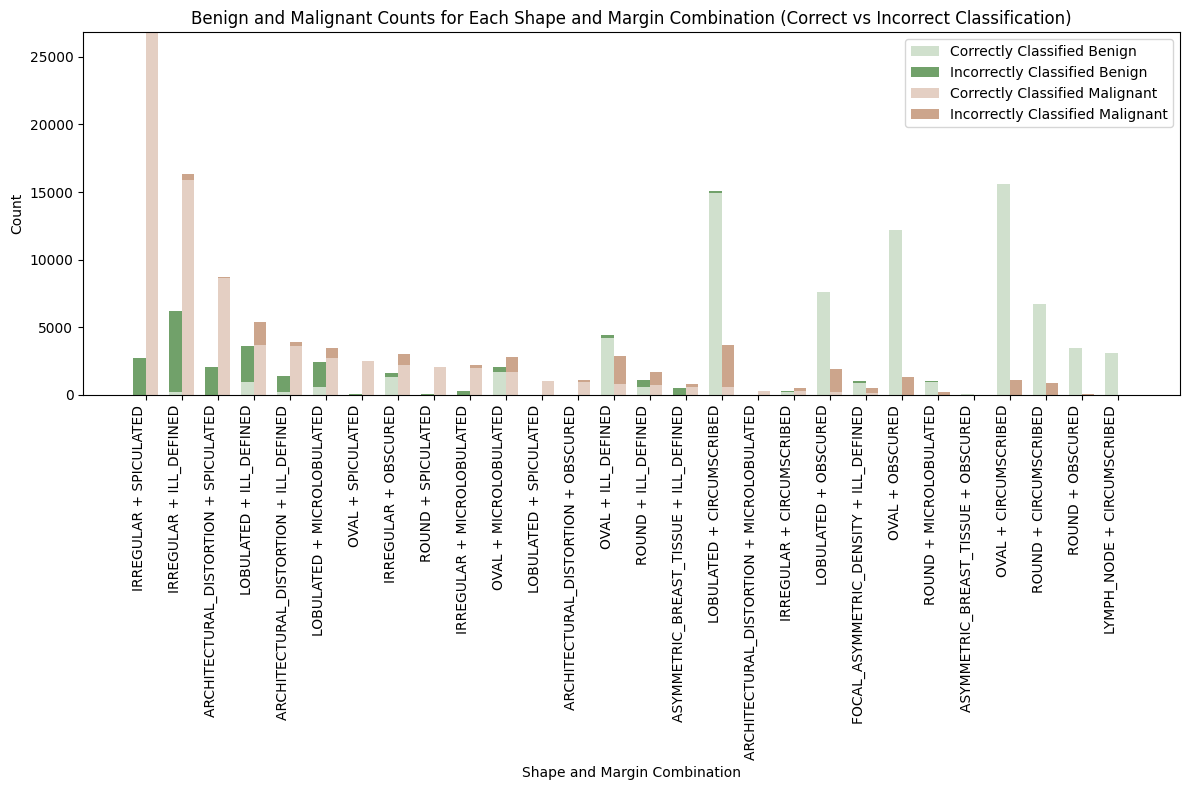

In [47]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE', 'ROUND']

margins_of_interest = ['SPICULATED', 'ILL_DEFINED', 'CIRCUMSCRIBED', 'OBSCURED', 'MICROLOBULATED']

combinations = []

# Loop through each shape and margin combination
for shape in shapes_of_interest:
    for margin in margins_of_interest:
        # Count the number of correct and incorrect benign and malignant cases for each combination
        malignant_correct = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 1)].shape[0]
        benign_correct = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 0)].shape[0]
        malignant_incorrect = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 1) & (full_mass_results['y_pred'] == 0)].shape[0]
        benign_incorrect = full_mass_results[(full_mass_results[shape] == 1) & (full_mass_results[margin] == 1) & (full_mass_results['malignant'] == 0) & (full_mass_results['y_pred'] == 1)].shape[0]

        # Append the result to the combinations list
        combinations.append({'shape': shape, 'margin': margin,
                             'malignant_correct': malignant_correct, 'benign_correct': benign_correct,
                             'malignant_incorrect': malignant_incorrect, 'benign_incorrect': benign_incorrect})

# Convert to DataFrame for easier manipulation
combinations_df = pd.DataFrame(combinations)

# Filter combinations that have more than 1 appearance (either malignant or benign)
combinations_df = combinations_df[
    (combinations_df['malignant_correct'] + combinations_df['malignant_incorrect'] +
     combinations_df['benign_correct'] + combinations_df['benign_incorrect']) > 1
]

# Sort the DataFrame by malignant correct count in descending order
combinations_df = combinations_df.sort_values(by='malignant_correct', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Convert x to list for calculations
x = list(range(len(combinations_df)))
width = 0.35

# Plot bars for benign tumors
rects1 = ax.bar([i - width/2 for i in x], combinations_df['benign_correct'], width, label='Correctly Classified Benign')#, color='#66b3ff')
rects2 = ax.bar([i - width/2 for i in x], combinations_df['benign_incorrect'], width, bottom=combinations_df['benign_correct'], label='Incorrectly Classified Benign')#, color='#2D68C4')

# Plot bars for malignant tumors
rects3 = ax.bar([i + width/2 for i in x], combinations_df['malignant_correct'], width, label='Correctly Classified Malignant')#, color='#ff9999')
rects4 = ax.bar([i + width/2 for i in x], combinations_df['malignant_incorrect'], width, bottom=combinations_df['malignant_correct'], label='Incorrectly Classified Malignant')#, color='#DE3163')

# Set labels and title
ax.set_xlabel('Shape and Margin Combination')
ax.set_ylabel('Count')
ax.set_title('Benign and Malignant Counts for Each Shape and Margin Combination (Correct vs Incorrect Classification)')
ax.set_xticks(x)
ax.set_xticklabels(combinations_df.apply(lambda row: f"{row['shape']} + {row['margin']}", axis=1), rotation=90, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [48]:
combinations_df['Accuracy'] = (combinations_df['malignant_correct'] + combinations_df['benign_correct']) / (combinations_df['malignant_correct'] + combinations_df['benign_correct']+ combinations_df['malignant_incorrect'] + combinations_df['benign_incorrect'])
combinations_df.sort_values(by='Accuracy', ascending=False)

shape          margin  malignant_correct  \
17                LYMPH_NODE   CIRCUMSCRIBED                  0   
33  ASYMMETRIC_BREAST_TISSUE        OBSCURED                  0   
9   ARCHITECTURAL_DISTORTION  MICROLOBULATED                300   
20                 LOBULATED      SPICULATED               1000   
38                     ROUND        OBSCURED                  0   
10                      OVAL      SPICULATED               2495   
35                     ROUND      SPICULATED               2100   
12                      OVAL   CIRCUMSCRIBED                  0   
0                  IRREGULAR      SPICULATED              26800   
13                      OVAL        OBSCURED                  3   
37                     ROUND   CIRCUMSCRIBED                  0   
8   ARCHITECTURAL_DISTORTION        OBSCURED                947   
23                 LOBULATED        OBSCURED                251   
22                 LOBULATED   CIRCUMSCRIBED                568   
4                  IRREGULAR  MICROLOBULATED               2025   
5   ARCHITECTURAL_DISTORTION      SPICULATED               8631   
39                     ROUND  MICROLOBULATED                  2   
3                  IRREGULAR        OBSCURED               2182   
26  FOCAL_ASYMMETRIC_DENSITY     ILL_DEFINED                172   
6   ARCHITECTURAL_DISTORTION     ILL_DEFINED               3650   
1                  IRREGULAR     ILL_DEFINED              15862   
14                      OVAL  MICROLOBULATED               1730   
11                      OVAL     ILL_DEFINED                828   
2                  IRREGULAR   CIRCUMSCRIBED                284   
24                 LOBULATED  MICROLOBULATED               2721   
21                 LOBULATED     ILL_DEFINED               3700   
36                     ROUND     ILL_DEFINED                713   
31  ASYMMETRIC_BREAST_TISSUE     ILL_DEFINED                569   

    benign_correct  malignant_incorrect  benign_incorrect  Accuracy  
17            3100                    0                 0  1.000000  
33             100                    0                 0  1.000000  
9                0                    0                 0  1.000000  
20               0                    0                 0  1.000000  
38            3500                  100                 0  0.972222  
10               0                    5               100  0.959615  
35               0                    0               100  0.954545  
12           15599                 1100                 1  0.934072  
0                0                    0              2700  0.908475  
13           12199                 1297                 1  0.903852  
37            6689                  900                11  0.880132  
8                0                  153                 0  0.860909  
23            7600                 1649                 0  0.826421  
22           14922                 3132               178  0.823936  
4                0                  175               300  0.810000  
5                5                   69              2095  0.799630  
39             943                  198                57  0.787500  
3             1338                  818               262  0.765217  
26             918                  328                82  0.726667  
6              191                  250              1209  0.724717  
1              214                  438              5986  0.714489  
14            1673                 1070               427  0.694490  
11            4180                 2072               220  0.686027  
2              196                  216               104  0.600000  
24             554                  779              1846  0.555085  
21             995                 1700              2605  0.521667  
36             586                  987               514  0.463929  
31              19                  231               481  0.452308

Summary of what the model troubles classifying:

The following shapes:
* Irregular
* Lobulated

The following margins:
* Almost all shapes

The following combinations:
* Irregular + Spiculated
* Irregular + Ill defined
* Lobulated + Ill defined
* Lobulated + Circumscribe



Since we understand that most of the data misclassified is due to shapes, we would like to cluster the data to understand what it looks like

In [49]:
full_mass_results.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'assessment', 'pathology',
       'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'y_pred', 'y_prob',
       'fold_number', 'file_number'],
      dtype='object')

In [50]:
main_features_df = full_mass_results[['breast_density', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'y_pred', 'tumor_id']]
main_features_df

breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
0                    3              0.0                         1   
1                    3              0.0                         1   
2                    3              0.0                         1   
3                    3              0.0                         1   
4                    3              0.0                         1   
...                ...              ...                       ...   
169595               3              0.0                         0   
169596               3              0.0                         0   
169597               3              0.0                         0   
169598               3              0.0                         0   
169599               3              0.0                         0   

        ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  \
0                              0                         0          1   
1                              0                         0          1   
2                              0                         0          1   
3                              0                         0          1   
4                              0                         0          1   
...                          ...                       ...        ...   
169595                         0                         0          1   
169596                         0                         0          1   
169597                         0                         0          1   
169598                         0                         0          1   
169599                         0                         0          1   

        LOBULATED  LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  \
0               0           0     0      0              0            0   
1               0           0     0      0              0            0   
2               0           0     0      0              0            0   
3               0           0     0      0              0            0   
4               0           0     0      0              0            0   
...           ...         ...   ...    ...            ...          ...   
169595          0           0     0      0              0            0   
169596          0           0     0      0              0            0   
169597          0           0     0      0              0            0   
169598          0           0     0      0              0            0   
169599          0           0     0      0              0            0   

        MICROLOBULATED  OBSCURED  SPICULATED  malignant  y_pred  tumor_id  
0                    0         0           1          1       1         1  
1                    0         0           1          1       1         1  
2                    0         0           1          1       1         1  
3                    0         0           1          1       1         1  
4                    0         0           1          1       1         1  
...                ...       ...         ...        ...     ...       ...  
169595               0         0           1          1       1      1696  
169596               0         0           1          1       1      1696  
169597               0         0           1          1       1      1696  
169598               0         0           1          1       1      1696  
169599               0         0           1          1       1      1696  

[169600 rows x 18 columns]

In [51]:
columns_to_groupby = ['breast_density', 'multiple_tumors', 'ARCHITECTURAL_DISTORTION',
                      'ASYMMETRIC_BREAST_TISSUE', 'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR',
                      'LOBULATED', 'LYMPH_NODE', 'OVAL', 'ROUND', 'CIRCUMSCRIBED',
                      'ILL_DEFINED', 'MICROLOBULATED', 'OBSCURED', 'SPICULATED',
                      'malignant', 'y_pred']

grouped_main_features_df = main_features_df.groupby(columns_to_groupby).agg(
    count=('tumor_id', 'size'),  # Count the number of rows in each group
    tumor_ids=('tumor_id', lambda x: list(set(x)))  # Aggregate all tumor_ids into a list
).reset_index()

#grouped_main_features_df


In [52]:
from collections import Counter

columns_to_groupby = ['breast_density', 'multiple_tumors', 'ARCHITECTURAL_DISTORTION',
                      'ASYMMETRIC_BREAST_TISSUE', 'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR',
                      'LOBULATED', 'LYMPH_NODE', 'OVAL', 'ROUND', 'CIRCUMSCRIBED',
                      'ILL_DEFINED', 'MICROLOBULATED', 'OBSCURED', 'SPICULATED']

grouped_main_features_df = main_features_df.groupby(columns_to_groupby).agg(
    malignant_tumor_ids=('tumor_id', lambda x: list(set(x[main_features_df.loc[x.index, 'malignant'] == 1]))),  # tumor_ids where malignant == 1
    benign_tumor_ids=('tumor_id', lambda x: list(set(x[main_features_df.loc[x.index, 'malignant'] == 0]))),  # tumor_ids where malignant == 0
    correct_tumor_ids=('tumor_id', lambda x: dict(Counter(x[main_features_df.loc[x.index, 'malignant'] == main_features_df.loc[x.index, 'y_pred']]))),  # tumor_id: count for correctly classified
    incorrect_tumor_ids=('tumor_id', lambda x: dict(Counter(x[main_features_df.loc[x.index, 'malignant'] != main_features_df.loc[x.index, 'y_pred']])))  # tumor_id: count for incorrectly classified
).reset_index()

grouped_main_features_df['feature_combination'] = grouped_main_features_df[columns_to_groupby].astype(str).agg('-'.join, axis=1)


grouped_main_features_df


breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
0                 1              0.0                         0   
1                 1              0.0                         0   
2                 1              0.0                         0   
3                 1              0.0                         0   
4                 1              0.0                         0   
..              ...              ...                       ...   
209               4              1.0                         0   
210               4              1.0                         0   
211               4              1.0                         0   
212               4              1.0                         0   
213               4              1.0                         0   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
0                           0                         0          0          0   
1                           0                         0          0          0   
2                           0                         0          0          0   
3                           0                         0          0          0   
4                           0                         0          0          0   
..                        ...                       ...        ...        ...   
209                         0                         0          0          0   
210                         0                         0          0          0   
211                         0                         0          0          1   
212                         0                         0          0          1   
213                         0                         0          1          0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      1              0            0               0   
1             0     0      1              0            0               0   
2             0     0      1              0            0               1   
3             0     0      1              0            1               0   
4             0     0      1              1            0               0   
..          ...   ...    ...            ...          ...             ...   
209           0     1      0              0            0               0   
210           0     1      0              1            0               0   
211           0     0      0              0            0               0   
212           0     0      0              1            0               0   
213           0     0      0              0            0               0   

     OBSCURED  SPICULATED malignant_tumor_ids    benign_tumor_ids  \
0           0           1          [961, 988]                  []   
1           1           0                  []          [388, 389]   
2           0           0              [1281]               [397]   
3           0           0        [1276, 1495]                  []   
4           0           0                  []  [1185, 1548, 1670]   
..        ...         ...                 ...                 ...   
209         1           0                  []         [1600, 439]   
210         0           0                  []               [441]   
211         1           0                  []               [440]   
212         0           0                  []               [438]   
213         0           1          [468, 469]                  []   

                     correct_tumor_ids   incorrect_tumor_ids  \
0                 {961: 100, 988: 100}                    {}   
1                 {388: 100, 389: 100}                    {}   
2                   {397: 51, 1281: 2}   {397: 49, 1281: 98}   
3                 {1276: 56, 1495: 62}  {1276: 44, 1495: 38}   
4    {1185: 100, 1548: 100, 1670: 100}                    {}   
..                                 ...                   ...   
209              {439: 100, 1600: 100}           

<ipython-input-53-c789c3df9258>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['feature_combination'] = filtered_df[columns_to_groupby].astype(str).agg('-'.join, axis=1)


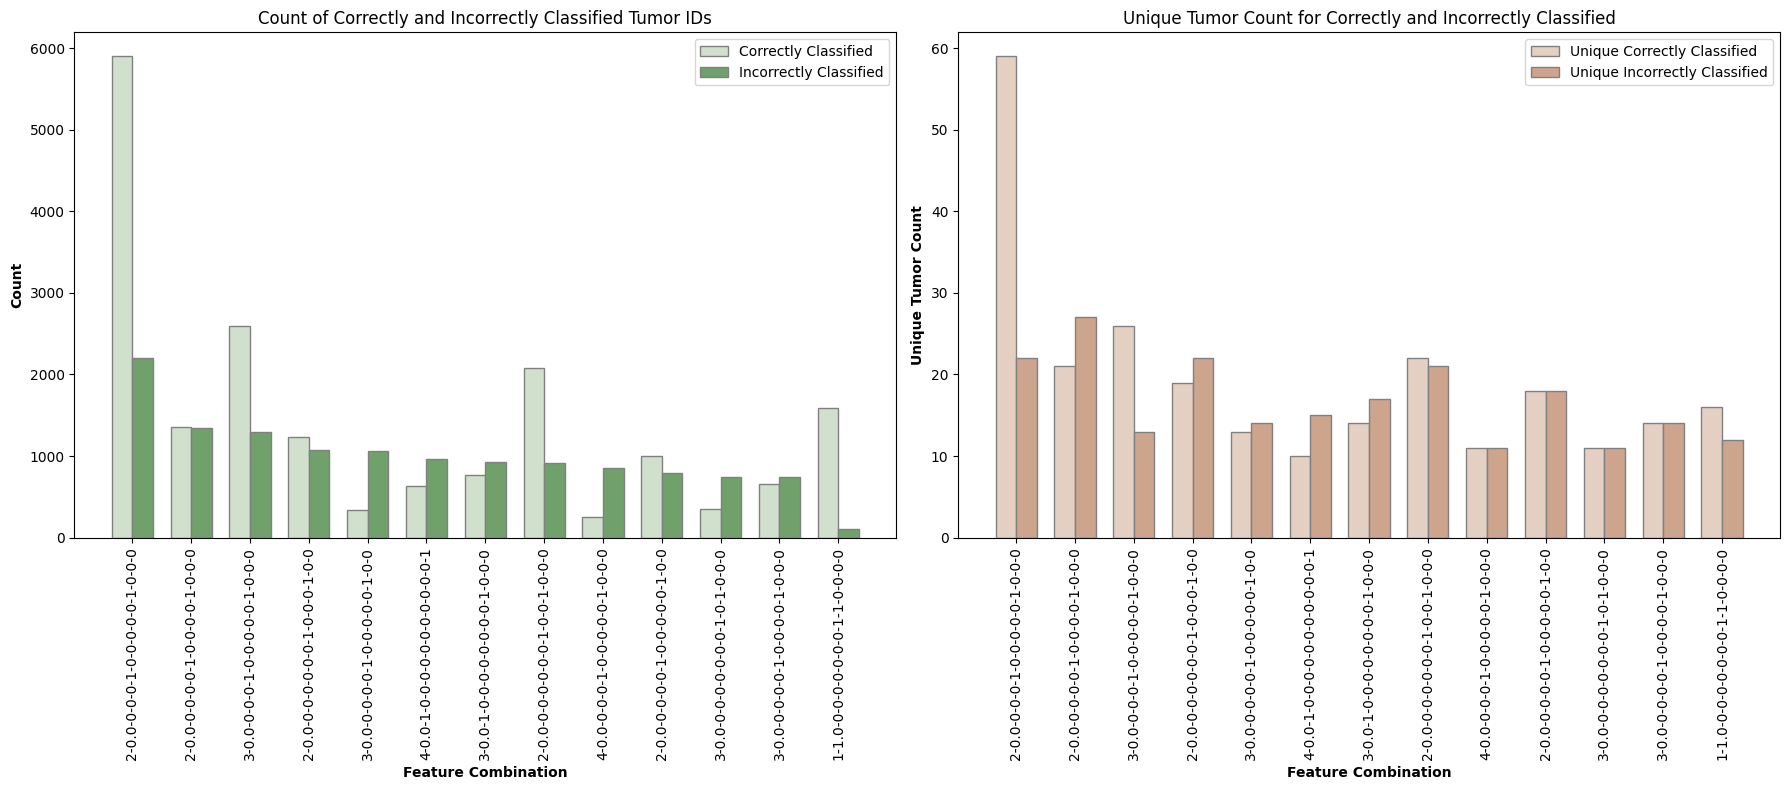

In [53]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Compute the sum of counts for incorrectly classified tumor_ids
grouped_main_features_df['incorrect_count_sum'] = grouped_main_features_df['incorrect_tumor_ids'].apply(lambda x: sum(Counter(x).values()))

# Compute the sum of counts for correctly classified tumor_ids
grouped_main_features_df['correct_count_sum'] = grouped_main_features_df['correct_tumor_ids'].apply(lambda x: sum(Counter(x).values()))

# Compute the number of unique incorrectly classified tumor_ids
grouped_main_features_df['unique_incorrect_count'] = grouped_main_features_df['incorrect_tumor_ids'].apply(lambda x: len(Counter(x)))

# Compute the number of unique correctly classified tumor_ids
grouped_main_features_df['unique_correct_count'] = grouped_main_features_df['correct_tumor_ids'].apply(lambda x: len(Counter(x)))

# Filter the DataFrame to include only rows where the sum of incorrect counts is greater than 200
filtered_df = grouped_main_features_df[grouped_main_features_df['unique_incorrect_count'] > 10]

# Create a new column that combines all the groupby columns into a single string for better visualization
filtered_df['feature_combination'] = filtered_df[columns_to_groupby].astype(str).agg('-'.join, axis=1)
filtered_df = filtered_df.sort_values(by='incorrect_count_sum', ascending=False)


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Bar width
bar_width = 0.35

# Positions of bars on x-axis
r1 = range(len(filtered_df))
r2 = [x + bar_width for x in r1]


# Plot bars for correctly classified and incorrectly classified tumor IDs
axs[0].bar(r1, filtered_df['correct_count_sum'], color='#D0E0CD', width=bar_width, edgecolor='grey', label='Correctly Classified')
axs[0].bar(r2, filtered_df['incorrect_count_sum'], color='#71a16a', width=bar_width, edgecolor='grey', label='Incorrectly Classified')
axs[0].set_xlabel('Feature Combination', fontweight='bold')
axs[0].set_ylabel('Count', fontweight='bold')
axs[0].set_title('Count of Correctly and Incorrectly Classified Tumor IDs')
axs[0].set_xticks([r + bar_width / 2 for r in r1])
axs[0].set_xticklabels(filtered_df['feature_combination'], rotation=90)
axs[0].legend()

# Plot bars for the number of unique correctly classified and incorrectly classified tumors
axs[1].bar(r1, filtered_df['unique_correct_count'], color='#e4cfc3', width=bar_width, edgecolor='grey', label='Unique Correctly Classified')
axs[1].bar(r2, filtered_df['unique_incorrect_count'], color='#CCA58c', width=bar_width, edgecolor='grey', label='Unique Incorrectly Classified')
axs[1].set_xlabel('Feature Combination', fontweight='bold')
axs[1].set_ylabel('Unique Tumor Count', fontweight='bold')
axs[1].set_title('Unique Tumor Count for Correctly and Incorrectly Classified')
axs[1].set_xticks([r + bar_width / 2 for r in r1])
axs[1].set_xticklabels(filtered_df['feature_combination'], rotation=90)
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [54]:
filtered_df[['feature_combination', 'correct_count_sum', 'incorrect_count_sum', 'unique_correct_count', 'unique_incorrect_count']]

feature_combination  correct_count_sum  incorrect_count_sum  \
81   2-0.0-0-0-0-1-0-0-0-0-0-1-0-0-0               5900                 2200   
66   2-0.0-0-0-0-0-1-0-0-0-0-1-0-0-0               1358                 1342   
150  3-0.0-0-0-0-1-0-0-0-0-0-1-0-0-0               2600                 1300   
54   2-0.0-0-0-0-0-0-0-1-0-0-0-1-0-0               1232                 1068   
140  3-0.0-0-0-0-0-1-0-0-0-0-0-1-0-0                341                 1059   
203  4-0.0-1-0-0-0-0-0-0-0-0-0-0-0-1                636                  964   
162  3-0.0-1-0-0-0-0-0-0-0-0-1-0-0-0                773                  927   
55   2-0.0-0-0-0-0-0-0-1-0-0-1-0-0-0               2082                  918   
197  4-0.0-0-0-0-1-0-0-0-0-0-1-0-0-0                248                  852   
65   2-0.0-0-0-0-0-1-0-0-0-0-0-1-0-0               1004                  796   
127  3-0.0-0-0-0-0-0-0-0-1-0-1-0-0-0                351                  749   
141  3-0.0-0-0-0-0-1-0-0-0-0-1-0-0-0                658                  742   
36   1-1.0-0-0-0-0-0-0-0-1-1-0-0-0-0               1589                  111   

     unique_correct_count  unique_incorrect_count  
81                     59                      22  
66                     21                      27  
150                    26                      13  
54                     19                      22  
140                    13                      14  
203                    10                      15  
162                    14                      17  
55                     22                      21  
197                    11                      11  
65                     18                      18  
127                    11                      11  
141                    14                      14  
36                     16                      12

In [55]:
incorrect_features = grouped_main_features_df[
    (grouped_main_features_df['unique_incorrect_count'] != 0) &
    (grouped_main_features_df['incorrect_count_sum'] > 50)]
incorrect_features

breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
2                 1              0.0                         0   
3                 1              0.0                         0   
6                 1              0.0                         0   
7                 1              0.0                         0   
8                 1              0.0                         0   
..              ...              ...                       ...   
202               4              0.0                         1   
203               4              0.0                         1   
205               4              0.0                         1   
206               4              0.0                         1   
208               4              0.0                         1   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
2                           0                         0          0          0   
3                           0                         0          0          0   
6                           0                         0          0          0   
7                           0                         0          0          0   
8                           0                         0          0          0   
..                        ...                       ...        ...        ...   
202                         0                         0          0          0   
203                         0                         0          0          0   
205                         0                         0          0          1   
206                         0                         0          1          0   
208                         0                         0          1          0   

     LYMPH_NODE  OVAL  ROUND  ...  SPICULATED  \
2             0     0      1  ...           0   
3             0     0      1  ...           0   
6             0     1      0  ...           0   
7             0     1      0  ...           0   
8             0     1      0  ...           0   
..          ...   ...    ...  ...         ...   
202           0     0      0  ...           0   
203           0     0      0  ...           1   
205           0     0      0  ...           0   
206           0     0      0  ...           1   
208           0     0      0  ...           0   

                         malignant_tumor_ids  \
2                                     [1281]   
3                               [1276, 1495]   
6                                   [43, 44]   
7           [1282, 268, 1103, 119, 120, 669]   
8                         [1250, 1251, 1231]   
..                                       ...   
202                                   [1259]   
203  [1289, 813, 398, 1553, 1492, 1493, 442]   
205                                    [754]   
206                                       []   
208                                    [131]   

                                      benign_tumor_ids  \
2                                                [397]   
3                                                   []   
6     [417, 418, 77, 78, 685, 686, 474, 475, 157, 158]   
7                                               [1119]   
8                                          [860, 1054]   
..                                                 ...   
202                                              [593]   
203  [992, 811, 812, 1681, 1682, 1395, 1396, 1619, ...   
205                                                 []   
206                                             [1687]   
208                                                 []   

                                     correct_tumor_ids  \
2                                   {397: 51, 1281: 2}   
3                                 {1276: 56, 1495: 62}   
6    {77: 100, 78: 100, 157: 100, 158: 100, 417: 10...   
7    {119: 100, 120: 100, 268: 100, 669: 100, 1103:...   
8                       {1231: 96, 1250: 70, 1251: 69}   
..                          

In [56]:
# Compute sizes of 'malignant_tumor_ids' and 'benign_tumor_ids'
incorrect_features['malignant_size'] = incorrect_features['malignant_tumor_ids'].apply(len)
incorrect_features['benign_size'] = incorrect_features['benign_tumor_ids'].apply(len)

# Further filter rows where either 'malignant_size' or 'benign_size' is 1
filtered_incorrect_features = incorrect_features[
    (incorrect_features['malignant_size'] == 1) | (incorrect_features['benign_size'] == 1)
]


# Print or use the filtered DataFrame
filtered_incorrect_features.drop(['malignant_size',	'benign_size'], axis=1)

<ipython-input-56-f75d9dc635a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_features['malignant_size'] = incorrect_features['malignant_tumor_ids'].apply(len)
<ipython-input-56-f75d9dc635a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_features['benign_size'] = incorrect_features['benign_tumor_ids'].apply(len)


breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
2                 1              0.0                         0   
7                 1              0.0                         0   
21                1              0.0                         0   
23                1              0.0                         0   
26                1              0.0                         0   
27                1              0.0                         0   
31                1              0.0                         1   
32                1              0.0                         1   
36                1              1.0                         0   
47                2              0.0                         0   
48                2              0.0                         0   
49                2              0.0                         0   
52                2              0.0                         0   
56                2              0.0                         0   
57                2              0.0                         0   
72                2              0.0                         0   
83                2              0.0                         0   
85                2              0.0                         0   
93                2              0.0                         0   
114               2              1.0                         0   
128               3              0.0                         0   
134               3              0.0                         0   
135               3              0.0                         0   
142               3              0.0                         0   
146               3              0.0                         0   
148               3              0.0                         0   
152               3              0.0                         0   
153               3              0.0                         0   
159               3              0.0                         0   
160               3              0.0                         1   
163               3              0.0                         1   
180               4              0.0                         0   
185               4              0.0                         0   
190               4              0.0                         0   
191               4              0.0                         0   
196               4              0.0                         0   
202               4              0.0                         1   
205               4              0.0                         1   
206               4              0.0                         1   
208               4              0.0                         1   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
2                           0                         0          0          0   
7                           0                         0          0          0   
21                          0                         0          1          0   
23                          0                         0          1          0   
26                          0                         0          1          1   
27                          0                         0          1          1   
31                          0                         0          0          0   
32                          0                         0          0          0   
36                          0                         0          0          0   
47                          0                         0          0          0   
48                          0                         0          0          0   
49                          0                         0          0          0   
52                          0                         0          0          0   
56                          0                         0          0          0   
57                          0                         0          0          0   
72

In [57]:
# Print all rows where there's one incorrect tumor_id classified
incorrect_features[incorrect_features['unique_incorrect_count'] == 1]

breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
7                 1              0.0                         0   
21                1              0.0                         0   
23                1              0.0                         0   
26                1              0.0                         0   
27                1              0.0                         0   
32                1              0.0                         1   
47                2              0.0                         0   
48                2              0.0                         0   
52                2              0.0                         0   
56                2              0.0                         0   
57                2              0.0                         0   
72                2              0.0                         0   
83                2              0.0                         0   
85                2              0.0                         0   
93                2              0.0                         0   
114               2              1.0                         0   
128               3              0.0                         0   
134               3              0.0                         0   
135               3              0.0                         0   
142               3              0.0                         0   
146               3              0.0                         0   
148               3              0.0                         0   
153               3              0.0                         0   
163               3              0.0                         1   
185               4              0.0                         0   
190               4              0.0                         0   
196               4              0.0                         0   
202               4              0.0                         1   
205               4              0.0                         1   
206               4              0.0                         1   
208               4              0.0                         1   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
7                           0                         0          0          0   
21                          0                         0          1          0   
23                          0                         0          1          0   
26                          0                         0          1          1   
27                          0                         0          1          1   
32                          0                         0          0          0   
47                          0                         0          0          0   
48                          0                         0          0          0   
52                          0                         0          0          0   
56                          0                         0          0          0   
57                          0                         0          0          0   
72                          0                         0          0          1   
83                          0                         0          1          0   
85                          0                         0          1          0   
93                          1                         0          1          0   
114                         0                         0          0          1   
128                         0                         0          0          0   
134                         0                         0          0          0   
135                         0                         0          0          0   
142                         0                         0          0          1   
146                         0                         0          0          1   
148                         0                         0          1          0   
153                         0

The table above groups the tumors according to the shapes, breast density and number of tumors per patient. Added 2 columns to see which of those tumors are benign and which are malignant. We've also added 2 columns showing how many times each of this found tumors are classified correct and incorrectly.

## Results VS Assessment

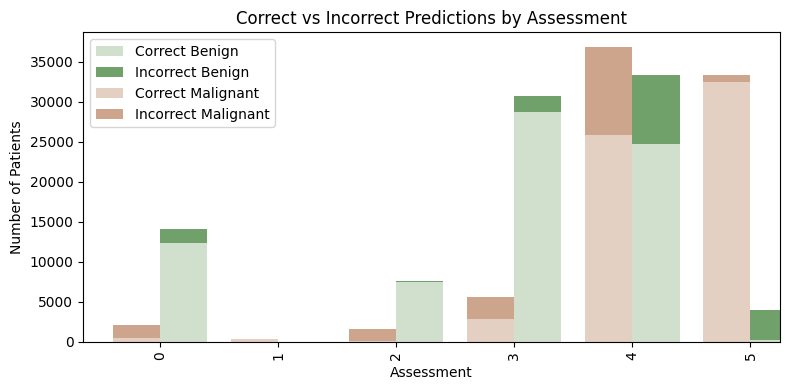

In [58]:
# Calculate correct and incorrect predictions
correct_benign = full_mass_results[(full_mass_results['y_pred'] == 0) & (full_mass_results['pathology'] == 'BENIGN')]['assessment'].value_counts()
incorrect_benign = full_mass_results[(full_mass_results['y_pred'] == 0) & (full_mass_results['pathology'] == 'MALIGNANT')]['assessment'].value_counts()

correct_malignant = full_mass_results[(full_mass_results['y_pred'] == 1) & (full_mass_results['pathology'] == 'MALIGNANT')]['assessment'].value_counts()
incorrect_malignant = full_mass_results[(full_mass_results['y_pred'] == 1) & (full_mass_results['pathology'] == 'BENIGN')]['assessment'].value_counts()

# Combine the counts into a DataFrame for plotting
prediction_counts = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)

fig, ax = plt.subplots(figsize=(8, 4))

prediction_counts[['Correct Benign', 'Incorrect Benign']].plot(kind='bar', ax=ax, color=['#D0E0CD', '#71a16a'], stacked=True, position=0, width=0.4, align='center', label='Benign')
prediction_counts[['Correct Malignant', 'Incorrect Malignant']].plot(kind='bar', ax=ax, color=['#e4cfc3', '#CCA58c'], stacked=True, position=1, width=0.4, align='center', label='Malignant')

ax.set_xlabel('Assessment')
ax.set_ylabel('Number of Patients')
ax.set_title('Correct vs Incorrect Predictions by Assessment')
ax.legend()

plt.tight_layout()
plt.show()


In [59]:
counts_df = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)


counts_df['Benign Accuracy'] = counts_df['Correct Benign'] / (counts_df['Correct Benign'] + counts_df['Incorrect Benign'])
counts_df['Malignant Accuracy'] = counts_df['Correct Malignant'] / (counts_df['Correct Malignant'] + counts_df['Incorrect Malignant'])
counts_df.fillna(0, inplace=True)

counts_df

Correct Benign  Incorrect Benign  Correct Malignant  \
assessment                                                        
0                  12387.0            1682.0                518   
1                      0.0               0.0                300   
2                   7510.0              31.0                 69   
3                  28748.0            1997.0               2903   
4                  24665.0            8716.0              25884   
5                    200.0            3817.0              32483   

            Incorrect Malignant  Benign Accuracy  Malignant Accuracy  
assessment                                                            
0                        1613.0         0.880446            0.243078  
1                           0.0         0.000000            1.000000  
2                        1490.0         0.995889            0.044259  
3                        2752.0         0.935046            0.513351  
4                       10935.0         0.738893            0.703007  
5                         900.0         0.049788            0.973040

**Understand the results:**

Assessment 0 : predicted benign - 88.04% of the time correct

Assessment 1 : predicted malignant - 100% of the time correct

Assessment 2 : predicted benign - 99.58% of the time correct

Assessment 3 : predicted benign - 93.50% of the time correct

Assessment 4 : predictions are correct with about 70 - 73.89% accuracy

Assessment 5 : predicted malignant - 97.30% of the time correct



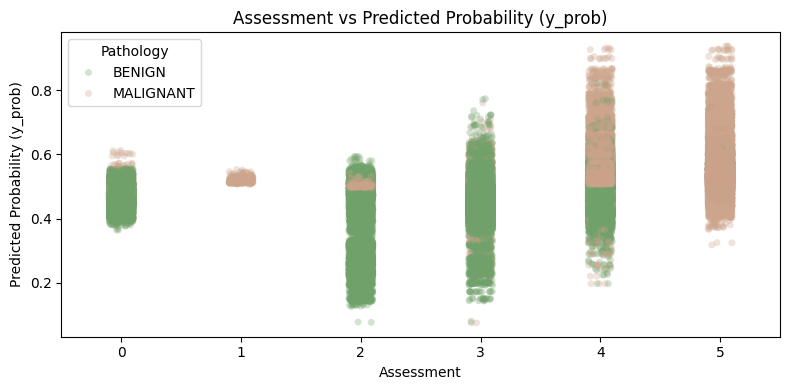

In [60]:
plt.figure(figsize=(8, 4))

# Plot y_prob against assessment, with different colors for malignant and benign
sns.stripplot(data=full_mass_results, x='assessment', y='y_prob', jitter=True, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, alpha=0.3)

plt.xlabel('Assessment')
plt.ylabel('Predicted Probability (y_prob)')
plt.title('Assessment vs Predicted Probability (y_prob)')
plt.legend(title='Pathology')

plt.tight_layout()
plt.show()


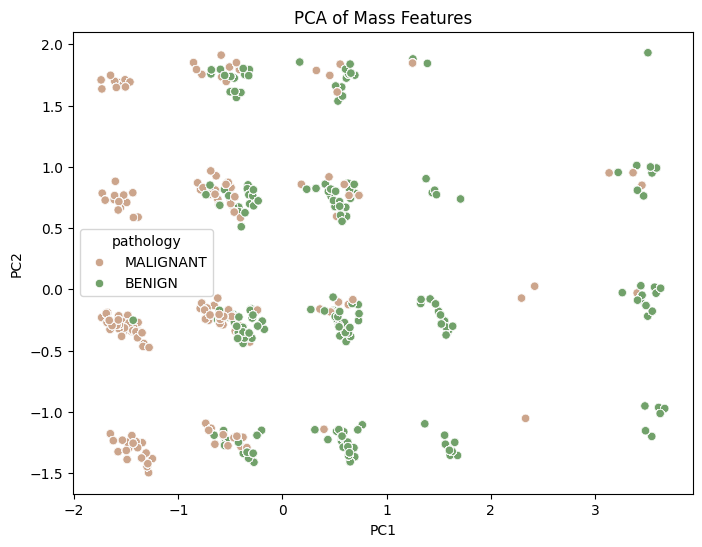

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the feature data in X (excluding 'y_prob' and categorical variables)
# Drop the specified columns from the DataFrame
X = full_mass_results.drop(columns=['patient_id', 'image view', 'abnormality id', 'abnormality type', 'pathology',
                                    'subtlety', 'image file path', 'cropped image file path',
                                    'ROI mask file path', 'tumor_id', 'malignant', 'y_pred', 'y_prob',
                                    'fold_number', 'file_number','left or right breast'])

# Perform PCA, reducing to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with PCA components and the pathology
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['pathology'] = full_mass_results['pathology']

# Plot the PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='pathology', data=pca_df, palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'})
plt.title('PCA of Mass Features')
plt.show()

In [62]:
component_loadings = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
component_loadings


breast_density  assessment  multiple_tumors  ARCHITECTURAL_DISTORTION  \
PC1       -0.039135   -0.967853         0.007502                 -0.028529   
PC2        0.981612   -0.044517        -0.073768                  0.056747   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
PC1                  0.000705                  0.002053  -0.119279   0.027147   
PC2                 -0.003540                  0.003100   0.019007  -0.042444   

     LYMPH_NODE      OVAL     ROUND  CIRCUMSCRIBED  ILL_DEFINED  \
PC1    0.019333  0.070879  0.012293       0.045806    -0.051827   
PC2   -0.033511 -0.001681  0.006961      -0.090127     0.040376   

     MICROLOBULATED  OBSCURED  SPICULATED  
PC1       -0.014265  0.126376   -0.139220  
PC2       -0.043843  0.097110    0.036473

<Figure size 800x400 with 0 Axes>

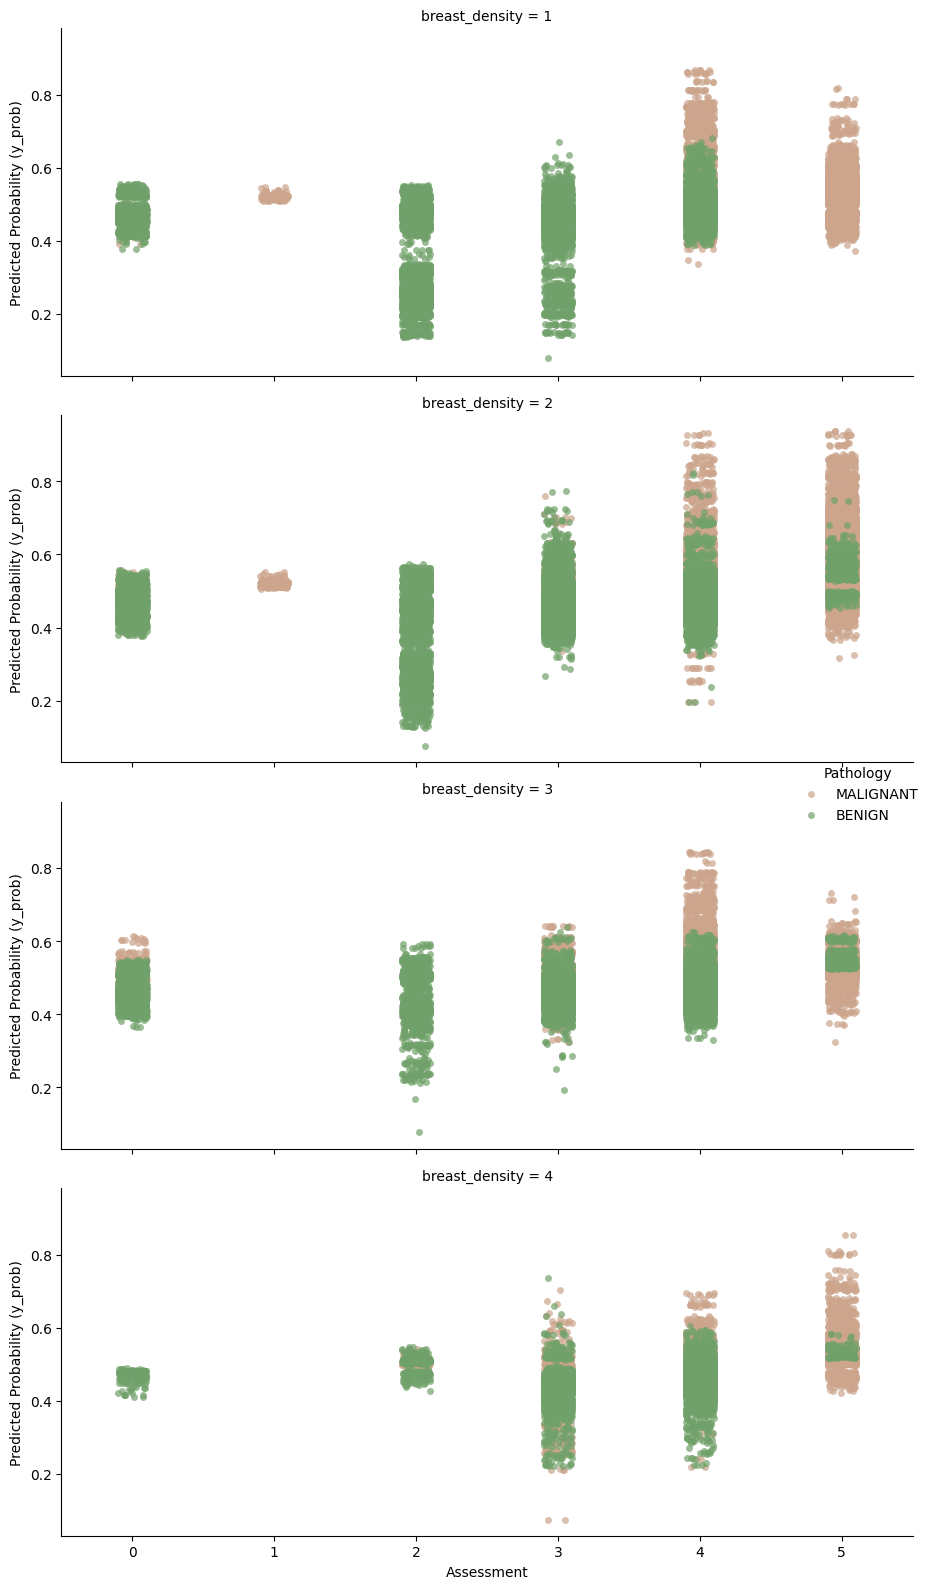

In [63]:
plt.figure(figsize=(8, 4))
g = sns.FacetGrid(full_mass_results, row='breast_density', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'})
#g = sns.FacetGrid(full_mass_results, row='breast_density', col='pathology', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': 'red', 'BENIGN': 'blue'})
assessment_order = sorted(full_mass_results['assessment'].unique())

# Map the stripplot onto the grid
g.map(sns.stripplot, 'assessment', 'y_prob', jitter=True, alpha=0.7, order=assessment_order)

# Add a legend and adjust layout
g.add_legend(title='Pathology')
g.set_axis_labels('Assessment', 'Predicted Probability (y_prob)')
plt.tight_layout()
plt.show()


<Figure size 800x400 with 0 Axes>

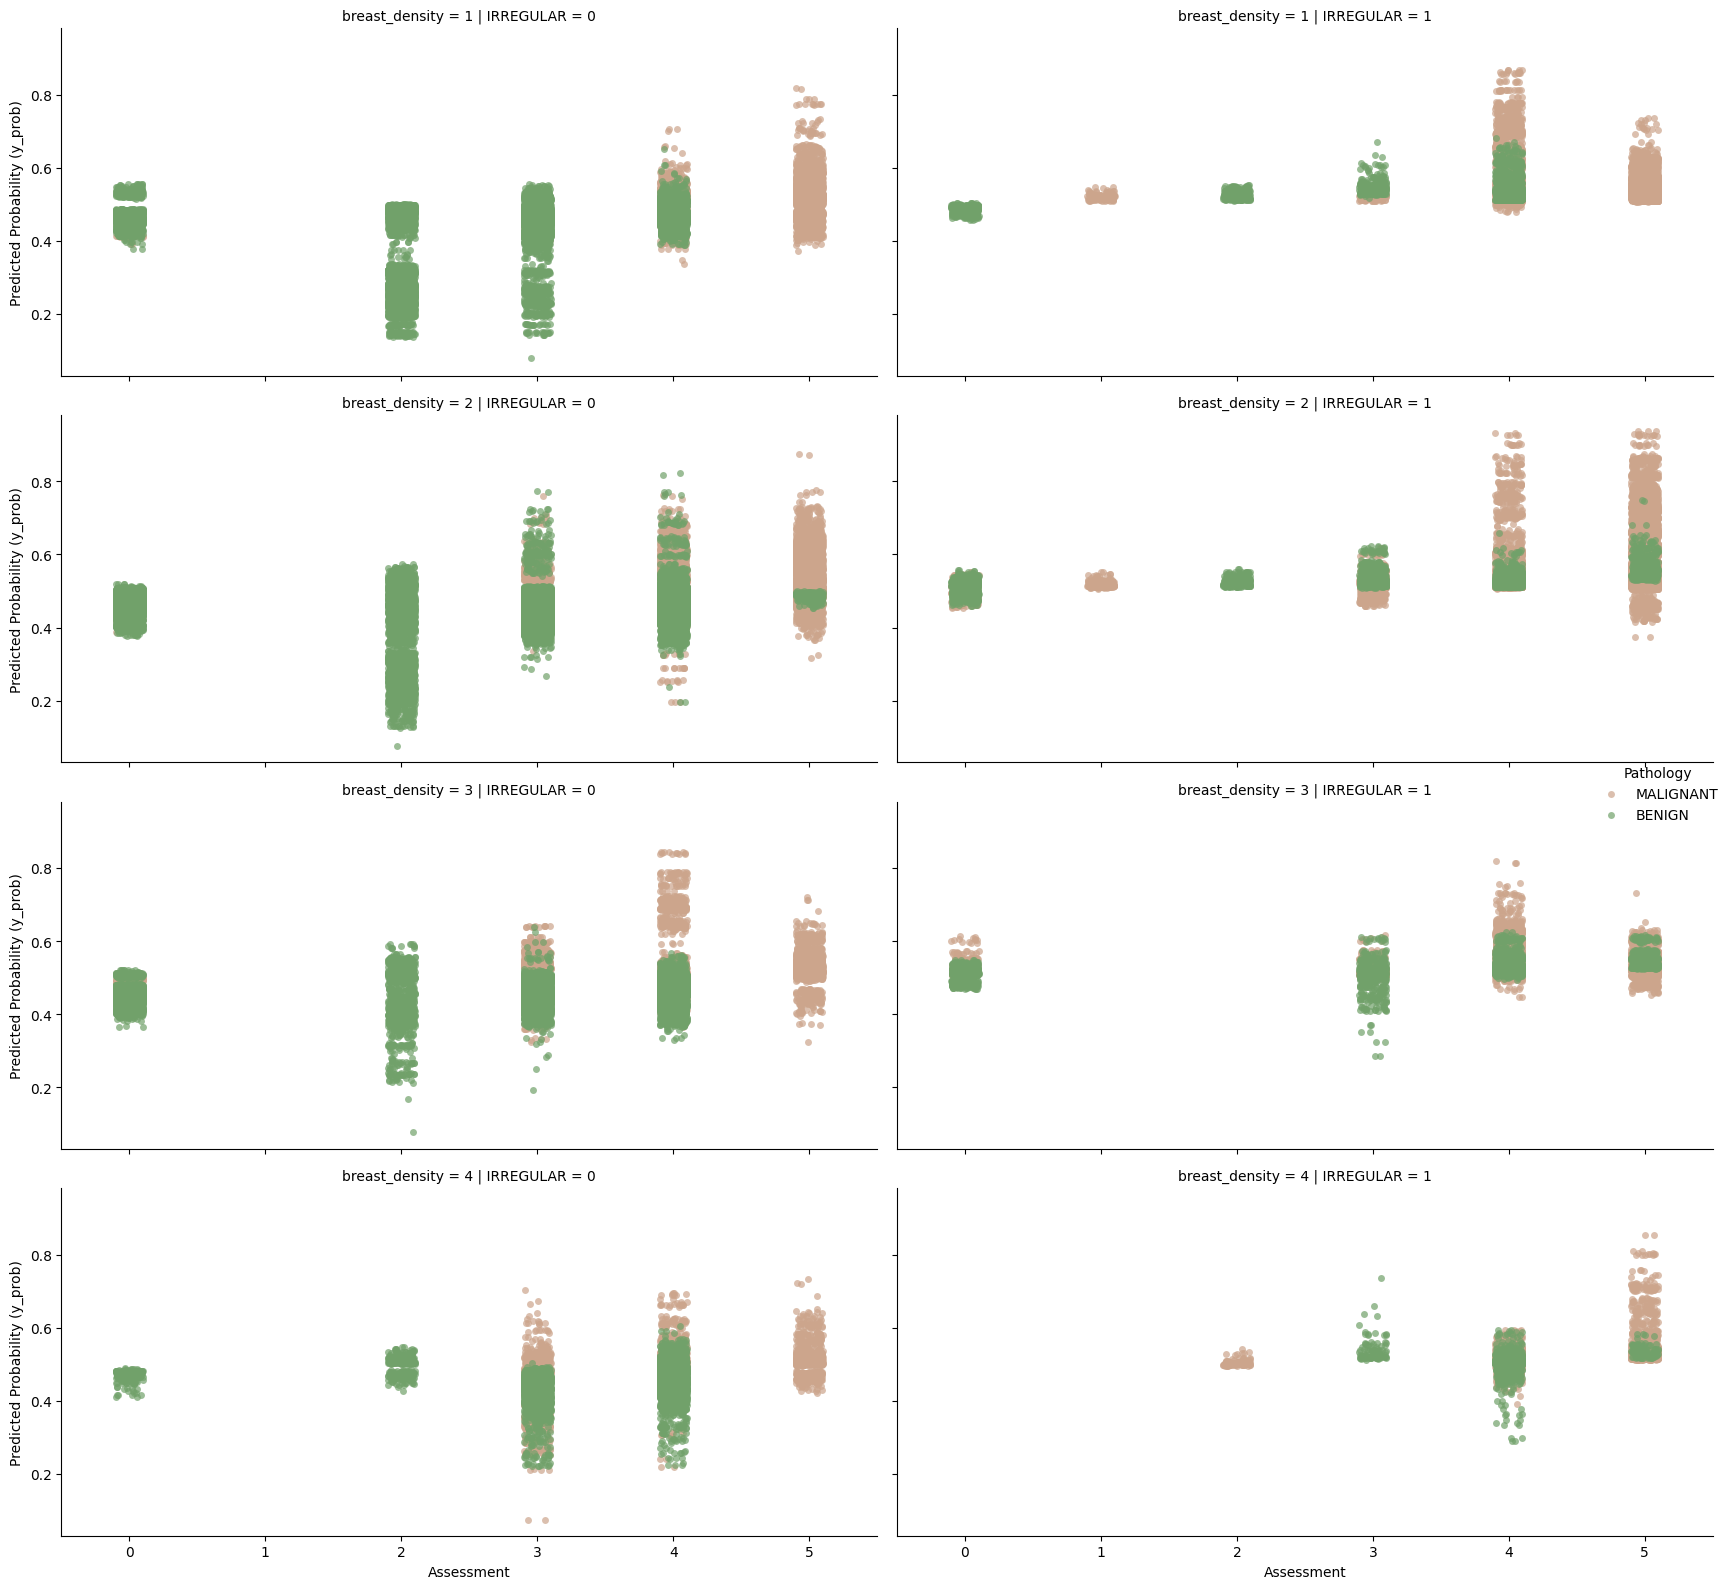

In [64]:
plt.figure(figsize=(8, 4))
g = sns.FacetGrid(full_mass_results, row='breast_density', col='IRREGULAR', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'})

# Map the stripplot onto the grid
g.map(sns.stripplot, 'assessment', 'y_prob', jitter=True, alpha=0.7, order=assessment_order)

# Add a legend and adjust layout
g.add_legend(title='Pathology')
g.set_axis_labels('Assessment', 'Predicted Probability (y_prob)')
plt.tight_layout()
plt.show()


<Figure size 800x400 with 0 Axes>

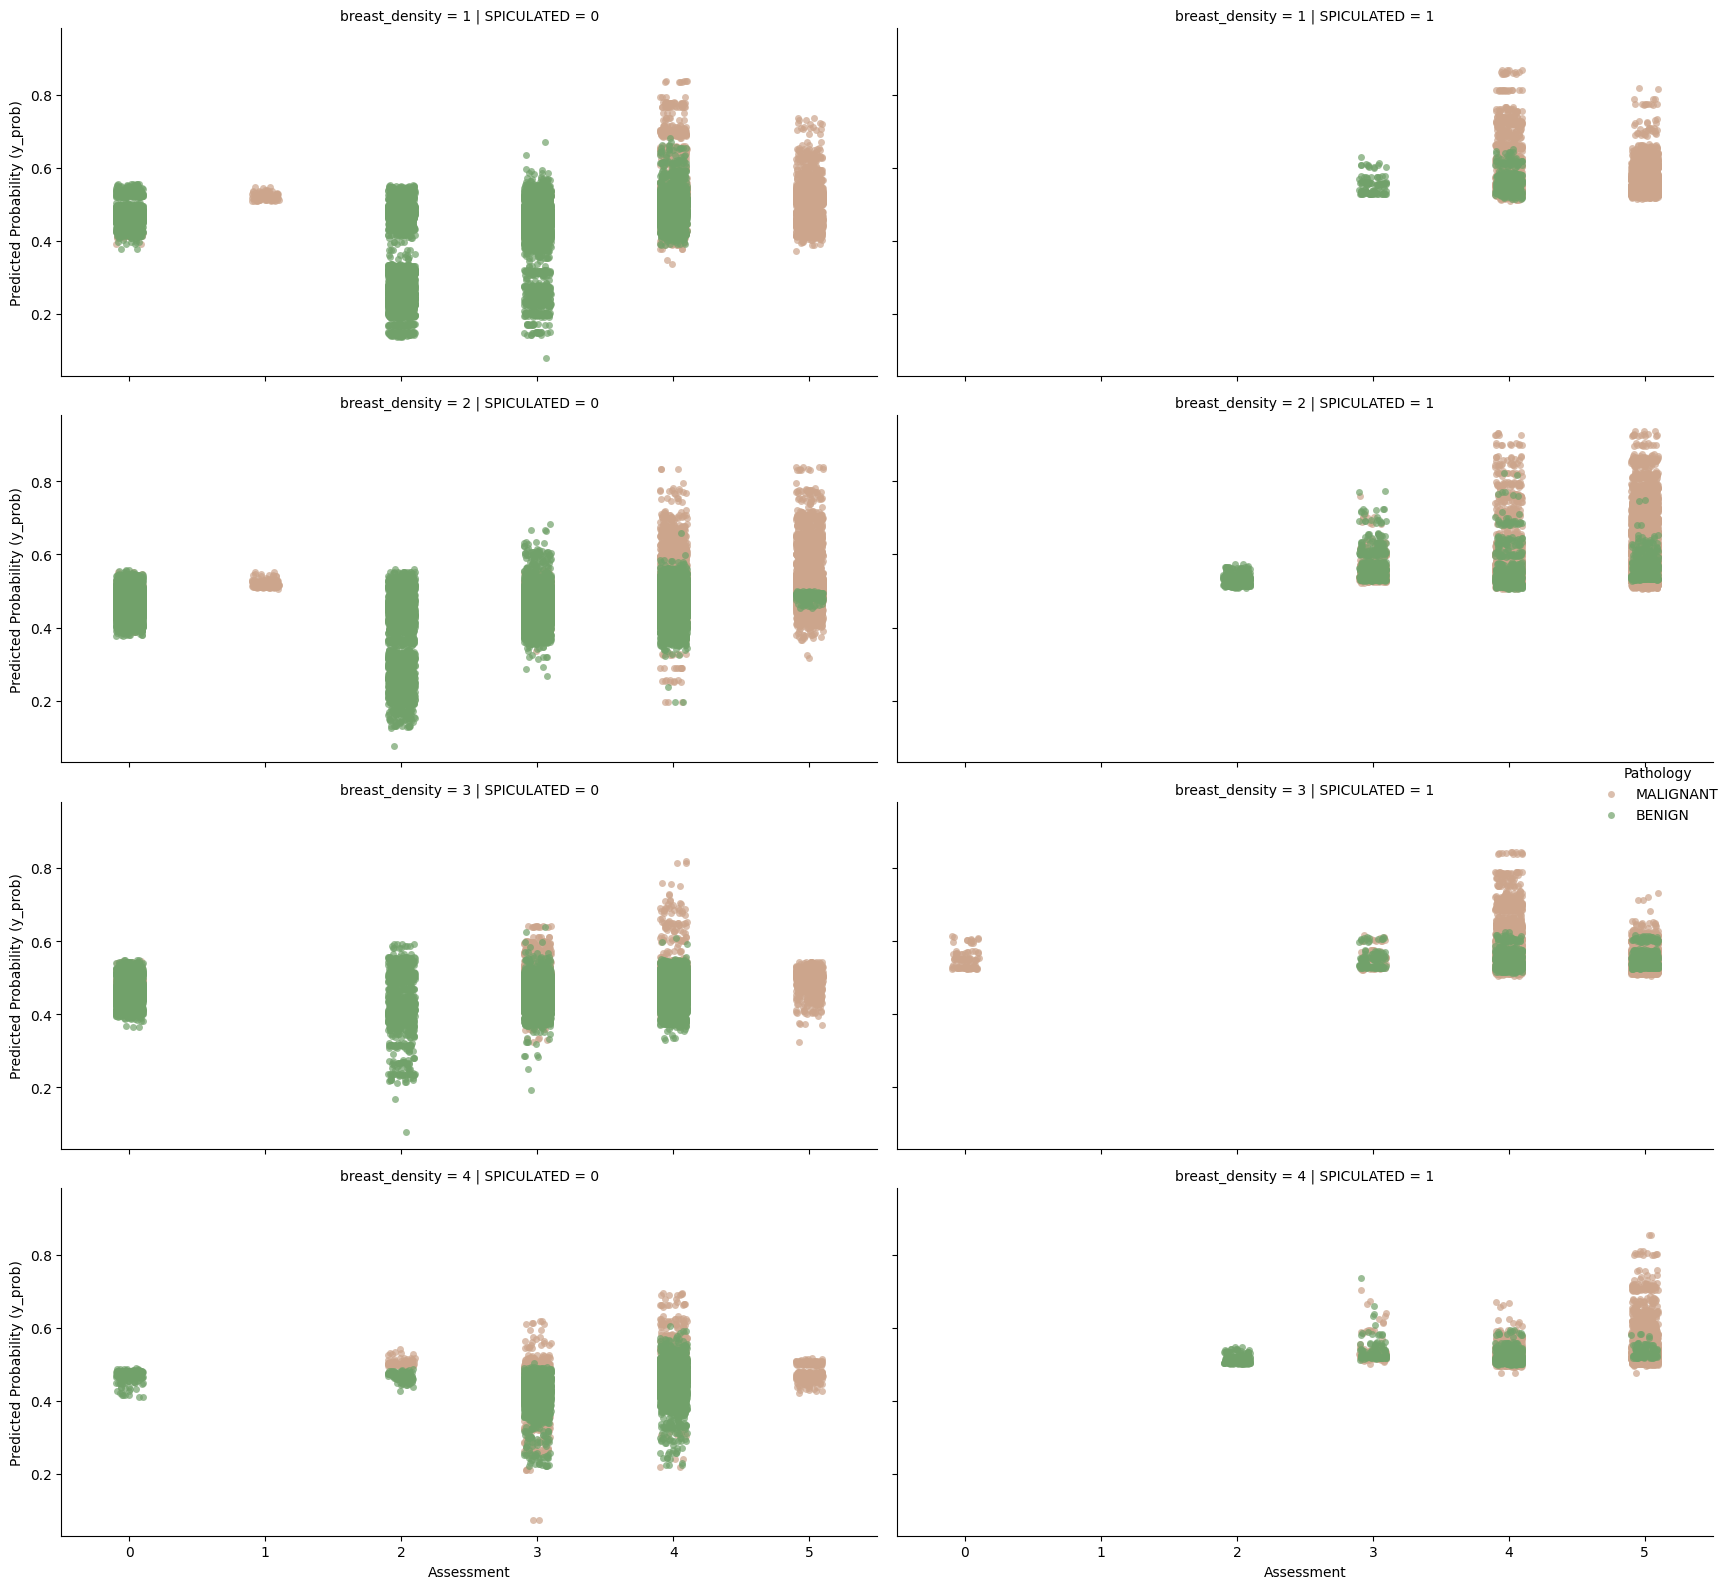

In [65]:
plt.figure(figsize=(8, 4))
g = sns.FacetGrid(full_mass_results, row='breast_density', col='SPICULATED', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'})

# Map the stripplot onto the grid
g.map(sns.stripplot, 'assessment', 'y_prob', jitter=True, alpha=0.7, order=assessment_order)

# Add a legend and adjust layout
g.add_legend(title='Pathology')
g.set_axis_labels('Assessment', 'Predicted Probability (y_prob)')
plt.tight_layout()
plt.show()


In [66]:
# Calculate the average y_prob per assessment
avg_y_prob_per_assessment = full_mass_results.groupby('assessment')['y_prob'].mean()

print("Average y_prob per assessment:")
print(avg_y_prob_per_assessment)


Average y_prob per assessment:
assessment
0    0.467751
1    0.520581
2    0.377032
3    0.459711
4    0.501901
5    0.547515
Name: y_prob, dtype: float64


### Assessment NO.4

In [67]:
four_df =  full_mass_results[full_mass_results["assessment"] ==4]

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 800x400 with 0 Axes>

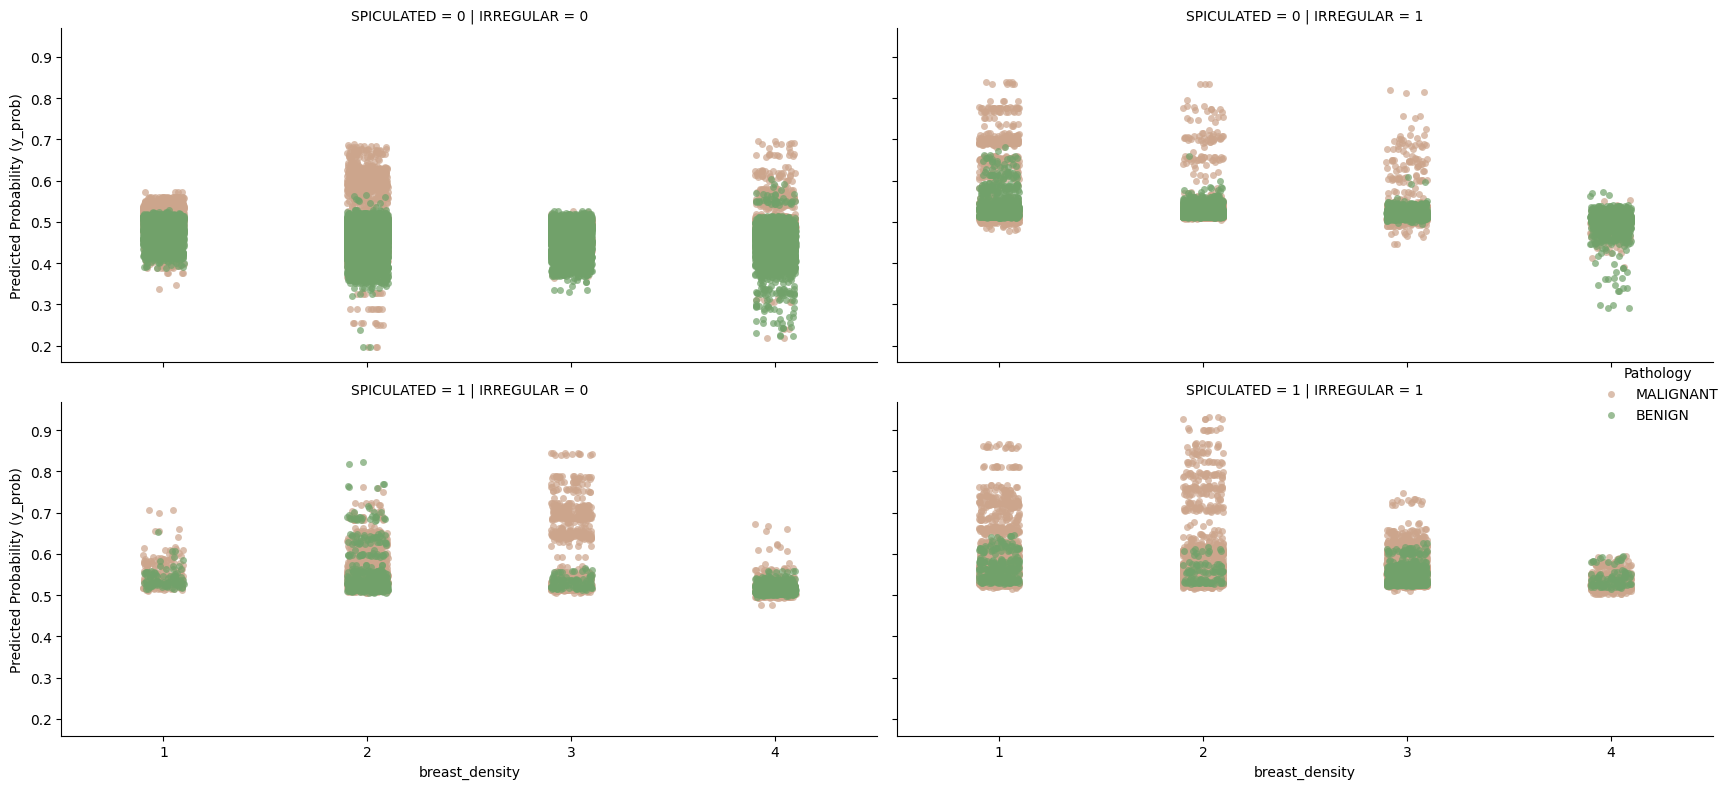

In [68]:
plt.figure(figsize=(8, 4))
g = sns.FacetGrid(four_df, row='SPICULATED', col='IRREGULAR', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'})

# Map the stripplot onto the grid
g.map(sns.stripplot, 'breast_density', 'y_prob', jitter=True, alpha=0.7)

# Add a legend and adjust layout
g.add_legend(title='Pathology')
g.set_axis_labels('breast_density', 'Predicted Probability (y_prob)')
plt.tight_layout()
plt.show()


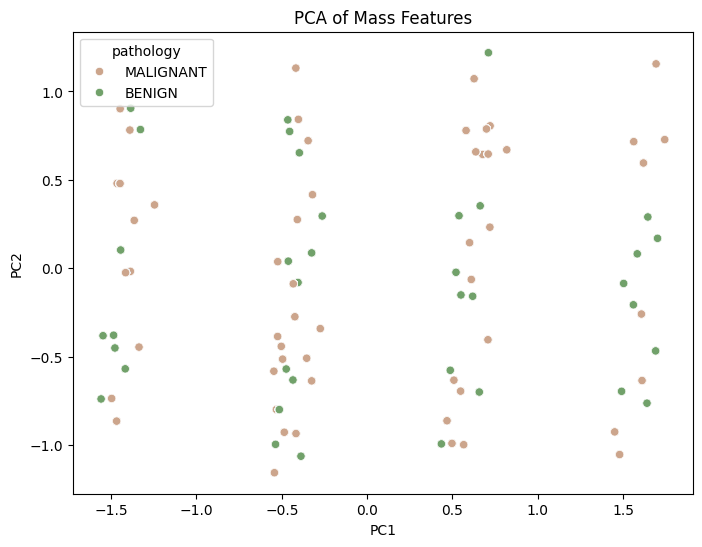

In [69]:
X = four_df.drop(columns=['patient_id', 'image view', 'abnormality id', 'abnormality type', 'pathology',
                                    'subtlety', 'image file path', 'cropped image file path',
                                    'ROI mask file path', 'tumor_id', 'malignant', 'y_pred', 'y_prob',
                                    'fold_number', 'file_number','left or right breast', 'assessment'])

# Perform PCA, reducing to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with PCA components and the pathology
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['pathology'] = four_df['pathology']

# Plot the PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='pathology', data=pca_df, palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'})
plt.title('PCA of Mass Features')
plt.show()


In [70]:
component_loadings = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
component_loadings


breast_density  multiple_tumors  ARCHITECTURAL_DISTORTION  \
PC1        0.982875        -0.061990                  0.083879   
PC2       -0.063072        -0.002821                  0.147144   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  \
PC1                 -0.005034                  0.000550   0.001256  -0.028726   
PC2                  0.006311                  0.007224   0.573364  -0.357192   

       LYMPH_NODE      OVAL     ROUND  CIRCUMSCRIBED  ILL_DEFINED  \
PC1 -0.000000e+00 -0.057776  0.021902      -0.062599    -0.009895   
PC2 -4.235165e-22 -0.229001 -0.061406      -0.426201     0.413769   

     MICROLOBULATED  OBSCURED  SPICULATED  
PC1       -0.051237  0.097722    0.047072  
PC2       -0.068350 -0.135519    0.292980

In [71]:
import numpy as np
from sklearn.metrics import accuracy_score

# Define ranges for thresholds
thresholds_1 = np.arange(0.1, 0.55, 0.01)  # Possible values for the first threshold
thresholds_2 = np.arange(0.45, 0.9, 0.01)  # Possible values for the second threshold

best_accuracy = 0
best_thresholds = (0, 0)

y_prob = four_df["y_prob"]

# Iterate over all combinations of thresholds
for t1 in thresholds_1:
    for t2 in thresholds_2:
        if t1 >= t2 :
            continue  # Ensure that the second threshold is greater than the first

        # Create masks based on the current thresholds
        mask_4A = y_prob < t1
        mask_4B = (y_prob >= t1) & (y_prob < t2)
        mask_4C = y_prob >= t2

        # Ensure that none of the categories are empty
        if np.sum(mask_4A) < 10000 or np.sum(mask_4B) < 10000 or np.sum(mask_4C) < 10000:
            continue

        # Extract true labels and predicted labels for each segment
        y_true_4A = four_df['malignant'][mask_4A]
        y_pred_4A = four_df['y_pred'][mask_4A]
        y_true_4B = four_df['malignant'][mask_4B]
        y_pred_4B = four_df['y_pred'][mask_4B]
        y_true_4C = four_df['malignant'][mask_4C]
        y_pred_4C = four_df['y_pred'][mask_4C]

        # Calculate accuracy for each category
        accuracy_4A = accuracy_score(y_true_4A, y_pred_4A) if len(y_true_4A) > 0 else 0
        accuracy_4B = accuracy_score(y_true_4B, y_pred_4B) if len(y_true_4B) > 0 else 0
        accuracy_4C = accuracy_score(y_true_4C, y_pred_4C) if len(y_true_4C) > 0 else 0

        # Compute the overall accuracy (mean of accuracies)
        overall_accuracy = (accuracy_4A + accuracy_4B + accuracy_4C ) / 3
        print(f"t1 {t1:.2f}, t2 {t2:.2f}, accuracy_4A {accuracy_4A:.4f}, accuracy_4B {accuracy_4B:.4f}, accuracy_4C {accuracy_4C:.4f}, overall_accuracy {overall_accuracy:.4f}")
        print(f"  Number of cases in 4A: {np.sum(mask_4A)}, Number of cases in 4B: {np.sum(mask_4B)}, Number of cases in 4C: {np.sum(mask_4C)}")
        # Update the best accuracy and thresholds if current combination is better
        if overall_accuracy > best_accuracy:
            best_accuracy = overall_accuracy
            best_thresholds = (t1, t2)
            best_sums = (np.sum(mask_4A), np.sum(mask_4B), np.sum(mask_4C))

print(f"Best Overall Accuracy: {best_accuracy}")
print(f"Optimal Thresholds: {best_thresholds}")
print(f"Best sums: {best_sums}")


# Print results
print(f"Accuracy for 4A: {accuracy_4A}")
print(f"Accuracy for 4B: {accuracy_4B}")
print(f"Accuracy for 4C: {accuracy_4C}")

t1 0.46, t2 0.49, accuracy_4A 0.8243, accuracy_4B 0.7474, accuracy_4C 0.6806, overall_accuracy 0.7508
  Number of cases in 4A: 12963, Number of cases in 4B: 13613, Number of cases in 4C: 43624
t1 0.46, t2 0.50, accuracy_4A 0.8243, accuracy_4B 0.6847, accuracy_4C 0.7030, overall_accuracy 0.7373
  Number of cases in 4A: 12963, Number of cases in 4B: 20418, Number of cases in 4C: 36819
t1 0.46, t2 0.51, accuracy_4A 0.8243, accuracy_4B 0.6473, accuracy_4C 0.7525, overall_accuracy 0.7414
  Number of cases in 4A: 12963, Number of cases in 4B: 30484, Number of cases in 4C: 26753
t1 0.46, t2 0.52, accuracy_4A 0.8243, accuracy_4B 0.6416, accuracy_4C 0.7997, overall_accuracy 0.7552
  Number of cases in 4A: 12963, Number of cases in 4B: 37380, Number of cases in 4C: 19857
t1 0.46, t2 0.53, accuracy_4A 0.8243, accuracy_4B 0.6558, accuracy_4C 0.8222, overall_accuracy 0.7674
  Number of cases in 4A: 12963, Number of cases in 4B: 43260, Number of cases in 4C: 13977
t1 0.46, t2 0.54, accuracy_4A 0.824

t1 0.46, t2 0.54, accuracy_4A 0.8243, accuracy_4B 0.6636, accuracy_4C 0.8496, overall_accuracy 0.7792

  Number of cases in 4A: 12963, Number of cases in 4B: 47122, Number of cases in 4C: 10115

In [72]:
fourA_df = four_df[four_df['y_prob'] < 0.46]
fourB_df = four_df[(four_df['y_prob'] >= 0.46) & (four_df['y_prob'] < 0.54)]
fourC_df = four_df[four_df['y_prob'] >= 0.54]

# For 4A
act_pred_benignA = fourA_df[(fourA_df['y_pred'] == 0) & (fourA_df['malignant'] == 0)]
act_pred_malignantA = fourA_df[(fourA_df['y_pred'] == 1) & (fourA_df['malignant'] == 1)]
fls_pred_benignA = fourA_df[(fourA_df['y_pred'] == 0) & (fourA_df['malignant'] == 1)]
fls_pred_malignantA = fourA_df[(fourA_df['y_pred'] == 1) & (fourA_df['malignant'] == 0)]
benign_A = fourA_df[fourA_df['malignant'] == 0]
malignant_A = fourA_df[fourA_df['malignant'] == 1]

# For 4B
act_pred_benignB = fourB_df[(fourB_df['y_pred'] == 0) & (fourB_df['malignant'] == 0)]
act_pred_malignantB = fourB_df[(fourB_df['y_pred'] == 1) & (fourB_df['malignant'] == 1)]
fls_pred_benignB = fourB_df[(fourB_df['y_pred'] == 0) & (fourB_df['malignant'] == 1)]
fls_pred_malignantB = fourB_df[(fourB_df['y_pred'] == 1) & (fourB_df['malignant'] == 0)]
benign_B = fourB_df[fourB_df['malignant'] == 0]
malignant_B = fourB_df[fourB_df['malignant'] == 1]

# For 4C
act_pred_benignC = fourC_df[(fourC_df['y_pred'] == 0) & (fourC_df['malignant'] == 0)]
act_pred_malignantC = fourC_df[(fourC_df['y_pred'] == 1) & (fourC_df['malignant'] == 1)]
fls_pred_benignC = fourC_df[(fourC_df['y_pred'] == 0) & (fourC_df['malignant'] == 1)]
fls_pred_malignantC = fourC_df[(fourC_df['y_pred'] == 1) & (fourC_df['malignant'] == 0)]
benign_C = fourC_df[fourC_df['malignant'] == 0]
malignant_C = fourC_df[fourC_df['malignant'] == 1]

# Print the number of cases in each category
print(f"4A - True Negative (Benign correctly predicted): {len(act_pred_benignA)}")
print(f"4A - True Positive (Malignant correctly predicted): {len(act_pred_malignantA)}")
print(f"4A - False Negative (Malignant but predicted Benign): {len(fls_pred_benignA)}")
print(f"4A - False Positive (Benign but predicted Malignant): {len(fls_pred_malignantA)}")
print(f"Probability of Malignant in 4A: {len(malignant_A) / len(fourA_df)}")


print(f"\n4B - True Negative (Benign correctly predicted): {len(act_pred_benignB)}")
print(f"4B - True Positive (Malignant correctly predicted): {len(act_pred_malignantB)}")
print(f"4B - False Negative (Malignant but predicted Benign): {len(fls_pred_benignB)}")
print(f"4B - False Positive (Benign but predicted Malignant): {len(fls_pred_malignantB)}")
print(f"Probability of Malignant in 4B: {len(malignant_B) / len(fourB_df)}")


print(f"\n4C - True Negative (Benign correctly predicted): {len(act_pred_benignC)}")
print(f"4C - True Positive (Malignant correctly predicted): {len(act_pred_malignantC)}")
print(f"4C - False Negative (Malignant but predicted Benign): {len(fls_pred_benignC)}")
print(f"4C - False Positive (Benign but predicted Malignant): {len(fls_pred_malignantC)}")
print(f"Probability of Malignant in 4C: {len(malignant_C) / len(fourC_df)}")





4A - True Negative (Benign correctly predicted): 10685
4A - True Positive (Malignant correctly predicted): 0
4A - False Negative (Malignant but predicted Benign): 2278
4A - False Positive (Benign but predicted Malignant): 0
Probability of Malignant in 4A: 0.17573092648306718

4B - True Negative (Benign correctly predicted): 13980
4B - True Positive (Malignant correctly predicted): 17290
4B - False Negative (Malignant but predicted Benign): 6438
4B - False Positive (Benign but predicted Malignant): 9414
Probability of Malignant in 4B: 0.5035439921904843

4C - True Negative (Benign correctly predicted): 0
4C - True Positive (Malignant correctly predicted): 8594
4C - False Negative (Malignant but predicted Benign): 0
4C - False Positive (Benign but predicted Malignant): 1521
Probability of Malignant in 4C: 0.8496292634700939


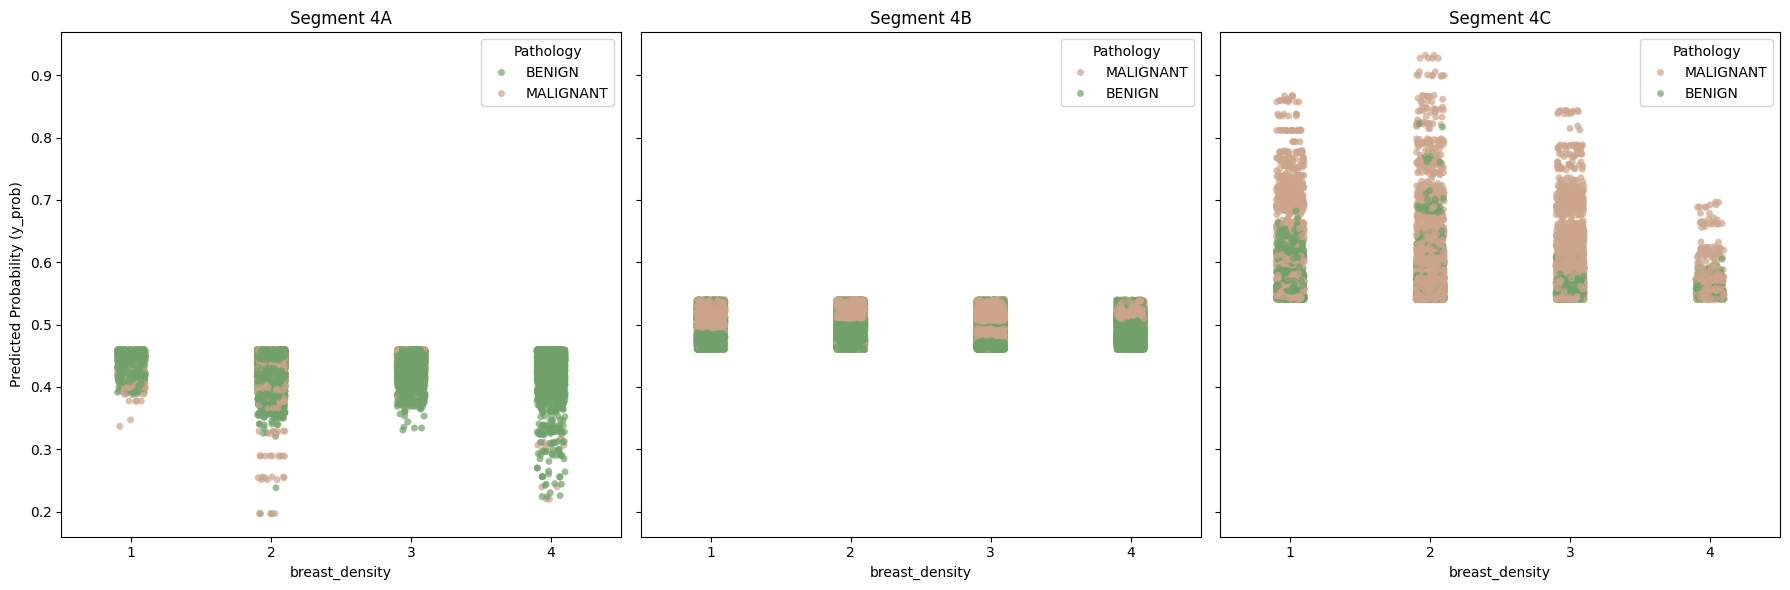

In [73]:
t1 = 0.46
t2 = 0.54

fourA_df = four_df[four_df['y_prob'] < t1]
fourB_df = four_df[(four_df['y_prob'] >= t1) & (four_df['y_prob'] < t2)]
fourC_df = four_df[four_df['y_prob'] >= t2]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot Segment 4A
sns.stripplot(data=fourA_df, x='breast_density', y='y_prob', jitter=True, alpha=0.7, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, ax=axes[0])
axes[0].set_title('Segment 4A')
axes[0].set_xlabel('breast_density')
axes[0].set_ylabel('Predicted Probability (y_prob)')
axes[0].legend(title='Pathology')

# Plot Segment 4B
sns.stripplot(data=fourB_df, x='breast_density', y='y_prob', jitter=True, alpha=0.7, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, ax=axes[1])
axes[1].set_title('Segment 4B')
axes[1].set_xlabel('breast_density')
axes[1].set_ylabel('Predicted Probability (y_prob)')
axes[1].legend(title='Pathology')

# Plot Segment 4C
sns.stripplot(data=fourC_df, x='breast_density', y='y_prob', jitter=True, alpha=0.7, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, ax=axes[2])
axes[2].set_title('Segment 4C')
axes[2].set_xlabel('breast_density')
axes[2].set_ylabel('Predicted Probability (y_prob)')
axes[2].legend(title='Pathology')

plt.tight_layout()
plt.show()


<ipython-input-74-d76ca1e810ac>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourA_df['Segment'] = '4A'
<ipython-input-74-d76ca1e810ac>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourB_df['Segment'] = '4B'
<ipython-input-74-d76ca1e810ac>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

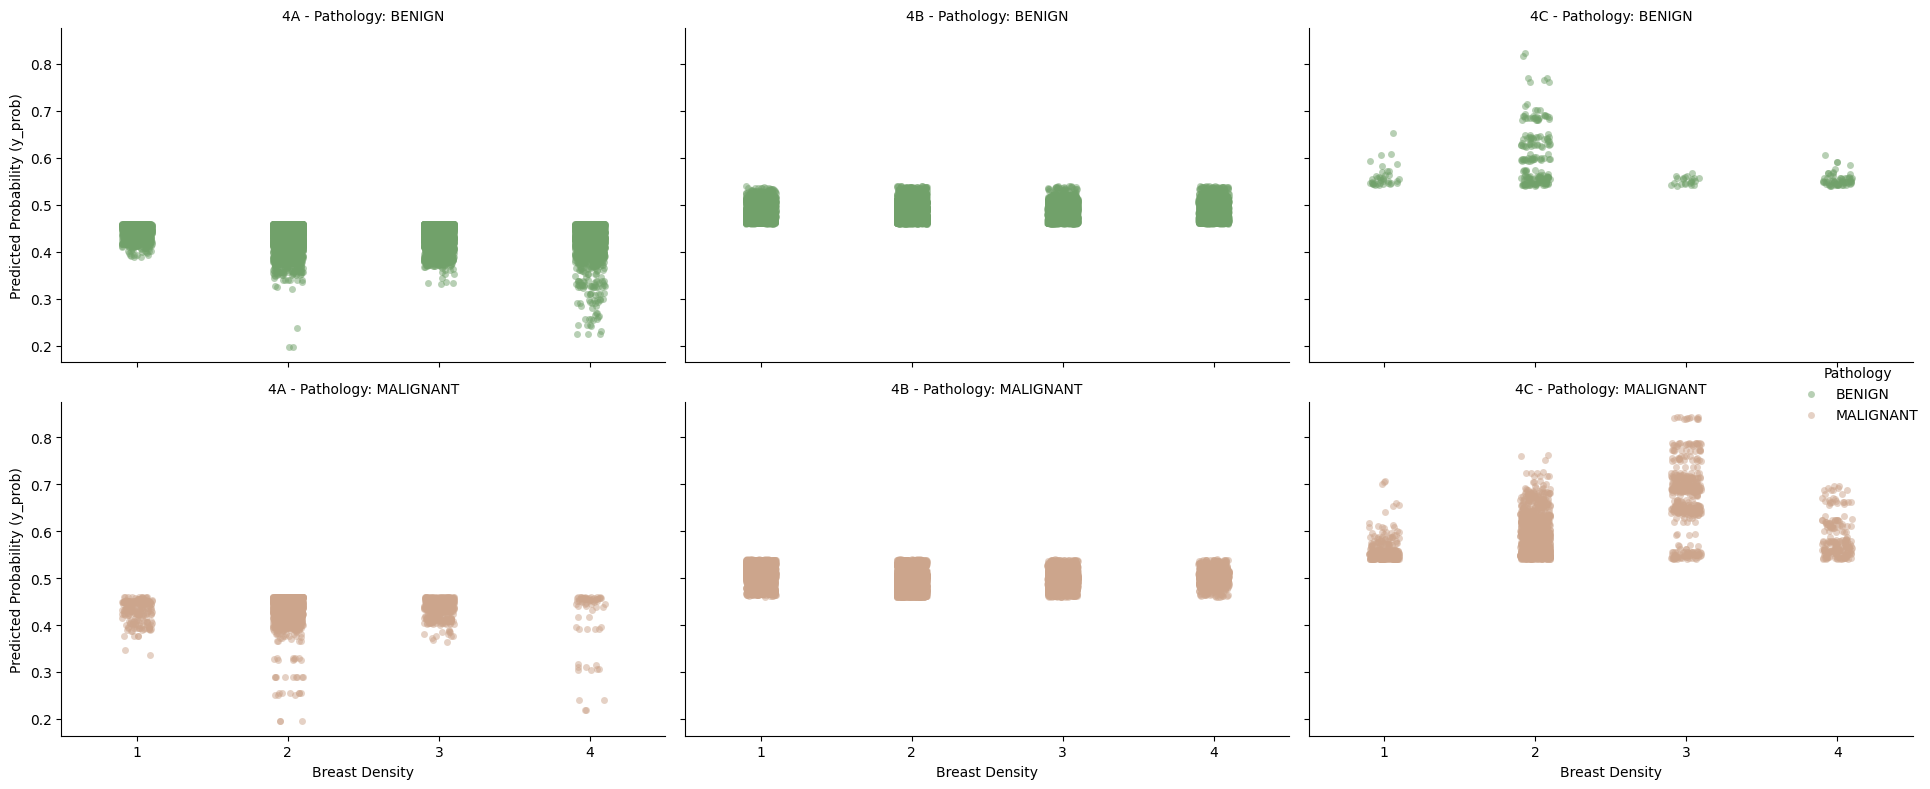

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


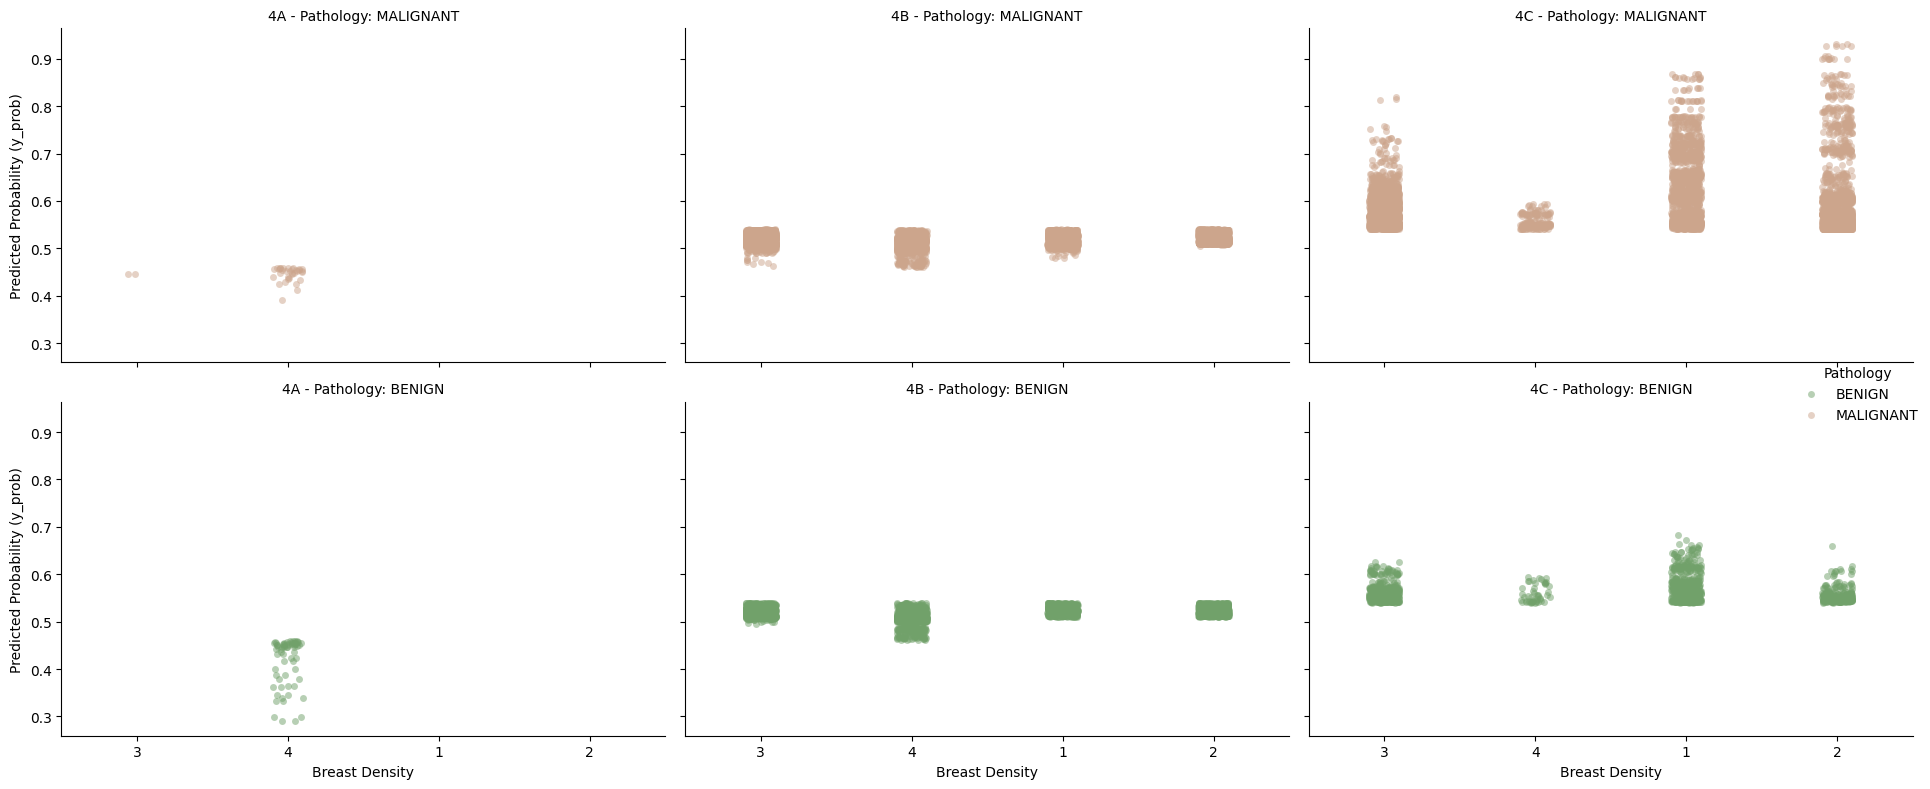

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define your thresholds
t1 = 0.46  # Example threshold for the first split
t2 = 0.54  # Example threshold for the second split

# Create DataFrames for each segment
fourA_df = four_df[four_df['y_prob'] < t1]
fourB_df = four_df[(four_df['y_prob'] >= t1) & (four_df['y_prob'] < t2)]
fourC_df = four_df[four_df['y_prob'] >= t2]

# Combine the segments into one DataFrame with an additional column for segment
fourA_df['Segment'] = '4A'
fourB_df['Segment'] = '4B'
fourC_df['Segment'] = '4C'

combined_df = pd.concat([fourA_df, fourB_df, fourC_df])

g1 = sns.FacetGrid(combined_df[combined_df["IRREGULAR"] == 0], col='Segment', row='pathology', height=4, aspect=1.5, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, hue_order=['BENIGN', 'MALIGNANT'])
g1.map(sns.stripplot, 'breast_density', 'y_prob', jitter=True, alpha=0.5, dodge=True)

g1.set_titles("{col_name} - Pathology: {row_name}")
g1.set_axis_labels('Breast Density', 'Predicted Probability (y_prob)')
g1.add_legend(title='Pathology')
plt.tight_layout()
plt.show()

g2 = sns.FacetGrid(combined_df[combined_df["IRREGULAR"] == 1], col='Segment', row='pathology', height=4, aspect=1.5, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, hue_order=['BENIGN', 'MALIGNANT'])

g2.map(sns.stripplot, 'breast_density', 'y_prob', jitter=True, alpha=0.5, dodge=True)

g2.set_titles("{col_name} - Pathology: {row_name}")
g2.set_axis_labels('Breast Density', 'Predicted Probability (y_prob)')
g2.add_legend(title='Pathology')
plt.tight_layout()
plt.show()


<ipython-input-75-03e5c29e19ae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourA_df['Segment'] = '4A'
<ipython-input-75-03e5c29e19ae>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourB_df['Segment'] = '4B'
<ipython-input-75-03e5c29e19ae>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

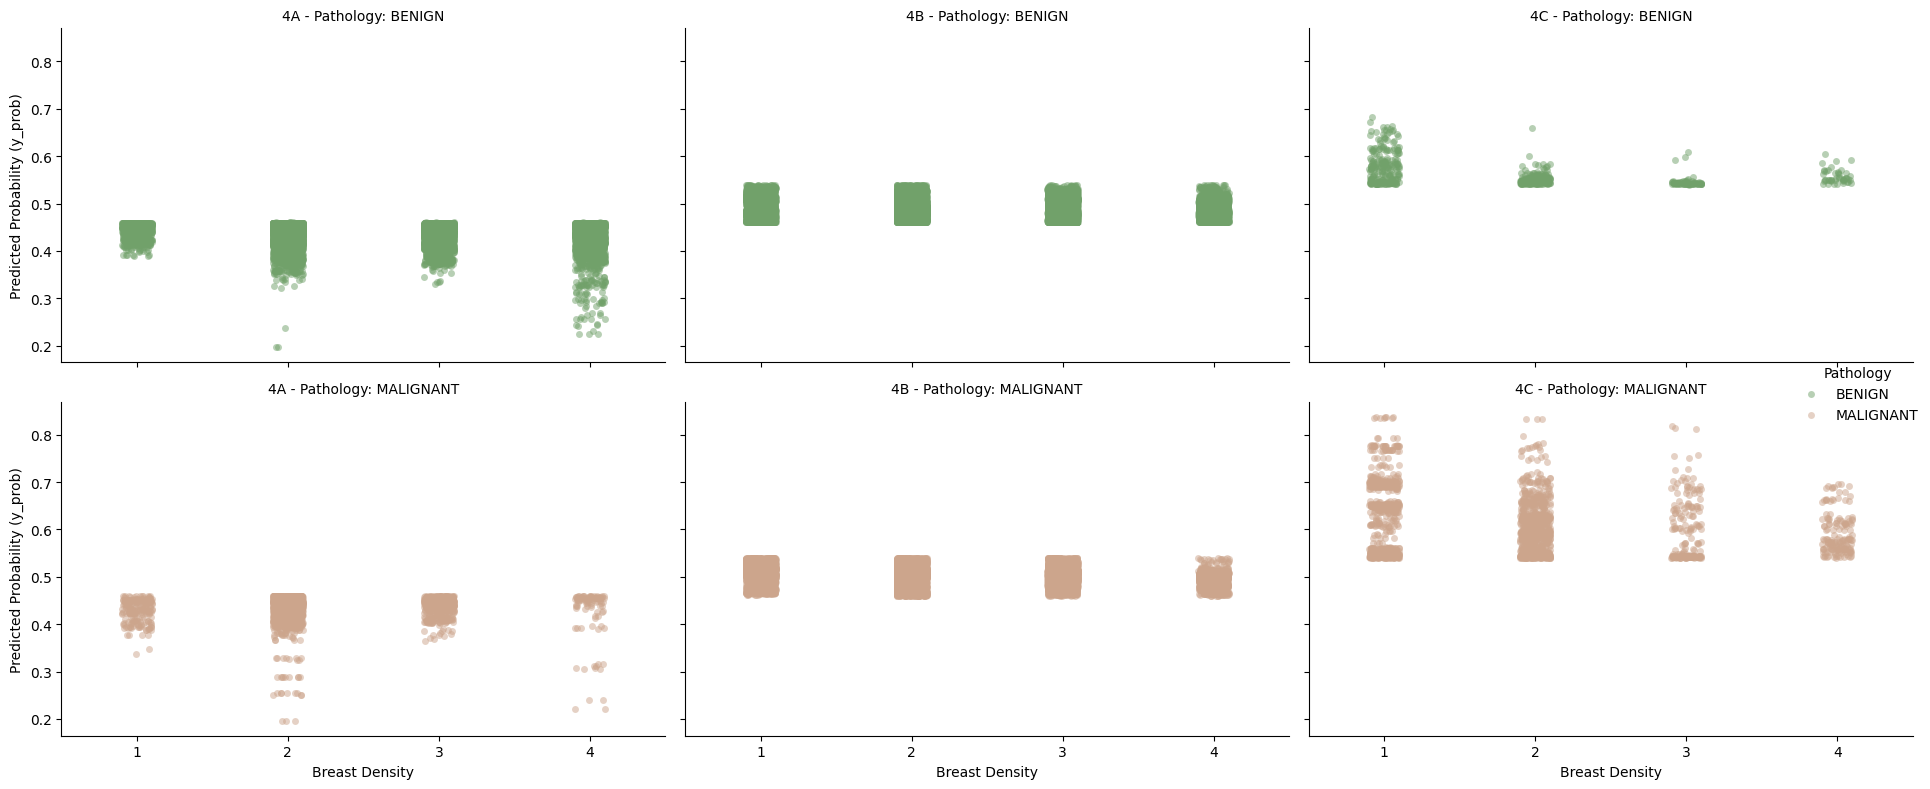

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


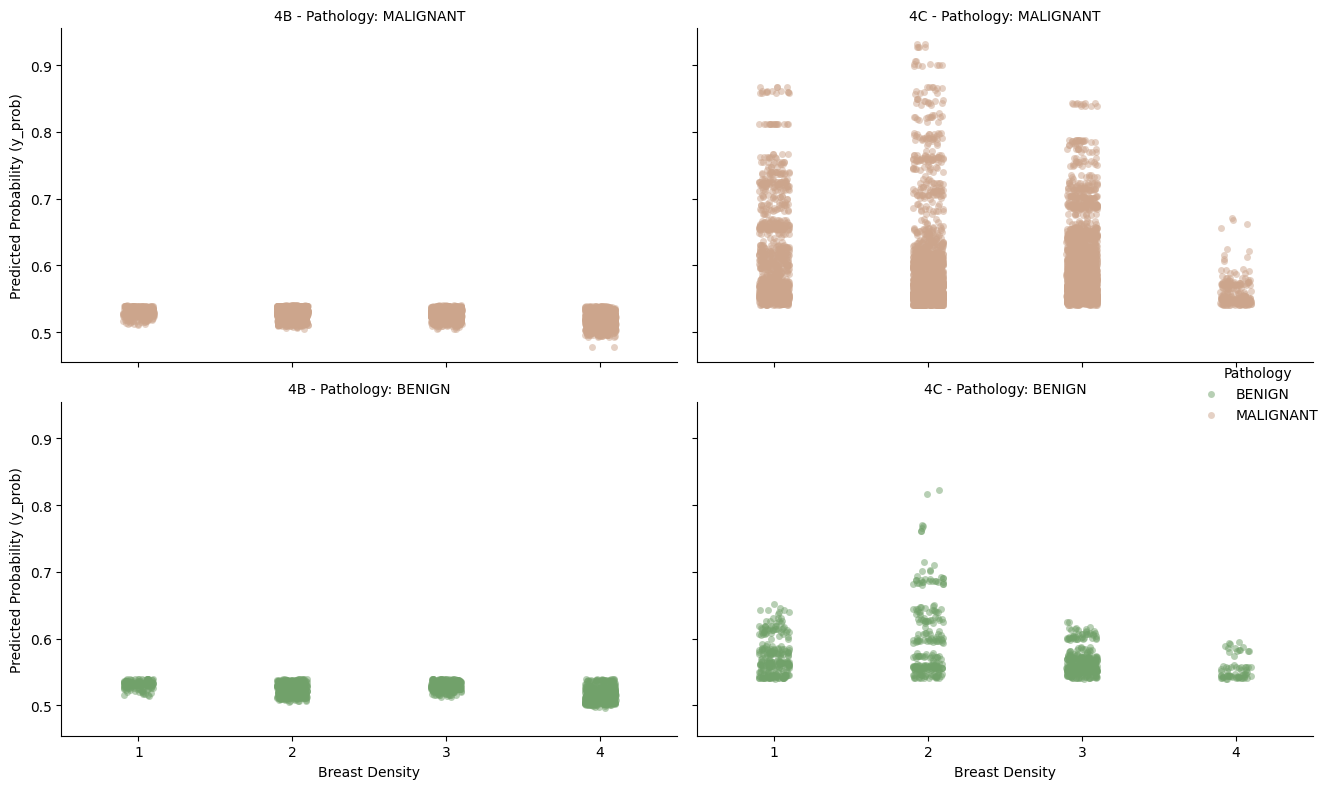

In [75]:
t1 = 0.46
t2 = 0.54

# Create DataFrames for each segment
fourA_df = four_df[four_df['y_prob'] < t1]
fourB_df = four_df[(four_df['y_prob'] >= t1) & (four_df['y_prob'] < t2)]
fourC_df = four_df[four_df['y_prob'] >= t2]

# Combine the segments into one DataFrame with an additional column for segment
fourA_df['Segment'] = '4A'
fourB_df['Segment'] = '4B'
fourC_df['Segment'] = '4C'

combined_df = pd.concat([fourA_df, fourB_df, fourC_df])

g1 = sns.FacetGrid(combined_df[combined_df["SPICULATED"] == 0], col='Segment', row='pathology', height=4, aspect=1.5, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, hue_order=['BENIGN', 'MALIGNANT'])
g1.map(sns.stripplot, 'breast_density', 'y_prob', jitter=True, alpha=0.5, dodge=True)

g1.set_titles("{col_name} - Pathology: {row_name}")
g1.set_axis_labels('Breast Density', 'Predicted Probability (y_prob)')
g1.add_legend(title='Pathology')
plt.tight_layout()
plt.show()

g2 = sns.FacetGrid(combined_df[combined_df["SPICULATED"] == 1], col='Segment', row='pathology', height=4, aspect=1.5, hue='pathology', palette={'MALIGNANT': '#CCA58c', 'BENIGN': '#71a16a'}, hue_order=['BENIGN', 'MALIGNANT'])

g2.map(sns.stripplot, 'breast_density', 'y_prob', jitter=True, alpha=0.5, dodge=True)

g2.set_titles("{col_name} - Pathology: {row_name}")
g2.set_axis_labels('Breast Density', 'Predicted Probability (y_prob)')
g2.add_legend(title='Pathology')
plt.tight_layout()
plt.show()


## Exploring the Misclassified Tumors

In [ ]:
missclassified_tumors = result_df[result_df['y_true'] != result_df['y_pred']]
missclassified_tumors

patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  \
4         P_01273               3       0       1  0.581487            1   
6         P_00169               1       0       1  0.531381            1   
9         P_00375               1       1       0  0.493679            1   
15        P_00226               1       1       0  0.452655            1   
17        P_00278               1       0       1  0.501822            1   
...           ...             ...     ...     ...       ...          ...   
169584    P_01623               1       0       1  0.567784           10   
169585    P_00810               1       1       0  0.443040           10   
169588    P_00264               1       1       0  0.425808           10   
169591    P_00092               1       1       0  0.423199           10   
169596    P_00224               1       0       1  0.508415           10   

        tumor_id  file_number  
4            902            1  
6            125            1  
9           1400            1  
15           160            1  
17          1380            1  
...          ...          ...  
169584      1648          100  
169585       569          100  
169588       185          100  
169591        71          100  
169596       155          100  

[33933 rows x 8 columns]

In [ ]:
grouped_df = missclassified_tumors.groupby('tumor_id').size().reset_index(name='count')

grouped_df = grouped_df.sort_values(by='count', ascending=False)
ensembled_missclassified = grouped_df[grouped_df['count'] > 50]
ensembled_missclassified = ensembled_missclassified.merge(result_mass, on='tumor_id', how='left')


In [ ]:
ensembled_missclassified['malignant'] = ensembled_missclassified['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0})

In [ ]:
ensembled_missclassified

tumor_id  count patient_id  breast_density left or right breast  \
0           3    100    P_00004               3                 LEFT   
1         987    100    P_01411               3                RIGHT   
2        1050    100    P_01504               2                 LEFT   
3        1042    100    P_01495               2                RIGHT   
4        1032    100    P_01484               3                RIGHT   
..        ...    ...        ...             ...                  ...   
325       828     61    P_01182               2                 LEFT   
326       160     61    P_00226               4                 LEFT   
327       856     61    P_01225               2                RIGHT   
328      1692     59    P_01825               2                RIGHT   
329      1322     57    P_00017               2                 LEFT   

    image view abnormality id abnormality type  assessment  pathology  ...  \
0           CC              1             mass           4     BENIGN  ...   
1          MLO              1             mass           4  MALIGNANT  ...   
2           CC              1             mass           0  MALIGNANT  ...   
3          MLO              1             mass           4     BENIGN  ...   
4          MLO              1             mass           4     BENIGN  ...   
..         ...            ...              ...         ...        ...  ...   
325        MLO              1             mass           0     BENIGN  ...   
326        MLO              1             mass           3  MALIGNANT  ...   
327        MLO              1             mass           4     BENIGN  ...   
328        MLO              1             mass           3     BENIGN  ...   
329        MLO              1             mass           4  MALIGNANT  ...   

     LOBULATED LYMPH_NODE OVAL ROUND  CIRCUMSCRIBED  ILL_DEFINED  \
0            0          0    0     0              0            1   
1            0          0    1     0              1            0   
2            1          0    0     0              0            0   
3            0          0    0     0              0            1   
4            0          0    0     0              0            1   
..         ...        ...  ...   ...            ...          ...   
325          0          0    1     0              0            0   
326          0          0    0     0              0            0   
327          1          0    0     0              0            0   
328          1          0    0     0              0            0   
329          0          0    0     1              0            1   

     MICROLOBULATED  OBSCURED  SPICULATED  malignant  
0                 0         0           0          0  
1                 0         0           0          1  
2                 0         1           0          1  
3                 0         0           0          0  
4                 0         0           0          0  
..              ...       ...         ...        ...  
325               1         0           0          0  
326               0         0           0          1  
327               1         0           0          0  
328               1         0           0          0  
329               0         0           0          1  

[330 rows x 29 columns]

In [ ]:
ensembled_missclassified.to_csv('ensembled_missclassified.csv', index=False)

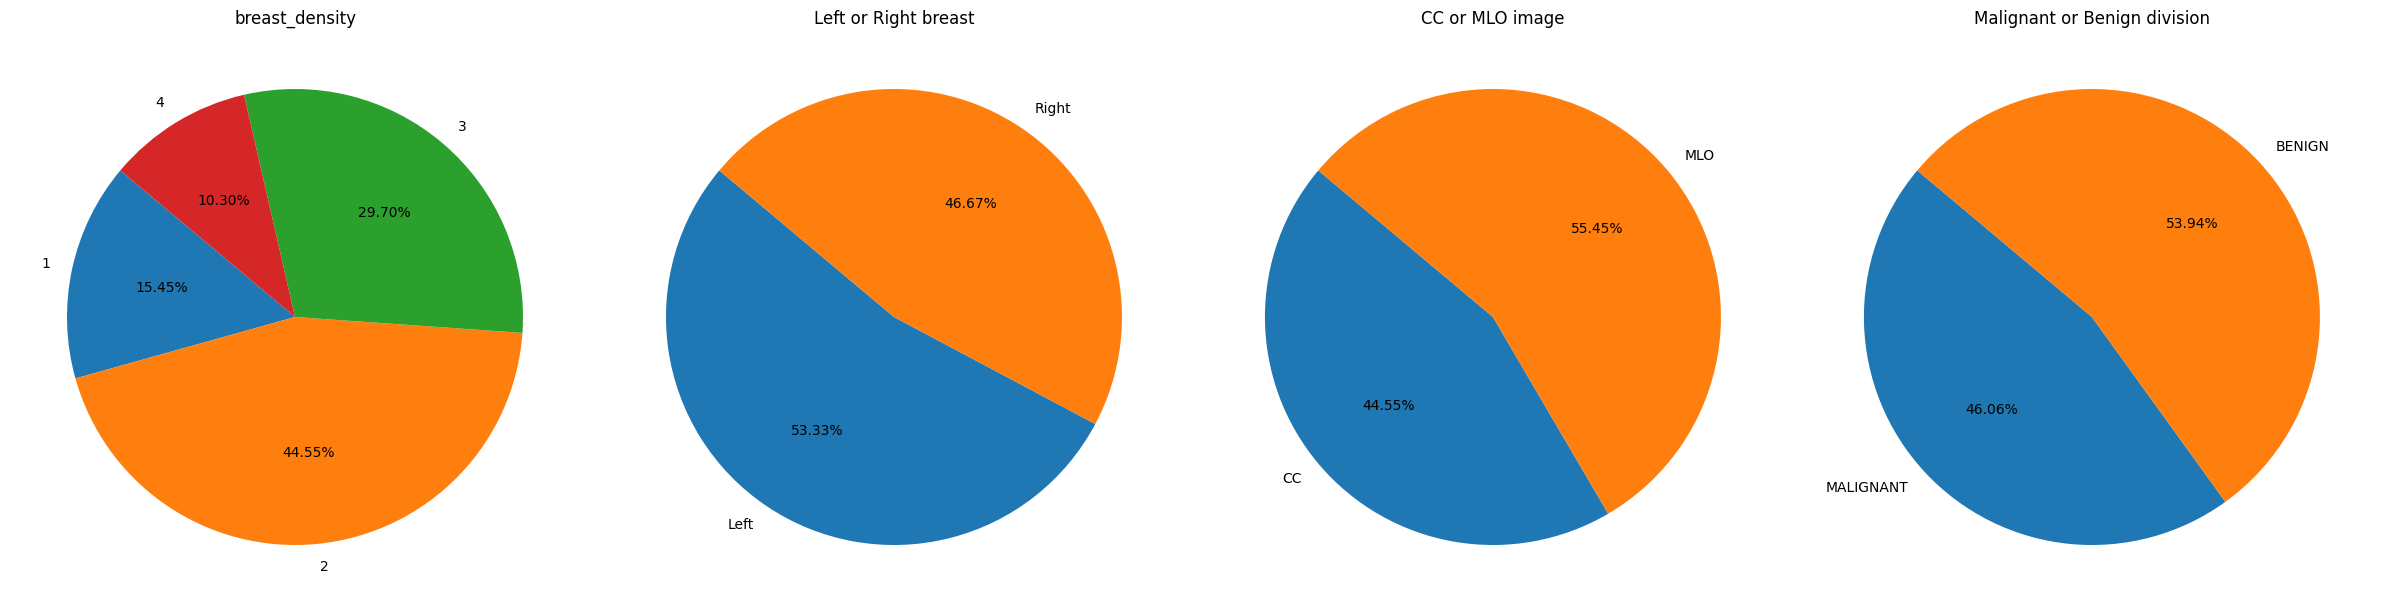

In [ ]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
((ax1, ax2, ax3, ax4)) = ax

# Subplot 1: Laterality Distribution
density_count = ensembled_missclassified['breast_density'].value_counts()
count_1 = density_count.loc[1]
count_2 = density_count.loc[2]
count_3 = density_count.loc[3]
count_4 = density_count.loc[4]

ax1.pie([count_1, count_2, count_3, count_4], labels=['1', '2', '3', '4'], autopct='%1.2f%%', startangle=140)
ax1.set_title('breast_density')


# Subplot 2: Orientation Distribution
mass_side = ensembled_missclassified['left or right breast'].value_counts()
count_Left = mass_side.get('LEFT', 0)
count_Right = mass_side.get('RIGHT', 0)

ax2.pie([count_Left, count_Right], labels=['Left', 'Right'], autopct='%1.2f%%', startangle=140)
ax2.set_title('Left or Right breast')


# Subplot 3: CC vs MLO
mass_side = ensembled_missclassified['image view'].value_counts()
count_CC = mass_side.get('CC', 0)
count_MLO = mass_side.get('MLO', 0)

ax3.pie([count_CC, count_MLO], labels=['CC', 'MLO'], autopct='%1.2f%%', startangle=140)
ax3.set_title('CC or MLO image')

# Subplot 4: Malignant or benign
mass_side = ensembled_missclassified['pathology'].value_counts()
count_malignant = mass_side.get('MALIGNANT', 0)
count_benign = mass_side.get('BENIGN', 0)

ax4.pie([count_malignant, count_benign], labels=['MALIGNANT', 'BENIGN'], autopct='%1.2f%%', startangle=140)
ax4.set_title('Malignant or Benign division')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
shapes_of_interest = ['IRREGULAR', 'ARCHITECTURAL_DISTORTION', 'OVAL', 'LYMPH_NODE',
                      'LOBULATED', 'FOCAL_ASYMMETRIC_DENSITY', 'ASYMMETRIC_BREAST_TISSUE']

malignant_mass = mass[mass['malignant'] == 1]
benign_mass = mass[mass['malignant'] == 0]

malignant_sums = malignant_mass[shapes_of_interest].sum()
benign_sums = benign_mass[shapes_of_interest].sum()

fig, ax = plt.subplots()

ax.bar(shapes_of_interest, benign_sums, label='Benign', color='#66b3ff')
ax.bar(shapes_of_interest, malignant_sums, bottom=benign_sums, label='Malignant', color='#ff9999')
ax.set_xlabel('Shape')
ax.set_ylabel('Count')
ax.set_title('Count of Each Mass Shape (Benign vs Malignant)')

plt.xticks(rotation=45, ha='right')

ax.legend()
plt.tight_layout()
plt.show()


Note that out of 1686 tumors, 330 were misclassified if we were to use assembled learning, which is just about 80.43% which has sightly improved the original accuracy.

# Rerunning Adaboost with the assessment column

In [ ]:
mass_one_hot

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      SPICULATED  malignant  breast_density_1  breast_density_2  \
0              1          1                 0                 0   
1              1          1                 0                 0   
2              0          0                 0                 0   
3              0          0                 0                 0   
4              0          0                 0                 0   
...          ...        ...               ...               ...   
1691           0          0                 0                 1   
1692           0          1                 0                 1   
1693           0          1                 0                 1   
1694           1          1                 0                 0   
1695           1          1                 0                 0   

      breast_density_3  breast_density_4  left or right breast_LEFT  \
0                    1                 0                          1   
1                    1                 0                          1   
2                    1                 0                          1   
3                    1                 0                          1   
4                    1                 0                          0   
...                ...               ...                        ...   
1691                 0                 0                          0   
1692                 0                 0                          0   
1693                 0                 0                          1   
1694                 1                 0                          0   
1695                 1                 0                          0   

      left or ri

In [ ]:
mass_one_hot_assessment = pd.merge(mass_one_hot, mass_full[['tumor_id', 'assessment']], on='tumor_id', how='left')

In [ ]:
one_hot_assessment = pd.get_dummies(mass_one_hot_assessment['assessment'], prefix='assessment')
mass_one_hot_assessment = mass_one_hot_assessment.drop(columns=['assessment']).join(one_hot_assessment)
mass_one_hot_assessment

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      left or right breast_LEFT  left or right breast_RIGHT  image view_CC  \
0                             1                           0              1   
1                             1                           0              0   
2                             1                           0              1   
3                             1                           0              0   
4                             0                           1              0   
...                         ...                         ...            ...   
1691                          0                           1              0   
1692                          0                           1              0   
1693                          1                           0              0   
1694                          0                           1              1   
1695                          0                           1              0   

      image view_MLO  assessment_0  assessment_1  assessment_2  assessment_3  \
0                  0         False         False         False         False   
1                  1         False         False         False         False   
2                  0         False         False         False         False   
3                  1         False         False         False         False   
4                  1         False         False         False         False   
...              ...           ...           ...           ...           ...   
1691               1         False         False         False          True   
1692               1         False         False         False         False   
1693             

In [ ]:
num_runs = 100
n_splits = 10

# Define the parameter grid for AdaBoost
base_estimators = [
    DecisionTreeClassifier(max_depth=2)
    ]

param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'base_estimator': base_estimators
}

models = {
    "Ada Boost Classifier": AdaBoostClassifier()
}


# Rest of your code remains the same
for run in range(62, num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_one_hot_assessment_shuffled = mass_one_hot_assessment.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_one_hot_assessment_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_one_hot_assessment_shuffled['malignant']
    groups = mass_one_hot_assessment_shuffled['patient_id']
    abnormality_ids = mass_one_hot_assessment_shuffled['abnormality id']
    tumor_id = mass_one_hot_assessment_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the AdaBoost model
            if model_name == "Ada Boost Classifier":
                grid_search = GridSearchCV(model, param_grid_adaboost, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/HyperParametersTuningAssessment_{model_name}_{run + 1}.csv', index=False)


Run:  62
['P_01534' 'P_01795']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00174               1       1       1  0.618405            1       128
1    P_00634               1       0       0  0.423881            1       440
2    P_00440               1       1       1  0.512928            1       319
3    P_01821               1       0       1  0.517936            1      1265
4    P_01876               1       0       0  0.490433            1      1293
Run:  63
['P_00358' 'P_00766']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00901               1       1       1  0.585217            1       628
1    P_00415               1       1       0  0.433122            1       283
2    P_01237               1       0       0  0.376476            1       865
3    P_00837               1       0       0  0.428414            1      1501
4    P_01887               1       0       0  0.432424            1      1302
Run:  64
['P_00119' 'P_01294']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01739               1       0       0  0.433483            1      1214
1    P_00229               1       0       0  0.351037            1       162
2    P_01248               1       1       1  0.780148            1       873
3    P_01889               1       0       0  0.444418            1      1304
4    P_00670               1       0       0  0.463315            1       461
Run:  65
['P_01666' 'P_01716']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01652               1       1       0  0.489016            1      1152
1    P_01363               1       0       0  0.456805            1       953
2    P_01617               1       1       1  0.657042            1      1646
3    P_00076               1       0       0  0.455211            1        56
4    P_00137               1       0       0  0.456336            1       112
Run:  66
['P_00902' 'P_01849']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00265               1       1       1  0.634400            1       186
1    P_00328               1       0       0  0.036549            1       219
2    P_00587               1       0       1  0.501931            1      1452
3    P_00206               1       0       0  0.442327            1       139
4    P_01677               1       0       0  0.431160            1      1659
Run:  67
['P_00202' 'P_01299']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00598               1       1       1  0.633444            1      1456
1    P_01595               1       0       0  0.465584            1      1639
2    P_01084               1       1       1  0.565961            1       748
3    P_01849               1       0       0  0.034659            1      1284
4    P_01213               1       1       1  0.500632            1      1570
Run:  68
['P_00896' 'P_00966']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00512               1       0       0  0.493637            1       359
1    P_00648               1       1       0  0.490113            1       448
2    P_01265               1       0       0  0.439535            1       885
3    P_00641               1       1       1  0.598379            1      1469
4    P_01744               1       1       0  0.463209            1      1216
Run:  69
['P_00401' 'P_01768']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00703               1       0       0  0.496020            1       485
1    P_00841               1       0       0  0.441477            1       589
2    P_00303               1       0       0  0.442176            1       203
3    P_00990               1       1       1  0.576490            1       687
4    P_01332               1       0       0  0.055508            1       934
Run:  70
['P_00782' 'P_01494']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00187               1       0       0  0.469811            1       132
1    P_00730               1       1       1  0.503712            1       512
2    P_00510               4       0       0  0.053777            1      1439
3    P_01251               1       0       0  0.487726            1      1573
4    P_00894               1       0       0  0.454876            1       624
Run:  71
['P_00212' 'P_00776']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00970               1       0       0  0.063802            1       674
1    P_00465               1       1       1  0.699722            1       336
2    P_00436               1       0       0  0.437879            1       313
3    P_01268               1       0       0  0.472289            1       888
4    P_00710               1       0       0  0.483029            1       493
Run:  72
['P_00773' 'P_00881']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01297               1       0       0  0.389616            1       913
1    P_01687               1       0       0  0.437980            1      1181
2    P_00702               1       1       0  0.499372            1       482
3    P_01694               1       1       1  0.505508            1      1183
4    P_00644               1       1       0  0.497520            1       446
Run:  73
['P_00079' 'P_00239']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01356               1       1       1  0.632865            1       947
1    P_01735               1       1       0  0.450375            1      1209
2    P_01076               1       1       1  0.591443            1       740
3    P_01031               1       1       1  0.613883            1       704
4    P_00509               1       0       0  0.477883            1       357
Run:  74
['P_00175' 'P_00356']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01262               1       1       1  0.805648            1       883
1    P_01737               1       0       0  0.483013            1      1210
2    P_01650               1       0       0  0.456807            1      1151
3    P_01540               1       1       1  0.663781            1      1067
4    P_00961               1       1       1  0.639693            1       669
Run:  75
['P_00342' 'P_01237']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00110               1       1       0  0.496471            1        99
1    P_01912               1       1       1  0.580772            1      1696
2    P_01163               1       1       1  0.516706            1       808
3    P_01130               1       1       1  0.548731            1       777
4    P_01656               1       1       1  0.578087            1      1157
Run:  76
['P_00131' 'P_01165']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00540               1       1       1  0.605528            1       384
1    P_00972               1       1       0  0.496067            1       676
2    P_00145               1       0       0  0.462517            1      1344
3    P_00596               1       1       1  0.585451            1       422
4    P_00106               3       0       0  0.044378            1        92
Run:  77
['P_01264' 'P_01371']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01418               1       1       1  0.525150            1       994
1    P_00782               1       1       1  0.517447            1       551
2    P_00239               1       0       0  0.470484            1       169
3    P_01635               1       0       1  0.785835            1      1134
4    P_01328               1       1       1  0.522955            1       932
Run:  78
['P_00296' 'P_00773']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00978               1       0       0  0.336678            1       679
1    P_01304               1       1       1  0.625466            1       920
2    P_00528               1       0       0  0.336620            1       373
3    P_00499               1       0       1  0.534706            1       353
4    P_01848               1       1       0  0.457721            1      1282
Run:  79
['P_00630' 'P_01402']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01486               1       0       0  0.465557            1      1036
1    P_00639               1       0       0  0.326081            1      1468
2    P_01203               1       0       0  0.475535            1       839
3    P_01144               1       1       1  0.750187            1       787
4    P_00429               1       0       1  0.549156            1      1417
Run:  80
['P_00865' 'P_01853']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01912               1       1       1  0.530415            1      1695
1    P_00528               2       0       0  0.422391            1       374
2    P_00694               1       0       0  0.473926            1       475
3    P_00465               1       1       1  0.555389            1       336
4    P_01350               1       1       0  0.492739            1       943
Run:  81
['P_00666' 'P_01701']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01889               1       0       0  0.451702            1      1304
1    P_01484               1       0       1  0.509461            1      1032
2    P_00738               1       0       0  0.486274            1      1484
3    P_00175               1       1       0  0.495847            1       131
4    P_00932               1       1       0  0.496373            1      1514
Run:  82
['P_00023' 'P_00435']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00797               1       0       0  0.369668            1       559
1    P_00298               1       0       0  0.497282            1       200
2    P_01018               1       0       0  0.359713            1       703
3    P_00776               1       1       1  0.509600            1       541
4    P_00737               1       1       1  0.807088            1       520
Run:  83
['P_00171' 'P_00289']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00147               1       1       1  0.500822            1      1346
1    P_01070               1       1       1  0.506840            1       737
2    P_00021               1       0       0  0.456831            1        13
3    P_00095               1       1       1  0.502865            1        76
4    P_00106               2       0       0  0.040430            1        91
Run:  84
['P_00732' 'P_01572']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00539               1       1       1  0.572139            1       382
1    P_01331               1       0       1  0.509291            1      1592
2    P_00584               1       1       1  0.631898            1       413
3    P_01557               1       0       0  0.461093            1      1075
4    P_01267               1       0       0  0.488357            1       887
Run:  85
['P_00896' 'P_01702']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01103               3       1       1  0.521523            1       761
1    P_01853               1       1       1  0.523055            1      1287
2    P_00218               1       1       0  0.497527            1       150
3    P_00177               1       0       1  0.510210            1      1358
4    P_01600               1       1       1  0.533538            1      1101
Run:  86
['P_00431' 'P_01103']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01589               1       1       1  0.523025            1      1093
1    P_01558               1       1       1  0.601939            1      1630
2    P_00984               1       1       1  0.660380            1       683
3    P_00636               1       1       0  0.495190            1      1466
4    P_00026               1       0       0  0.480641            1        17
Run:  87
['P_00081' 'P_00159']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00554               1       1       0  0.478145            1       393
1    P_01305               1       0       0  0.479819            1       921
2    P_00731               1       0       0  0.490416            1       513
3    P_00781               1       0       0  0.440782            1       549
4    P_00287               1       1       1  0.531575            1       194
Run:  88
['P_01566' 'P_01620']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01146               1       0       0  0.436419            1       789
1    P_00207               1       1       1  0.546643            1       140
2    P_01163               1       1       1  0.534999            1       808
3    P_00626               1       0       0  0.436549            1       435
4    P_01331               1       0       1  0.507658            1      1592
Run:  89
['P_00356' 'P_00894']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01155               1       1       0  0.487940            1       801
1    P_01761               1       1       1  0.745999            1      1231
2    P_00264               1       1       0  0.405680            1       184
3    P_00192               1       0       0  0.478094            1      1360
4    P_01682               1       1       1  0.691017            1      1174
Run:  90
['P_00644' 'P_01484']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               5       0       0  0.040260            1        86
1    P_01475               1       0       0  0.469583            1      1026
2    P_00475               1       0       0  0.495369            1       341
3    P_01355               1       1       1  0.548425            1       945
4    P_01232               1       1       1  0.534551            1       861
Run:  91
['P_00493' 'P_01212']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00803               1       1       0  0.478554            1       568
1    P_01423               1       0       0  0.480285            1       995
2    P_01908               1       1       0  0.474781            1      1307
3    P_01849               1       0       0  0.037952            1      1284
4    P_00076               1       0       0  0.475666            1        56
Run:  92
['P_00733' 'P_02092']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00406               1       1       1  0.526998            1       271
1    P_00061               1       0       0  0.436549            1        46
2    P_00411               1       0       0  0.448646            1       275
3    P_00893               1       0       0  0.485850            1      1507
4    P_01371               1       1       1  0.507869            1       958
Run:  93
['P_00224' 'P_01312']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00673               3       0       0  0.058267            1       464
1    P_00454               1       0       0  0.462268            1       331
2    P_01226               1       0       0  0.484247            1       857
3    P_00972               1       1       0  0.498305            1       676
4    P_01391               1       1       1  0.571282            1       974
Run:  94
['P_00278' 'P_01332']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00739               1       0       0  0.439529            1       522
1    P_01330               1       0       1  0.514501            1       933
2    P_01673               1       0       0  0.485371            1      1657
3    P_01684               1       0       0  0.483161            1      1661
4    P_00444               1       1       0  0.484492            1       324
Run:  95
['P_01110' 'P_01741']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00242               1       0       0  0.475411            1       175
1    P_01014               1       1       1  0.671723            1      1537
2    P_00753               1       1       1  0.535033            1       530
3    P_00870               1       1       1  0.558809            1       609
4    P_00128               1       1       1  0.503443            1       106
Run:  96
['P_00016' 'P_01438']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01103               3       1       1  0.521799            1       758
1    P_00134               1       1       0  0.497993            1       109
2    P_00273               1       0       0  0.489533            1       188
3    P_01606               1       1       1  0.636840            1      1105
4    P_01235               1       1       1  0.527650            1      1571
Run:  97
['P_00076' 'P_00092']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01175               1       0       0  0.353980            1       818
1    P_00081               1       0       0  0.474585            1        62
2    P_00779               1       1       1  0.753214            1       548
3    P_01175               1       0       0  0.344270            1       819
4    P_00716               1       1       1  0.567256            1       501
Run:  98
['P_01649' 'P_01890']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00319               1       1       1  0.694519            1       216
1    P_00239               1       0       0  0.487044            1       169
2    P_01398               1       0       0  0.125709            1       981
3    P_01140               1       1       1  0.521196            1      1557
4    P_00289               1       0       0  0.447074            1       196
Run:  99
['P_00935' 'P_01218']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01290               1       1       1  0.561492            1       911
1    P_00414               1       1       1  0.591367            1       281
2    P_00200               1       0       0  0.445870            1      1366
3    P_01185               1       0       0  0.234754            1       829
4    P_01209               1       0       0  0.451256            1       843


In [ ]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/'

# Define the models
models = ['HyperParametersTuningAssessment_Ada Boost Classifier']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")


Model: HyperParametersTuningAssessment_Ada Boost Classifier
  accuracy: 0.8310
  recall: 0.7965
  precision: 0.8309
  f1_score: 0.8133
  auc: 0.9041




In [ ]:
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/AdaBoost_withAssessment/'
result_assmt_df = pd.DataFrame()

# Loop through all the relevant CSV files
for i in range(1, 101):
    # Construct the filename
    filename = f'{base_path}HyperParametersTuningAssessment_Ada Boost Classifier_{i}.csv'

    # Load the CSV file into a DataFrame
    new_df = pd.read_csv(filename)

    # Add a column with the file number
    new_df['file_number'] = i

    # Append the DataFrame to the result DataFrame
    result_assmt_df = pd.concat([result_df, new_df], ignore_index=True)

result_assmt_df.to_csv(f'{base_path}WithAssessment_All_HyperParametersTuning_Ada_Boost.csv', index=False)


In [ ]:
result_assmt_df

patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  \
0         P_01412               1       1       1  0.752522            1   
1         P_01543               1       0       0  0.475434            1   
2         P_00997               1       1       1  0.643993            1   
3         P_01153               1       0       0  0.479745            1   
4         P_01273               3       0       0  0.413422            1   
...           ...             ...     ...     ...       ...          ...   
171291    P_00342               2       0       0  0.380584           10   
171292    P_00224               1       0       0  0.480403           10   
171293    P_01243               1       0       0  0.440790           10   
171294    P_00313               1       1       1  0.504960           10   
171295    P_01481               1       1       1  0.567799           10   

        tumor_id  file_number  
0            988            1  
1           1070            1  
2            693            1  
3            800            1  
4            902            1  
...          ...          ...  
171291       236          100  
171292       155          100  
171293       871          100  
171294       211          100  
171295      1029          100  

[171296 rows x 8 columns]

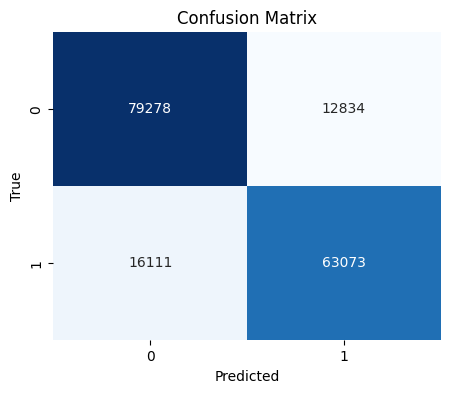

In [ ]:
y_true = result_assmt_df['y_true']
y_pred = result_assmt_df['y_pred']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


It is interesting to see that the new model has managed to predict more tumors which are actually benign that has previously predicted as malignant. It has also managed to correctly predict a bit more tumors which were previously classified as benign, however not quite as many as benign.

In [ ]:
full_mass_assmt = full_mass.merge(result_df[['tumor_id', 'y_pred', 'y_prob']], on='tumor_id', how='left')
full_mass_assmt.head()

patient_id  breast_density left or right breast image view abnormality id  \
0    P_00001               3                 LEFT         CC              1   
1    P_00001               3                 LEFT         CC              1   
2    P_00001               3                 LEFT         CC              1   
3    P_00001               3                 LEFT         CC              1   
4    P_00001               3                 LEFT         CC              1   

  abnormality type                          mass shape mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED   
2             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED   
3             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED   
4             mass  IRREGULAR-ARCHITECTURAL_DISTORTION   SPICULATED   

   assessment  pathology  subtlety  tumor_id  multiple_tumors  y_pred  \
0           4  MALIGNANT         4         1              0.0       1   
1           4  MALIGNANT         4         1              0.0       1   
2           4  MALIGNANT         4         1              0.0       1   
3           4  MALIGNANT         4         1              0.0       1   
4           4  MALIGNANT         4         1              0.0       1   

     y_prob  
0  0.523597  
1  0.545235  
2  0.528927  
3  0.521272  
4  0.523431

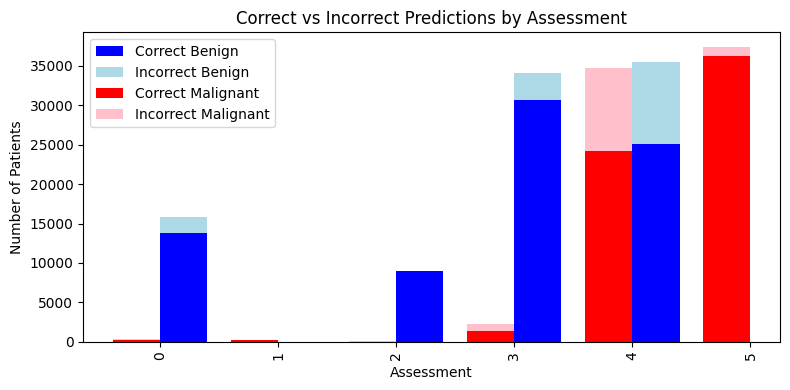

In [ ]:
# Calculate correct and incorrect predictions
correct_benign = full_mass_assmt[(full_mass_assmt['y_pred'] == 0) & (full_mass_assmt['pathology'] == 'BENIGN')]['assessment'].value_counts()
incorrect_benign = full_mass_assmt[(full_mass_assmt['y_pred'] == 0) & (full_mass_assmt['pathology'] == 'MALIGNANT')]['assessment'].value_counts()

correct_malignant = full_mass_assmt[(full_mass_assmt['y_pred'] == 1) & (full_mass_assmt['pathology'] == 'MALIGNANT')]['assessment'].value_counts()
incorrect_malignant = full_mass_assmt[(full_mass_assmt['y_pred'] == 1) & (full_mass_assmt['pathology'] == 'BENIGN')]['assessment'].value_counts()

# Combine the counts into a DataFrame for plotting
prediction_counts = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)

fig, ax = plt.subplots(figsize=(8, 4))

prediction_counts[['Correct Benign', 'Incorrect Benign']].plot(kind='bar', ax=ax, color=['blue', 'lightblue'], stacked=True, position=0, width=0.4, align='center', label='Benign')
prediction_counts[['Correct Malignant', 'Incorrect Malignant']].plot(kind='bar', ax=ax, color=['red', 'pink'], stacked=True, position=1, width=0.4, align='center', label='Malignant')

ax.set_xlabel('Assessment')
ax.set_ylabel('Number of Patients')
ax.set_title('Correct vs Incorrect Predictions by Assessment')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
counts_df = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)


counts_df['Benign Accuracy'] = counts_df['Correct Benign'] / (counts_df['Correct Benign'] + counts_df['Incorrect Benign'])
counts_df['Malignant Accuracy'] = counts_df['Correct Malignant'] / (counts_df['Correct Malignant'] + counts_df['Incorrect Malignant'])
counts_df.fillna(0, inplace=True)

counts_df

Correct Benign  Incorrect Benign  Correct Malignant  \
assessment                                                        
0                  13862.0              1923              277.0   
1                      0.0                12              288.0   
2                   8934.0               100                0.0   
3                  30628.0              3487             1413.0   
4                  25068.0             10411            24189.0   
5                      0.0                24            36276.0   

            Incorrect Malignant  Benign Accuracy  Malignant Accuracy  
assessment                                                            
0                         138.0         0.878175            0.667470  
1                           0.0         0.000000            1.000000  
2                          66.0         0.988931            0.000000  
3                         872.0         0.897787            0.618381  
4                       10532.0         0.706559            0.696668  
5                        1100.0         0.000000            0.970569

# ROI images feature extraction

1. Area:

A large area might indicate a significant tumor mass.
A small area could suggest a benign or early-stage lesion.

2. Perimeter:

A long perimeter might indicate an irregular or complex tumor shape.
A shorter perimeter could suggest a more regular or spherical shape.

3. Circularity:

A circularity value close to 1 indicates a perfectly round shape.
A value closer to 0 suggests a more irregular or elongated shape.

4. Ellipticity:

An ellipticity value close to 1 indicates a highly elongated shape.
A value closer to 0 suggests a more circular shape.

5. Convex Hull:

The convex hull can be used to measure the degree of irregularity or concavity of the tumor's boundary.
A tumor with a large difference between its area and the area of its convex hull suggests a more irregular shape.

6. Eccentricity:

Similar to ellipticity, eccentricity measures the degree of elongation.
A higher eccentricity value indicates a more elongated shape

In [30]:
skimage_df = pd.read_csv('/content/drive/MyDrive/DDSM data/ROI_Mask_feature_extraction_maxArea_skimage.csv', sep=',')
skimage_df

Image Path    Area    Perimeter  \
0     /kaggle/input/cbis-ddsm-breast-cancer-image-da...   20364  1367.614357   
1     /kaggle/input/cbis-ddsm-breast-cancer-image-da...    1462   207.432504   
2     /kaggle/input/cbis-ddsm-breast-cancer-image-da...   22071  1714.267207   
3     /kaggle/input/cbis-ddsm-breast-cancer-image-da...  165589  3472.162697   
4     /kaggle/input/cbis-ddsm-breast-cancer-image-da...   75902  2453.722005   
...                                                 ...     ...          ...   
3242  /kaggle/input/cbis-ddsm-breast-cancer-image-da...   35501  2681.963779   
3243  /kaggle/input/cbis-ddsm-breast-cancer-image-da...  126874  3295.409522   
3244  /kaggle/input/cbis-ddsm-breast-cancer-image-da...   46064  2054.445922   
3245  /kaggle/input/cbis-ddsm-breast-cancer-image-da...   29034  2516.673411   
3246  /kaggle/input/cbis-ddsm-breast-cancer-image-da...   54672  3087.267386   

      Eccentricity  Solidity    Extent  
0         0.562664  0.904946  0.640257  
1         0.620929  0.880723  0.727725  
2         0.643805  0.862384  0.605415  
3         0.740141  0.970718  0.729053  
4         0.730480  0.952585  0.793415  
...            ...       ...       ...  
3242      0.730028  0.837900  0.632028  
3243      0.968866  0.954794  0.641968  
3244      0.419262  0.905684  0.686795  
3245      0.506646  0.799086  0.653330  
3246      0.637102  0.850688  0.619611  

[3247 rows x 6 columns]

In [31]:
print(skimage_df['Image Path'][0],
skimage_df['Image Path'][1],
skimage_df['Image Path'][2],
skimage_df['Image Path'][3],
skimage_df['Image Path'][4])


/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132/2-241.jpg /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.10055294210766234140934516480682841962/2-011.jpg /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.100905990410891350726987703140883813087/1-174.jpg /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.100906036712673986206442054953651734884/2-025.jpg /kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.100983979911824949714845959010086335063/2-015.jpg


In [32]:
skimage_df['Image Path'] = skimage_df['Image Path'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
skimage_df['Image Path'] = skimage_df['Image Path'].str[:-10]
skimage_df

Image Path    Area    Perimeter  \
0     1.3.6.1.4.1.9590.100.1.2.100018879311824535125...   20364  1367.614357   
1     1.3.6.1.4.1.9590.100.1.2.100552942107662341409...    1462   207.432504   
2     1.3.6.1.4.1.9590.100.1.2.100905990410891350726...   22071  1714.267207   
3     1.3.6.1.4.1.9590.100.1.2.100906036712673986206...  165589  3472.162697   
4     1.3.6.1.4.1.9590.100.1.2.100983979911824949714...   75902  2453.722005   
...                                                 ...     ...          ...   
3242  1.3.6.1.4.1.9590.100.1.2.988696080121410568332...   35501  2681.963779   
3243  1.3.6.1.4.1.9590.100.1.2.993938233119129041331...  126874  3295.409522   
3244  1.3.6.1.4.1.9590.100.1.2.995562726124574226321...   46064  2054.445922   
3245  1.3.6.1.4.1.9590.100.1.2.996173160105229898425...   29034  2516.673411   
3246  1.3.6.1.4.1.9590.100.1.2.999339456125048761365...   54672  3087.267386   

      Eccentricity  Solidity    Extent  
0         0.562664  0.904946  0.640257  
1         0.620929  0.880723  0.727725  
2         0.643805  0.862384  0.605415  
3         0.740141  0.970718  0.729053  
4         0.730480  0.952585  0.793415  
...            ...       ...       ...  
3242      0.730028  0.837900  0.632028  
3243      0.968866  0.954794  0.641968  
3244      0.419262  0.905684  0.686795  
3245      0.506646  0.799086  0.653330  
3246      0.637102  0.850688  0.619611  

[3247 rows x 6 columns]

In [33]:
result_mass

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ... LOBULATED  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...         0   
...                                                 ...  ...       ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         1   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...         0   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...         0   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      0              0            0               0   
1             0     0      0              0            0               0   
2             0     0      0              0            1               0   
3             0     0      0              0            1               0   
4             0     1      0              1            0               0   
...         ...   ...    ...            ...          ...             ...   
1691          0     0      0              0            0               1   
1692          0     0      0              0            1               0   
1693          0     0      0              0            1               0   
1694          0     0      0              0            0               0   
1695          0     0      0              0            0               0   

      OBSCURED  SPICULATED  malignant  
0            0           1          1  
1            0           1          1  
2            0           0          0  
3            0           0          0  
4            0           0          0  
...        ...         ...        ...  
1691         0           0          0  
1692         0           0          1  
1693         0           0          1  
1694         0           1          1  
1695         0           1          1  

[1696 rows x 28 columns]

In [34]:
# Function to remove everything up to and including the second "/"
def remove_up_to_second_slash(path):
    parts = path.split('/')
    return '/'.join(parts[2:])

In [35]:
result_mass['ROI mask file path'][0]

'Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000001.dcm\n'

In [36]:
mass_roi = result_mass
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].str[:-12]
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].apply(remove_up_to_second_slash)
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ... LOBULATED  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...         0   
...                                                 ...  ...       ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         1   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...         0   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...         0   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      0              0            0               0   
1             0     0      0              0            0               0   
2             0     0      0              0            1               0   
3             0     0      0              0            1               0   
4             0     1      0              1            0               0   
...         ...   ...    ...            ...          ...             ...   
1691          0     0      0              0            0               1   
1692          0     0      0              0            1               0   
1693          0     0      0              0            1               0   
1694          0     0      0              0            0               0   
1695          0     0      0              0            0               0   

      OBSCURED  SPICULATED  malignant  
0            0           1          1  
1            0           1          1  
2            0           0          0  
3            0           0          0  
4            0           0          0  
...        ...         ...        ...  
1691         0           0          0  
1692         0           0          1  
1693         0           0          1  
1694         0           1          1  
1695         0           1          1  

[1696 rows x 28 columns]

In [37]:
mass_roi = mass_roi.merge(skimage_df, left_on='ROI mask file path', right_on='Image Path', how='left')
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ... MICROLOBULATED  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...              0   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...              0   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...              0   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...              0   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...              0   
...                                                 ...  ...            ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...              1   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...              0   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...              0   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...              0   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...              0   

     OBSCURED  SPICULATED  malignant  \
0           0           1          1   
1           0           1          1   
2           0           0          0   
3           0           0          0   
4           0           0          0   
...       ...         ...        ...   
1691        0           0          0   
1692        0           0          1   
1693        0           0          1   
1694        0           1          1   
1695        0           1          1   

                                             Image Path    Area    Perimeter  \
0     1.3.6.1.4.1.9590.100.1.2.296736403313792599626...  116718  5898.147904   
1     1.3.6.1.4.1.9590.100.1.2.227955274711225756835...   30550  2527.123159   
2     1.3.6.1.4.1.9590.100.1.2.429120414011832984817...  109631  5588.798662   
3     1.3.6.1.4.1.9590.100.1.2.115134232113001553100...   85496  5910.688055   
4     1.3.6.1.4.1.9590.100.1.2.128573663126257012032...   88417  5002.488958   
...                                                 ...     ...          ...   
1691  1.3.6.1.4.1.9590.100.1.2.408076999112697002131...   25453  2613.265294   
1692  1.3.6.1.4.1.9590.100.1.2.183250739910949037237...  165494  4670.671678   
1693  1.3.6.1.4.1.9590.100.1.2.358302752911597447901...   27175  2740.526225   
1694  1.3.6.1.4.1.9590.100.1.2.299479312912648479419...   94404  4546.805625   
1695  1.3.6.1

In [38]:
mass_roi.describe()

breast_density   assessment     subtlety     tumor_id  multiple_tumors  \
count     1696.000000  1696.000000  1696.000000  1696.000000      1696.000000   
mean         2.246462     3.511203     3.925708   848.500000         0.123821   
std          0.874071     1.398648     1.120114   489.737345         0.329474   
min          1.000000     0.000000     0.000000     1.000000         0.000000   
25%          2.000000     3.000000     3.000000   424.750000         0.000000   
50%          2.000000     4.000000     4.000000   848.500000         0.000000   
75%          3.000000     4.000000     5.000000  1272.250000         0.000000   
max          4.000000     5.000000     5.000000  1696.000000         1.000000   

       ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
count               1696.000000               1696.000000   
mean                   0.093160                  0.015330   
std                    0.290743                  0.122899   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    0.000000                  0.000000   
max                    1.000000                  1.000000   

       FOCAL_ASYMMETRIC_DENSITY    IRREGULAR    LOBULATED  ...  ILL_DEFINED  \
count               1696.000000  1696.000000  1696.000000  ...  1696.000000   
mean                   0.015920     0.310142     0.235259  ...     0.278302   
std                    0.125202     0.462688     0.424286  ...     0.448295   
min                    0.000000     0.000000     0.000000  ...     0.000000   
25%                    0.000000     0.000000     0.000000  ...     0.000000   
50%                    0.000000     0.000000     0.000000  ...     0.000000   
75%                    0.000000     1.000000     0.000000  ...     1.000000   
max                    1.000000     1.000000     1.000000  ...     1.000000   

       MICROLOBULATED     OBSCURED   SPICULATED    malignant          Area  \
count     1696.000000  1696.000000  1696.000000  1696.000000  1.696000e+03   
mean         0.084316     0.181604     0.239976     0.462264  7.674179e+04   
std          0.277943     0.385631     0.427195     0.498721  7.931483e+04   
min          0.000000     0.000000     0.000000     0.000000  3.677000e+03   
25%          0.000000     0.000000     0.000000     0.000000  3.487800e+04   
50%          0.000000     0.000000     0.000000     0.000000  5.489900e+04   
75%          0.000000     0.000000     0.000000     1.000000  8.814275e+04   
max          1.000000     1.000000     1.000000     1.000000  1.243994e+06   

          Perimeter  Eccentricity     Solidity       Extent  
count   1696.000000   1696.000000  1696.000000  1696.000000  
mean    3705.626834      0.560920     0.828988     0.614926  
std     1926.005105      0.150046     0.056236     0.065216  
min      636.712770      0.078039     0.559030     0.382631  
25%     2515.717828      0.463442     0.792816     0.572388  
50%     3244.628822      0.566766     0.830786     0.616118  
75%     4348.262732      0.666324     0.865907     0.656350  
max    20340.339562      0.975959     0.987907     0.944534  

[8 rows x 24 columns]

In [39]:
mass_roi.to_csv('ROI_feature_extraction_maxArea_skimage_merged.csv', index=False)

In [40]:
mass_roi.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'assessment', 'pathology',
       'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'Image Path', 'Area',
       'Perimeter', 'Eccentricity', 'Solidity', 'Extent'],
      dtype='object')

In [41]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Drop columns that are not needed for scaling and one-hot encoding
mass_roi_one_hot = mass_roi.drop(['abnormality type', 'assessment', 'pathology', 'subtlety', 'image file path',
                                  'cropped image file path', 'ROI mask file path', 'Image Path'], axis=1)

# Apply one-hot encoding to the 'breast_density' column
mass_roi_one_hot = pd.get_dummies(mass_roi_one_hot, columns=['breast_density', 'left or right breast', 'image view'], dtype=int)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Specify the columns to be scaled
columns_to_scale = ['Area', 'Perimeter', 'Eccentricity', 'Solidity', 'Extent']

# Apply scaling only to the specified columns
mass_roi_one_hot[columns_to_scale] = scaler.fit_transform(mass_roi_one_hot[columns_to_scale])

In [42]:
mass_roi_one_hot

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      Solidity    Extent  breast_density_1  breast_density_2  \
0     0.573940  0.437467                 0                 0   
1     0.516283  0.321863                 0                 0   
2     0.629114  0.521136                 0                 0   
3     0.486187  0.350970                 0                 0   
4     0.592140  0.355235                 0                 0   
...        ...       ...               ...               ...   
1691  0.472190  0.331989                 0                 1   
1692  0.846262  0.593290                 0                 1   
1693  0.252672  0.274257                 0                 1   
1694  0.653749  0.459022                 0                 0   
1695  0.539117  0.414115                 0                 0   

      breast_density_3  breast_density_4  left or right breast_LEFT  \
0                    1                 0                          1   
1                    1                 0                          1   
2                    1                 0                          1   
3                    1                 0                          1   
4                    1                 0                          0   
...                ...               ...                        ...   
1691                 0                 0                          0   
1692                 0                 0                          0   
1693                 0                 0                          1   
1694                 1                 0                          0   
1695                 1                 0                          0   

      left or right breast_RIGHT  image view_CC  ima

In [ ]:
from sklearn.model_selection import GridSearchCV

num_runs = 33
n_splits = 10

# Define the parameter grid for AdaBoost
base_estimators = [
    DecisionTreeClassifier(max_depth=2)
    ]

param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200],  # Number of weak learners
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'base_estimator': base_estimators
}

models = {
    "Ada Boost Classifier": AdaBoostClassifier()
}


# Rest of your code remains the same
for run in range(num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_roi_one_hot_shuffled = mass_roi_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_roi_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_roi_one_hot_shuffled['malignant']
    groups = mass_roi_one_hot_shuffled['patient_id']
    abnormality_ids = mass_roi_one_hot_shuffled['abnormality id']
    tumor_id = mass_roi_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the AdaBoost model
            if model_name == "Ada Boost Classifier":
                grid_search = GridSearchCV(model, param_grid_adaboost, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Image_FeatureExtraction_AdaBoost/HyperParametersTuning_{model_name}_{run + 1}.csv', index=False)


Run:  0
['P_00054' 'P_01413']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01412               1       1       1  0.530845            1       988
1    P_01543               1       0       0  0.444385            1      1070
2    P_00997               1       1       1  0.514617            1       693
3    P_01153               1       0       0  0.443044            1       800
4    P_01273               3       0       1  0.509227            1       902
Run:  1
['P_01510' 'P_01604']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.316634            1        79
1    P_01119               1       1       1  0.728696            1      1555
2    P_00411               1       0       0  0.460335            1       276
3    P_01281               1       1       0  0.386760            1       907
4    P_01131               1       0       0  0.429741            1       779
Run:  2
['P_01264' 'P_01438']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01411               1       1       0  0.416690            1       987
1    P_00733               1       0       1  0.506243            1       518
2    P_00652               1       0       0  0.430477            1      1471
3    P_01720               1       0       0  0.429870            1      1203
4    P_01685               1       0       0  0.444874            1      1176
Run:  3
['P_01312' 'P_01841']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00303               1       0       0  0.396624            1       203
1    P_00415               1       1       0  0.394335            1       284
2    P_01093               1       1       0  0.497157            1       752
3    P_00969               4       1       0  0.447316            1      1527
4    P_01008               1       1       1  0.689244            1       700
Run:  4
['P_00886' 'P_01270']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.550648            1      1402
1    P_01090               1       0       0  0.398174            1      1548
2    P_00462               1       0       0  0.428046            1       333
3    P_00462               1       0       0  0.346568            1       334
4    P_01326               1       1       1  0.581914            1       929
Run:  5
['P_01000' 'P_01441']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01886               1       0       1  0.604687            1      1300
1    P_01130               1       1       1  0.593192            1       776
2    P_01047               1       1       0  0.367427            1       724
3    P_00915               1       1       0  0.398157            1       644
4    P_01008               1       1       1  0.593192            1       699
Run:  6
['P_01238' 'P_01508']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00032               1       0       0  0.450301            1      1323
1    P_00387               1       0       0  0.496308            1      1407
2    P_00224               1       0       0  0.439300            1       154
3    P_00095               1       1       1  0.504913            1        76
4    P_00212               1       1       1  0.508899            1      1374
Run:  7
['P_00431' 'P_01684']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00882               1       0       0  0.434222            1      1504
1    P_01503               1       0       0  0.445282            1      1048
2    P_01831               1       0       0  0.417387            1      1274
3    P_00334               1       0       1  0.506216            1       232
4    P_01294               1       1       1  0.568695            1      1580
Run:  8
['P_00644' 'P_00766']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00391               1       0       0  0.452414            1      1411
1    P_01654               1       1       0  0.402513            1      1155
2    P_01644               1       1       1  0.572323            1      1146
3    P_00421               1       0       0  0.438672            1       297
4    P_01712               1       0       0  0.448263            1      1194
Run:  9
['P_00419' 'P_01518']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00816               1       0       0  0.371503            1       574
1    P_01467               2       1       1  0.586186            1      1610
2    P_00773               1       1       1  0.513843            1      1492
3    P_01411               1       1       0  0.418623            1       987
4    P_01840               1       0       0  0.449041            1      1277
Run:  10
['P_00039' 'P_00710']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01035               1       1       1  0.532687            1       708
1    P_01261               1       1       1  0.503452            1       879
2    P_01712               1       0       0  0.479019            1      1196
3    P_01279               1       0       1  0.523591            1       904
4    P_01124               1       0       1  0.526071            1       774
Run:  11
['P_00359' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00496               1       0       0  0.412619            1       351
1    P_01733               1       0       1  0.543341            1      1207
2    P_00241               1       1       1  0.550381            1       173
3    P_00451               1       0       0  0.454965            1       327
4    P_01595               1       0       0  0.455386            1      1639
Run:  12
['P_00984' 'P_01632']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00278               1       0       0  0.489346            1      1381
1    P_00886               1       1       1  0.597163            1       617
2    P_00137               1       0       0  0.422457            1       111
3    P_01438               1       1       1  0.573074            1      1006
4    P_01717               1       0       1  0.571899            1      1202
Run:  13
['P_01506' 'P_01832']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00430               1       0       0  0.439520            1       305
1    P_01716               1       0       0  0.434687            1      1666
2    P_01225               1       0       1  0.555729            1       855
3    P_01150               1       0       0  0.449926            1       793
4    P_00081               1       0       0  0.462761            1        61
Run:  14
['P_00122' 'P_01108']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00935               1       1       0  0.435122            1       657
1    P_01323               1       1       1  0.528131            1      1591
2    P_01398               1       0       0  0.411956            1       982
3    P_00428               1       0       1  0.500853            1       303
4    P_00550               1       0       0  0.382051            1       390
Run:  15
['P_00893' 'P_00929']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01739               1       0       0  0.439657            1      1214
1    P_00433               1       0       0  0.495980            1      1419
2    P_00844               1       0       0  0.476189            1       590
3    P_00629               1       0       1  0.557432            1      1464
4    P_00068               1       1       1  0.551570            1        51
Run:  16
['P_00099' 'P_01381']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.533200            1      1402
1    P_01243               1       0       0  0.448048            1       871
2    P_01737               1       0       0  0.427040            1      1211
3    P_00450               1       1       1  0.522880            1       325
4    P_01243               1       0       0  0.446269            1       872
Run:  17
['P_00648' 'P_01194']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01158               1       0       0  0.468561            1       803
1    P_00421               1       0       0  0.462719            1       298
2    P_01632               1       0       0  0.360324            1      1123
3    P_01787               1       1       0  0.486893            1      1678
4    P_00481               1       1       1  0.525348            1      1428
Run:  18
['P_01213' 'P_01712']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 5 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 6 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 7 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 8 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 9 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 10 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.386854            1       164
1    P_00559               1       0       0  0.412489            1       396
2    P_00056               1       0       0  0.405729            1      1327
3    P_00902               1       1       0  0.468964            1       631
4    P_00695               1       1       1  0.526209            1       477
Run:  19
['P_00495' 'P_00914']


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 1 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 2 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 150}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 3 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.05, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Fold 4 - Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [44]:
# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Image_FeatureExtraction_AdaBoost/'

# Define the models
models = ['HyperParametersTuning_Ada Boost Classifier']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 20):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")


Model: HyperParametersTuning_Ada Boost Classifier
  accuracy: 0.7975
  recall: 0.7731
  precision: 0.7854
  f1_score: 0.7792
  auc: 0.8578




# ROI feature extraction - second Try

In [76]:
roi_tumor_df = pd.read_csv('/content/drive/MyDrive/DDSM data/tumor_all_features.csv', sep=',')
roi_tumor_df

Image Path  Tumor Area  \
0      /kaggle/input/cbis-ddsm-breast-cancer-image-da...     73049.0   
1      /kaggle/input/cbis-ddsm-breast-cancer-image-da...    101746.0   
2      /kaggle/input/cbis-ddsm-breast-cancer-image-da...    589897.0   
3      /kaggle/input/cbis-ddsm-breast-cancer-image-da...     68385.0   
4      /kaggle/input/cbis-ddsm-breast-cancer-image-da...         2.0   
...                                                  ...         ...   
10117  /kaggle/input/cbis-ddsm-breast-cancer-image-da...         2.0   
10118  /kaggle/input/cbis-ddsm-breast-cancer-image-da...         1.0   
10119  /kaggle/input/cbis-ddsm-breast-cancer-image-da...    292333.0   
10120  /kaggle/input/cbis-ddsm-breast-cancer-image-da...    333417.0   
10121  /kaggle/input/cbis-ddsm-breast-cancer-image-da...         4.0   

       Tumor Perimeter  Tumor Eccentricity  Tumor Solidity  Tumor Extent  \
0          1283.009235            0.872245        0.937283      0.560807   
1          1789.962554            0.934355        0.770826      0.449973   
2          3774.552524            0.797159        0.915476      0.651739   
3          1511.267207            0.527071        0.876731      0.694440   
4             0.000000            1.000000        1.000000      1.000000   
...                ...                 ...             ...           ...   
10117         0.000000            1.000000        1.000000      1.000000   
10118         0.000000            0.000000        1.000000      1.000000   
10119      3959.809809            0.990917        0.767528      0.187401   
10120      3394.667494            0.559785        0.907205      0.705089   
10121         4.414214            0.924176        1.000000      0.666667   

       Major Axis Length  Minor Axis Length  Aspect Ratio  Circularity  \
0             447.173452         218.698499      2.044703     0.557654   
1             665.358041         237.096353      2.806277     0.399061   
2            1182.488723         713.950144      1.656262     0.520302   
3             325.659767         276.752523      1.176718     0.376260   
4               2.000000           0.000000           NaN          NaN   
...                  ...                ...           ...          ...   
10117           2.000000           0.000000           NaN          NaN   
10118           0.000000           0.000000           NaN          NaN   
10119        1851.883269         249.027050      7.436474     0.234282   
10120         724.304591         600.186070      1.206800     0.363583   
10121           3.236068           1.236068      2.618034     2.579664   

       Compactness  Convex Hull Area  Jaggedness  
0         1.793228           77376.0    1.163171  
1         2.505882          131312.5    1.194771  
2         1.921962          642880.0    1.209159  
3         2.657736           77519.5    1.493261  
4         0.000000               0.0    0.000000  
...            ...               ...         ...  
10117     0.000000               0.0    0.000000  
10118     0.000000               0.0         NaN  
10119     4.268359          379375.5    1.083102  
10120     2.750406          366520.5    1.561733  
10121     0.387647               1.0    0.914214  

[10122 rows x 13 columns]

In [77]:
roi_tumor_df = roi_tumor_df[roi_tumor_df["Tumor Area"] > 70]

In [78]:
roi_tumor_df['Image Path'] = roi_tumor_df['Image Path'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
roi_tumor_df['Image Path'] = roi_tumor_df['Image Path'].str[:-10]
roi_tumor_df

<ipython-input-78-7dad6252f5b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_tumor_df['Image Path'] = roi_tumor_df['Image Path'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
<ipython-input-78-7dad6252f5b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi_tumor_df['Image Path'] = roi_tumor_df['Image Path'].str[:-10]


Image Path  Tumor Area  \
0      1.3.6.1.4.1.9590.100.1.2.153339052913121382622...     73049.0   
1      1.3.6.1.4.1.9590.100.1.2.178994714611485132105...    101746.0   
2      1.3.6.1.4.1.9590.100.1.2.411833492612373627114...    589897.0   
3      1.3.6.1.4.1.9590.100.1.2.236373548712994183418...     68385.0   
5      1.3.6.1.4.1.9590.100.1.2.357008050412534761329...     90200.0   
...                                                  ...         ...   
10101  1.3.6.1.4.1.9590.100.1.2.374221285124370132151...     94457.0   
10102  1.3.6.1.4.1.9590.100.1.2.195242971118587811360...    159406.0   
10108  1.3.6.1.4.1.9590.100.1.2.263713351013050806016...     81122.0   
10119  1.3.6.1.4.1.9590.100.1.2.627982547125586065005...    292333.0   
10120  1.3.6.1.4.1.9590.100.1.2.285138900913160236325...    333417.0   

       Tumor Perimeter  Tumor Eccentricity  Tumor Solidity  Tumor Extent  \
0          1283.009235            0.872245        0.937283      0.560807   
1          1789.962554            0.934355        0.770826      0.449973   
2          3774.552524            0.797159        0.915476      0.651739   
3          1511.267207            0.527071        0.876731      0.694440   
5          1913.834703            0.789293        0.877466      0.688129   
...                ...                 ...             ...           ...   
10101      1310.943218            0.593089        0.969257      0.745723   
10102      2546.793252            0.565393        0.878585      0.665306   
10108      1903.221572            0.498715        0.840111      0.658821   
10119      3959.809809            0.990917        0.767528      0.187401   
10120      3394.667494            0.559785        0.907205      0.705089   

       Major Axis Length  Minor Axis Length  Aspect Ratio  Circularity  \
0             447.173452         218.698499      2.044703     0.557654   
1             665.358041         237.096353      2.806277     0.399061   
2            1182.488723         713.950144      1.656262     0.520302   
3             325.659767         276.752523      1.176718     0.376260   
5             438.207834         269.067080      1.628619     0.309462   
...                  ...                ...           ...          ...   
10101         386.907137         311.513354      1.242024     0.690679   
10102         505.790492         417.186898      1.212383     0.308835   
10108         360.710280         312.651486      1.153714     0.281430   
10119        1851.883269         249.027050      7.436474     0.234282   
10120         724.304591         600.186070      1.206800     0.363583   

       Compactness  Convex Hull Area  Jaggedness  
0         1.793228           77376.0    1.163171  
1         2.505882          131312.5    1.194771  
2         1.921962          642880.0    1.209159  
3         2.657736           77519.5    1.493261  
5         3.231413          102234.5    1.614166  
...            ...               ...         ...  
10101     1.447851           96864.0    1.172427  
10102     3.237970          180701.0    1.646926  
10108     3.553286           96028.0    1.673026  
10119     4.268359          379375.5    1.083102  
10120     2.750406          366520.5    1.561733  

[3247 rows x 13 columns]

In [79]:
def remove_up_to_second_slash(path):
    parts = path.split('/')
    return '/'.join(parts[2:])

In [80]:
mass_roi = result_mass
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].str[:-12]
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].apply(remove_up_to_second_slash)
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ... LOBULATED  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...         0   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...         0   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...         0   
...                                                 ...  ...       ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         1   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...         0   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...         0   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...         0   

     LYMPH_NODE  OVAL  ROUND  CIRCUMSCRIBED  ILL_DEFINED  MICROLOBULATED  \
0             0     0      0              0            0               0   
1             0     0      0              0            0               0   
2             0     0      0              0            1               0   
3             0     0      0              0            1               0   
4             0     1      0              1            0               0   
...         ...   ...    ...            ...          ...             ...   
1691          0     0      0              0            0               1   
1692          0     0      0              0            1               0   
1693          0     0      0              0            1               0   
1694          0     0      0              0            0               0   
1695          0     0      0              0            0               0   

      OBSCURED  SPICULATED  malignant  
0            0           1          1  
1            0           1          1  
2            0           0          0  
3            0           0          0  
4            0           0          0  
...        ...         ...        ...  
1691         0           0          0  
1692         0           0          1  
1693         0           0          1  
1694         0           1          1  
1695         0           1          1  

[1696 rows x 28 columns]

In [81]:
mass_roi = mass_roi.merge(roi_tumor_df, left_on='ROI mask file path', right_on='Image Path', how='left')
mass_roi

patient_id  breast_density left or right breast image view  \
0       P_00001               3                 LEFT         CC   
1       P_00001               3                 LEFT        MLO   
2       P_00004               3                 LEFT         CC   
3       P_00004               3                 LEFT        MLO   
4       P_00004               3                RIGHT        MLO   
...         ...             ...                  ...        ...   
1691    P_01825               2                RIGHT        MLO   
1692    P_01833               2                RIGHT        MLO   
1693    P_01865               2                 LEFT        MLO   
1694    P_01912               3                RIGHT         CC   
1695    P_01912               3                RIGHT        MLO   

     abnormality id abnormality type  assessment  pathology  subtlety  \
0                 1             mass           4  MALIGNANT         4   
1                 1             mass           4  MALIGNANT         4   
2                 1             mass           4     BENIGN         3   
3                 1             mass           4     BENIGN         3   
4                 1             mass           4     BENIGN         5   
...             ...              ...         ...        ...       ...   
1691              1             mass           3     BENIGN         3   
1692              1             mass           5  MALIGNANT         5   
1693              1             mass           4  MALIGNANT         2   
1694              1             mass           5  MALIGNANT         4   
1695              1             mass           5  MALIGNANT         4   

                                        image file path  ...  \
0     Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...   
1     Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...   
2     Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...  ...   
3     Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...  ...   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...  ...   
...                                                 ...  ...   
1691  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   
1692  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   
1693  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...  ...   
1694  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...  ...   
1695  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   

     Tumor Eccentricity Tumor Solidity  Tumor Extent  Major Axis Length  \
0              0.535633       0.827994      0.649056         438.509594   
1              0.316732       0.819758      0.591490         215.367568   
2              0.376866       0.853503      0.694309         403.421149   
3              0.384144       0.799239      0.605179         361.855144   
4              0.601576       0.837156      0.601337         390.051983   
...                 ...            ...           ...                ...   
1691           0.686809       0.804664      0.598855         226.180892   
1692           0.449408       0.938265      0.726522         495.737735   
1693           0.894507       0.705994      0.564286         318.021972   
1694           0.528255       0.861811      0.647976         388.410288   
1695           0.656511       0.816588      0.635634         356.396736   

      Minor Axis Length  Aspect Ratio  Circularity  Compactness  \
0            370.299735      1.184202     0.178533     5.601221   
1            204.279359      1.054280     0.291972     3.424987   
2            373.676030      1.079601     0.208287     4.801058   
3            334.091159      1.083103     0.142242     7.030258   
4            311.579584      1.251853     0.224463     4.455083   
...                 ...           ...          ...          ...   
1691         164.396784      1.375823     0.212291     4.710510   
1692         442.855797      1.119411     0.453605     2.204562   
1693         142.172777      2.236870     0.188480

In [82]:
from sklearn.preprocessing import MinMaxScaler

# Drop columns that are not needed for scaling and one-hot encoding
mass_roi_one_hot = mass_roi.drop(['abnormality type', 'assessment', 'pathology', 'subtlety', 'image file path',
                                  'cropped image file path', 'ROI mask file path', 'Image Path'], axis=1)

# Apply one-hot encoding to the 'breast_density' column
mass_roi_one_hot = pd.get_dummies(mass_roi_one_hot, columns=['breast_density', 'left or right breast', 'image view'], dtype=int)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Specify the columns to be scaled
columns_to_scale = ['Tumor Area',	'Tumor Perimeter',	'Tumor Eccentricity',	'Tumor Solidity',	'Tumor Extent']

# Apply scaling only to the specified columns
mass_roi_one_hot[columns_to_scale] = scaler.fit_transform(mass_roi_one_hot[columns_to_scale])

In [83]:
mass_roi_one_hot

patient_id abnormality id  tumor_id  multiple_tumors  \
0       P_00001              1         1              0.0   
1       P_00001              1         2              0.0   
2       P_00004              1         3              0.0   
3       P_00004              1         4              0.0   
4       P_00004              1         5              0.0   
...         ...            ...       ...              ...   
1691    P_01825              1      1692              0.0   
1692    P_01833              1      1693              0.0   
1693    P_01865              1      1694              0.0   
1694    P_01912              1      1695              0.0   
1695    P_01912              1      1696              0.0   

      ARCHITECTURAL_DISTORTION  ASYMMETRIC_BREAST_TISSUE  \
0                            1                         0   
1                            1                         0   
2                            1                         0   
3                            1                         0   
4                            0                         0   
...                        ...                       ...   
1691                         0                         0   
1692                         0                         0   
1693                         0                         0   
1694                         0                         0   
1695                         0                         0   

      FOCAL_ASYMMETRIC_DENSITY  IRREGULAR  LOBULATED  LYMPH_NODE  ...  \
0                            0          1          0           0  ...   
1                            0          1          0           0  ...   
2                            0          0          0           0  ...   
3                            0          0          0           0  ...   
4                            0          0          0           0  ...   
...                        ...        ...        ...         ...  ...   
1691                         0          0          1           0  ...   
1692                         0          1          0           0  ...   
1693                         0          1          0           0  ...   
1694                         0          1          0           0  ...   
1695                         0          1          0           0  ...   

      Convex Hull Area  Jaggedness  breast_density_1  breast_density_2  \
0             144944.5    2.099815                 0                 0   
1              38948.5    1.631383                 0                 0   
2             132114.5    1.982364                 0                 0   
3             111371.0    2.320501                 0                 0   
4             109045.5    1.870133                 0                 0   
...                ...         ...               ...               ...   
1691           33468.5    1.865152                 0                 1   
1692          179004.0    1.404976                 0                 1   
1693           40567.0    1.731391                 0                 1   
1694          112374.0    1.950939                 0                 0   
1695           85909.0    1.570353                 0                 0   

      breast_density_3  breast_density_4  left or right breast_LEFT  \
0                    1                 0                          1   
1                    1                 0                          1   
2                    1                 0                          1   
3                    1                 0                          1   
4                    1                 0                          0   
...                ...               ...                        ...   
1691                 0                 0                          0   
1692                 0                 0                          0   
1693                 0                 0                          1   
1694                 1                 0                          0   
1695

In [ ]:
# Define models
models = {
    # "Logistic Regression": LogisticRegression(),
    # "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    # "Ridge Classifier": RidgeClassifier(),
    # "Ada Boost Classifier": AdaBoostClassifier(),
    # "Extra Trees Classifier": ExtraTreesClassifier(),
    # "LightGBM": LGBMClassifier(),
    # "XGBoost": XGBClassifier(),
    # "Random Forest": RandomForestClassifier(),
    # "K Neighbors Classifier": KNeighborsClassifier(),
    # "Decision Tree": DecisionTreeClassifier(),
    "SVM - Linear": SVC(kernel='linear', probability=True)
    #"Naive Bayes": GaussianNB()
}

num_runs = 100
n_splits = 10

for run in range(num_runs):
    # Shuffle and reset the index of the original DataFrame
    mass_roi_one_hot_shuffled = mass_roi_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_roi_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_roi_one_hot_shuffled['malignant']
    groups = mass_roi_one_hot_shuffled['patient_id']
    abnormality_ids = mass_roi_one_hot_shuffled['abnormality id']
    tumor_id = mass_roi_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    group_kfold = GroupKFold(n_splits=n_splits)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model) # run folds on og
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]

        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/all_features_and_information_08_09/Results_{model_name}_{run + 1}.csv', index=False)



['P_00054' 'P_01413']


In [52]:
# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/all_features_and_information_08_09/'

# Define the models
models = [
    "Logistic Regression", "Linear Discriminant Analysis", "Ridge Classifier",
    "Ada Boost Classifier", "Extra Trees Classifier", "LightGBM",
    "XGBoost", "Random Forest", "K Neighbors Classifier",
    "Decision Tree", "Naive Bayes"
]

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'Results_{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}
for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics

In [53]:
# Create empty DataFrame
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Value'])

# Calculate average and std for each metric
rows_to_concat = []

for model_name, metrics_list in results.items():
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(d['auc'] for d in metrics_list if d['auc'] is not None) / len([d for d in metrics_list if d['auc'] is not None]) if len([d for d in metrics_list if d['auc'] is not None]) > 0 else None
    }

    # Calculate standard deviation
    std_metrics = {
        'accuracy': np.std([d['accuracy'] for d in metrics_list]),
        'precision': np.std([d['precision'] for d in metrics_list]),
        'recall': np.std([d['recall'] for d in metrics_list]),
        'f1_score': np.std([d['f1_score'] for d in metrics_list]),
        'auc': np.std([d['auc'] for d in metrics_list if d['auc'] is not None])
    }

    # Add average metrics to DataFrame
    for metric, value in avg_metrics.items():
        if value is not None:
            rows_to_concat.append({'Model': model_name, 'Metric': metric, 'Value': value})

    # Add std metrics to DataFrame
    for metric, value in std_metrics.items():
        rows_to_concat.append({'Model': model_name, 'Metric': metric + '_std', 'Value': value})

# Concatenate the rows
results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)

# Pivot the DataFrame for better readability
results_df = results_df.pivot(index='Model', columns='Metric', values='Value')

# Display the results DataFrame
results_df


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-53-bc0cd809715d>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)


Metric                        accuracy  accuracy_std       auc   auc_std  \
Model                                                                      
Ada Boost Classifier          0.786716      0.004262  0.846007  0.003667   
Decision Tree                 0.728249      0.009134  0.726480  0.009285   
Extra Trees Classifier        0.777871      0.005086  0.854014  0.003292   
K Neighbors Classifier        0.556651      0.005443  0.552780  0.005193   
LightGBM                      0.785631      0.006053  0.853446  0.003795   
Linear Discriminant Analysis  0.798791      0.003392  0.864800  0.001778   
Logistic Regression           0.620814      0.021603  0.656237  0.036768   
Naive Bayes                   0.594982      0.001360  0.636097  0.008570   
Random Forest                 0.790743      0.004840  0.858654  0.002811   
Ridge Classifier              0.799894      0.003315       NaN       NaN   
XGBoost                       0.783785      0.005582  0.851152  0.003769   

Metric                        f1_score  f1_score_std  precision  \
Model                                                             
Ada Boost Classifier          0.768318      0.004860   0.771628   
Decision Tree                 0.705141      0.010563   0.707361   
Extra Trees Classifier        0.760084      0.005638   0.758996   
K Neighbors Classifier        0.504584      0.006161   0.521893   
LightGBM                      0.766435      0.006994   0.772065   
Linear Discriminant Analysis  0.786525      0.003572   0.771789   
Logistic Regression           0.446201      0.052937   0.681827   
Naive Bayes                   0.370443      0.002955   0.658071   
Random Forest                 0.772769      0.005554   0.775823   
Ridge Classifier              0.787975      0.003482   0.772229   
XGBoost                       0.764674      0.006427   0.769483   

Metric                        precision_std    recall  recall_std  
Model                                                              
Ada Boost Classifier               0.005323  0.765077    0.007137  
Decision Tree                      0.010152  0.703048    0.014153  
Extra Trees Classifier             0.005735  0.761199    0.007027  
K Neighbors Classifier             0.006404  0.488444    0.007979  
LightGBM                           0.006612  0.760931    0.009380  
Linear Discriminant Analysis       0.004096  0.801849    0.004540  
Logistic Regression                0.025966  0.333393    0.053952  
Naive Bayes                        0.003527  0.257781    0.002535  
Random Forest                      0.005640  0.769783    0.007983  
Ridge Classifier                   0.003942  0.804388    0.004271  
XGBoost                            0.006662  0.759987    0.009239

### Logistic Regression Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

num_runs = 33
n_splits = 10

# Define the parameter grid for Logistic Regression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'none', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'l1_ratio': [0.1, 0.5, 0.9]  # Only required for 'elasticnet' penalty
}


models = {
    "Logistic Regression Classifier": LogisticRegression()
}


# Rest of your code remains the same
for run in range(num_runs):
    print("Run: ", run)
    # Shuffle and reset the index of the original DataFrame
    mass_roi_one_hot_shuffled = mass_roi_one_hot.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = mass_roi_one_hot_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = mass_roi_one_hot_shuffled['malignant']
    groups = mass_roi_one_hot_shuffled['patient_id']
    abnormality_ids = mass_roi_one_hot_shuffled['abnormality id']
    tumor_id = mass_roi_one_hot_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model)  # Run folds on original model
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            # Apply GridSearchCV only to the Logistic Regression model
            if model_name == "Logistic Regression Classifier":
                grid_search = GridSearchCV(model, param_grid, cv=9, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Fold {fold_count} - Best Parameters: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]
        print(predictions_df.head())
        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Compare_models_feature_extraction/LogisticRegression_HyperParameters/HyperParametersTuning_{model_name}_{run}.csv', index=False)

Run:  0
['P_00054' 'P_01413']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01412               1       1       1  0.830391            1       988
1    P_01543               1       0       0  0.144381            1      1070
2    P_00997               1       1       1  0.667286            1       693
3    P_01153               1       0       0  0.092858            1       800
4    P_01273               3       0       1  0.753477            1       902
Run:  1
['P_01510' 'P_01604']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.002245            1        79
1    P_01119               1       1       1  0.926602            1      1555
2    P_00411               1       0       0  0.228745            1       276
3    P_01281               1       1       0  0.150492            1       907
4    P_01131               1       0       0  0.090279            1       779
Run:  2
['P_01264' 'P_01438']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01411               1       1       0  0.050736            1       987
1    P_00733               1       0       1  0.735358            1       518
2    P_00652               1       0       0  0.074715            1      1471
3    P_01720               1       0       0  0.121603            1      1203
4    P_01685               1       0       0  0.090809            1      1176
Run:  3
['P_01312' 'P_01841']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00303               1       0       0  0.071613            1       203
1    P_00415               1       1       0  0.090557            1       284
2    P_01093               1       1       0  0.479778            1       752
3    P_00969               4       1       0  0.318276            1      1527
4    P_01008               1       1       1  0.905818            1       700
Run:  4
['P_00886' 'P_01270']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.760142            1      1402
1    P_01090               1       0       0  0.096653            1      1548
2    P_00462               1       0       0  0.121789            1       333
3    P_00462               1       0       0  0.259731            1       334
4    P_01326               1       1       1  0.830097            1       929
Run:  5
['P_01000' 'P_01441']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01886               1       0       1  0.869165            1      1300
1    P_01130               1       1       1  0.905280            1       776
2    P_01047               1       1       0  0.072965            1       724
3    P_00915               1       1       0  0.071259            1       644
4    P_01008               1       1       1  0.892792            1       699
Run:  6
['P_01238' 'P_01508']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 10, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00032               1       0       0  0.096138            1      1323
1    P_00387               1       0       1  0.544798            1      1407
2    P_00224               1       0       0  0.055991            1       154
3    P_00095               1       1       1  0.642782            1        76
4    P_00212               1       1       1  0.592883            1      1374
Run:  7
['P_00431' 'P_01684']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00882               1       0       0  0.116838            1      1504
1    P_01503               1       0       0  0.127960            1      1048
2    P_01831               1       0       0  0.085958            1      1274
3    P_00334               1       0       1  0.556711            1       232
4    P_01294               1       1       1  0.940174            1      1580
Run:  8
['P_00644' 'P_00766']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00391               1       0       0  0.124012            1      1411
1    P_01654               1       1       0  0.030366            1      1155
2    P_01644               1       1       1  0.905900            1      1146
3    P_00421               1       0       0  0.154602            1       297
4    P_01712               1       0       0  0.130166            1      1194
Run:  9
['P_00419' 'P_01518']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00816               1       0       0  0.186796            1       574
1    P_01467               2       1       1  0.827947            1      1610
2    P_00773               1       1       1  0.581936            1      1492
3    P_01411               1       1       0  0.047459            1       987
4    P_01840               1       0       0  0.111280            1      1277
Run:  10
['P_00039' 'P_00710']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01035               1       1       1  0.682208            1       708
1    P_01261               1       1       1  0.636452            1       879
2    P_01712               1       0       1  0.561776            1      1196
3    P_01279               1       0       1  0.717243            1       904
4    P_01124               1       0       0  0.170875            1       774
Run:  11
['P_00359' 'P_01645']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00496               1       0       0  0.255764            1       351
1    P_01733               1       0       1  0.601081            1      1207
2    P_00241               1       1       1  0.886090            1       173
3    P_00451               1       0       0  0.135152            1       327
4    P_01595               1       0       0  0.138262            1      1639
Run:  12
['P_00984' 'P_01632']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 100, 'l1_ratio': 0.9, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.9, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 100, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 0.01, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00278               1       0       1  0.531277            1      1381
1    P_00886               1       1       1  0.776860            1       617
2    P_00137               1       0       0  0.046451            1       111
3    P_01438               1       1       1  0.916011            1      1006
4    P_01717               1       0       1  0.938607            1      1202
Run:  13
['P_01506' 'P_01832']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00430               1       0       0  0.086375            1       305
1    P_01716               1       0       0  0.049315            1      1666
2    P_01225               1       0       1  0.842205            1       855
3    P_01150               1       0       0  0.092595            1       793
4    P_00081               1       0       0  0.089506            1        61
Run:  14
['P_00122' 'P_01108']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 100, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 0.01, 'l1_ratio': 0.9, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.5, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00935               1       1       0  0.105762            1       657
1    P_01323               1       1       1  0.743024            1      1591
2    P_01398               1       0       0  0.133650            1       982
3    P_00428               1       0       0  0.463655            1       303
4    P_00550               1       0       0  0.135475            1       390
Run:  15
['P_00893' 'P_00929']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01739               1       0       0  0.076187            1      1214
1    P_00433               1       0       0  0.471564            1      1419
2    P_00844               1       0       0  0.331099            1       590
3    P_00629               1       0       1  0.909791            1      1464
4    P_00068               1       1       1  0.872546            1        51
Run:  16
['P_00099' 'P_01381']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 100, 'l1_ratio': 0.9, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00379               1       0       1  0.729816            1      1402
1    P_01243               1       0       0  0.112097            1       871
2    P_01737               1       0       0  0.073578            1      1211
3    P_00450               1       1       1  0.729839            1       325
4    P_01243               1       0       0  0.122909            1       872
Run:  17
['P_00648' 'P_01194']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 0.01, 'l1_ratio': 0.9, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01158               1       0       0  0.128496            1       803
1    P_00421               1       0       0  0.156663            1       298
2    P_01632               1       0       0  0.000042            1      1123
3    P_01787               1       1       1  0.665285            1      1678
4    P_00481               1       1       1  0.775883            1      1428
Run:  18
['P_01213' 'P_01712']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00231               1       0       0  0.073063            1       164
1    P_00559               1       0       0  0.097448            1       396
2    P_00056               1       0       0  0.100081            1      1327
3    P_00902               1       1       0  0.212743            1       631
4    P_00695               1       1       1  0.831212            1       477
Run:  19
['P_00495' 'P_00914']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00106               1       0       0  0.033209            1        79
1    P_00417               1       0       1  0.607193            1       286
2    P_01716               1       0       0  0.047234            1      1666
3    P_00851               1       1       0  0.174474            1       598
4    P_00700               1       0       1  0.563205            1       480
Run:  20
['P_00064' 'P_00670']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00386               1       1       1  0.691901            1       262
1    P_00870               1       1       1  0.881066            1       609
2    P_01322               1       0       0  0.416507            1      1588
3    P_00581               1       1       1  0.876753            1       412
4    P_00837               1       0       0  0.044034            1      1500
Run:  21
['P_00347' 'P_00698']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01775               1       1       1  0.692177            1      1234
1    P_00662               1       0       1  0.508871            1      1473
2    P_01179               1       1       1  0.696282            1       824
3    P_00549               1       0       0  0.133325            1       389
4    P_01151               1       1       0  0.396640            1       795
Run:  22
['P_00949' 'P_01983']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_00289               1       0       0  0.074321            1       196
1    P_00389               1       0       0  0.124515            1       264
2    P_01712               1       0       0  0.124056            1      1194
3    P_01123               1       0       0  0.479159            1       773
4    P_01163               1       1       1  0.810126            1       808
Run:  23
['P_01406' 'P_01638']


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 1 - Best Parameters: {'C': 10, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 2 - Best Parameters: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 3 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 4 - Best Parameters: {'C': 100, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 5 - Best Parameters: {'C': 0.001, 'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 6 - Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 7 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 8 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 9 - Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
162 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

Fold 10 - Best Parameters: {'C': 1, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
  patient_id  abnormality id  y_true  y_pred    y_prob  fold_number  tumor_id
0    P_01192               1       0       1  0.511006            1      1564
1    P_00816               1       0       0  0.274139            1       574
2    P_00829               1       0       0  0.044676            1       583
3    P_01698               1       0       0  0.072030            1      1185
4    P_01716               1       0       0  0.031331            1      1667
Run:  24
['P_00816' 'P_01103']


In [48]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Compare_models_feature_extraction/LogisticRegression_HyperParameters/'

# Define the models
models = ['HyperParametersTuning_Logistic Regression Classifier']
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(0, 30):
        file_path = os.path.join(base_path, f'{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}

for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics


# Sort average_results by accuracy (assuming 'accuracy' is the key in the dictionary)
sorted_results = sorted(average_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print the average metrics for each model in descending order of accuracy
for model_name, avg_metrics in sorted_results:
  print(f"Model: {model_name}")
  for metric, value in avg_metrics.items():
    if value is not None:
      print(f"  {metric}: {value:.4f}")
    else:
      print(f"  {metric}: None")
  print("\n")

Model: HyperParametersTuning_Logistic Regression Classifier
  accuracy: 0.8039
  recall: 0.7968
  precision: 0.7828
  f1_score: 0.7898
  auc: 0.8661




## Analysing ROI

In [68]:
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Compare_models_feature_extraction/'
lr_roi_result_df = pd.DataFrame()

# Loop through all the relevant CSV files
for i in range(1, 101):
    # Construct the filename
    filename = f'{base_path}Results_Logistic Regression_{i}.csv'

    # Load the CSV file into a DataFrame
    new_df = pd.read_csv(filename)

    # Add a column with the file number
    new_df['file_number'] = i

    # Append the DataFrame to the result DataFrame
    lr_roi_result_df = pd.concat([lr_roi_result_df, new_df], ignore_index=True)

# Save the combined DataFrame to a new CSV file
lr_roi_result_df.to_csv(f'{base_path}LR_roi.csv', index=False)

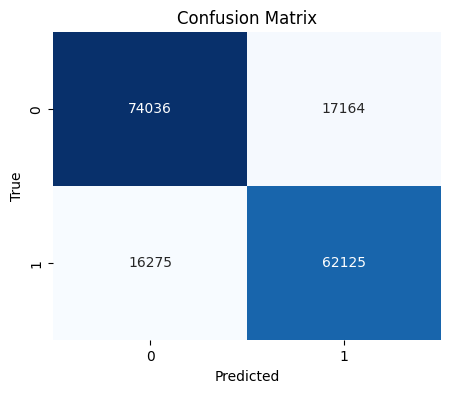

In [69]:
y_true = lr_roi_result_df['y_true']
y_pred = lr_roi_result_df['y_pred']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [70]:
result_mass.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'assessment', 'pathology',
       'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant'],
      dtype='object')

In [71]:
lr_roi_result_df = mass_roi.merge(lr_roi_result_df[['tumor_id', 'y_pred', 'y_prob', 'fold_number', 'file_number']], on='tumor_id', how='left')

In [72]:
lr_roi_result_df['malignant'] = lr_roi_result_df['pathology'].map({'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0})

In [74]:
lr_roi_result_df.columns

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'assessment', 'pathology',
       'subtlety', 'image file path', 'cropped image file path',
       'ROI mask file path', 'tumor_id', 'multiple_tumors',
       'ARCHITECTURAL_DISTORTION', 'ASYMMETRIC_BREAST_TISSUE',
       'FOCAL_ASYMMETRIC_DENSITY', 'IRREGULAR', 'LOBULATED', 'LYMPH_NODE',
       'OVAL', 'ROUND', 'CIRCUMSCRIBED', 'ILL_DEFINED', 'MICROLOBULATED',
       'OBSCURED', 'SPICULATED', 'malignant', 'Image Path', 'Tumor Area',
       'Tumor Perimeter', 'Tumor Eccentricity', 'Tumor Solidity',
       'Tumor Extent', 'y_pred', 'y_prob', 'fold_number', 'file_number'],
      dtype='object')

In [73]:
lr_roi_result_df

patient_id  breast_density left or right breast image view  \
0         P_00001               3                 LEFT         CC   
1         P_00001               3                 LEFT         CC   
2         P_00001               3                 LEFT         CC   
3         P_00001               3                 LEFT         CC   
4         P_00001               3                 LEFT         CC   
...           ...             ...                  ...        ...   
169595    P_01912               3                RIGHT        MLO   
169596    P_01912               3                RIGHT        MLO   
169597    P_01912               3                RIGHT        MLO   
169598    P_01912               3                RIGHT        MLO   
169599    P_01912               3                RIGHT        MLO   

       abnormality id abnormality type  assessment  pathology  subtlety  \
0                   1             mass           4  MALIGNANT         4   
1                   1             mass           4  MALIGNANT         4   
2                   1             mass           4  MALIGNANT         4   
3                   1             mass           4  MALIGNANT         4   
4                   1             mass           4  MALIGNANT         4   
...               ...              ...         ...        ...       ...   
169595              1             mass           5  MALIGNANT         4   
169596              1             mass           5  MALIGNANT         4   
169597              1             mass           5  MALIGNANT         4   
169598              1             mass           5  MALIGNANT         4   
169599              1             mass           5  MALIGNANT         4   

                                          image file path  ...  \
0       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...   
1       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...   
2       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...   
3       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...   
4       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...   
...                                                   ...  ...   
169595  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   
169596  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   
169597  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   
169598  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   
169599  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...  ...   

                                               Image Path Tumor Area  \
0       1.3.6.1.4.1.9590.100.1.2.296736403313792599626...   120546.0   
1       1.3.6.1.4.1.9590.100.1.2.296736403313792599626...   120546.0   
2       1.3.6.1.4.1.9590.100.1.2.296736403313792599626...   120546.0   
3       1.3.6.1.4.1.9590.100.1.2.296736403313792599626...   120546.0   
4       1.3.6.1.4.1.9590.100.1.2.296736403313792599626...   120546.0   
...                                                   ...        ...   
169595  1.3.6.1.4.1.9590.100.1.2.424889390711092892018...    70563.0   
169596  1.3.6.1.4.1.9590.100.1.2.424889390711092892018...    70563.0   
169597  1.3.6.1.4.1.9590.100.1.2.424889390711092892018...    70563.0   
169598  1.3.6.1.4.1.9590.100.1.2.424889390711092892018...    70563.0   
169599  1.3.6.1.4.1.9590.100.1.2.424889390711092892018...    70563.0   

        Tumor Perimeter  Tumor Eccentricity  Tumor Solidity  Tumor Extent  \
0           2912.880518            0.535633        0.827994      0.649056   
1           2912.880518            0.535633        0.827994      0.649056   
2           2912.880518            0.535633        0.827994      0.649056   
3           2912.880518            0.535633        0.827994      0.649056   
4           2912.880518            0.535633        0.827994      0.649056   
...                 ...                 ...             ...           ...   
169595      1687.486507            0.656511        0.816588      0.635634   
169

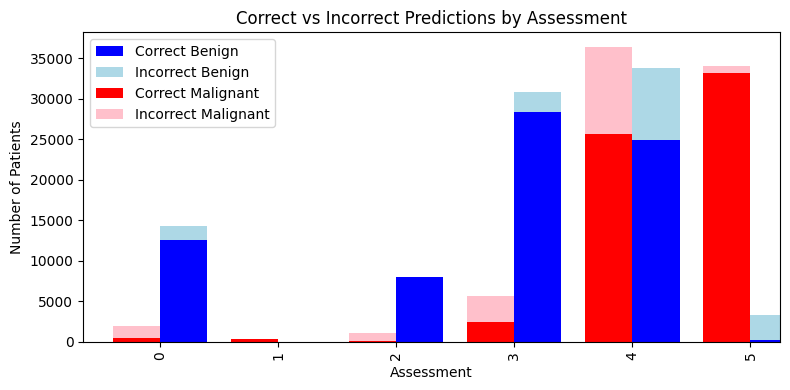

In [75]:
correct_benign = lr_roi_result_df[(lr_roi_result_df['y_pred'] == 0) & (lr_roi_result_df['pathology'] == 'BENIGN')]['assessment'].value_counts()
incorrect_benign = lr_roi_result_df[(lr_roi_result_df['y_pred'] == 0) & (lr_roi_result_df['pathology'] == 'MALIGNANT')]['assessment'].value_counts()

correct_malignant = lr_roi_result_df[(lr_roi_result_df['y_pred'] == 1) & (lr_roi_result_df['pathology'] == 'MALIGNANT')]['assessment'].value_counts()
incorrect_malignant = lr_roi_result_df[(lr_roi_result_df['y_pred'] == 1) & (lr_roi_result_df['pathology'] == 'BENIGN')]['assessment'].value_counts()

# Combine the counts into a DataFrame for plotting
prediction_counts = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)

fig, ax = plt.subplots(figsize=(8, 4))

prediction_counts[['Correct Benign', 'Incorrect Benign']].plot(kind='bar', ax=ax, color=['blue', 'lightblue'], stacked=True, position=0, width=0.4, align='center', label='Benign')
prediction_counts[['Correct Malignant', 'Incorrect Malignant']].plot(kind='bar', ax=ax, color=['red', 'pink'], stacked=True, position=1, width=0.4, align='center', label='Malignant')

ax.set_xlabel('Assessment')
ax.set_ylabel('Number of Patients')
ax.set_title('Correct vs Incorrect Predictions by Assessment')
ax.legend()

plt.tight_layout()
plt.show()


In [76]:
counts_df = pd.DataFrame({
    'Correct Benign': correct_benign,
    'Incorrect Benign': incorrect_benign,
    'Correct Malignant': correct_malignant,
    'Incorrect Malignant': incorrect_malignant
}).fillna(0)


counts_df['Benign Accuracy'] = counts_df['Correct Benign'] / (counts_df['Correct Benign'] + counts_df['Incorrect Benign'])
counts_df['Malignant Accuracy'] = counts_df['Correct Malignant'] / (counts_df['Correct Malignant'] + counts_df['Incorrect Malignant'])
counts_df.fillna(0, inplace=True)

counts_df


Correct Benign  Incorrect Benign  Correct Malignant  \
assessment                                                        
0                  12603.0            1697.0                503   
1                      0.0               6.0                294   
2                   8022.0               0.0                100   
3                  28316.0            2468.0               2432   
4                  24895.0            8931.0              25669   
5                    200.0            3173.0              33127   

            Incorrect Malignant  Benign Accuracy  Malignant Accuracy  
assessment                                                            
0                        1397.0         0.881329            0.264737  
1                           0.0         0.000000            1.000000  
2                         978.0         1.000000            0.092764  
3                        3184.0         0.919828            0.433048  
4                       10705.0         0.735972            0.705696  
5                         900.0         0.059294            0.973550

<ipython-input-86-6c777af4621e>:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


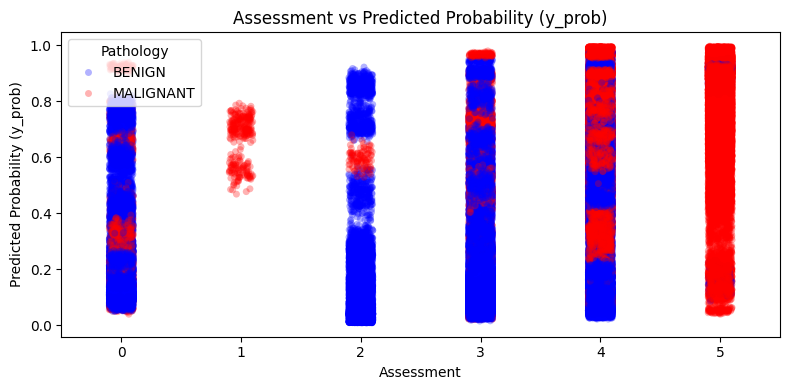

In [86]:
plt.figure(figsize=(8, 4))

sns.stripplot(data=lr_roi_result_df, x='assessment', y='y_prob', jitter=True, hue='pathology', palette={'MALIGNANT': 'red', 'BENIGN': 'blue'}, alpha=0.3)

plt.xlabel('Assessment')
plt.ylabel('Predicted Probability (y_prob)')
plt.title('Assessment vs Predicted Probability (y_prob)')
plt.legend(title='Pathology')

plt.tight_layout()
plt.show()

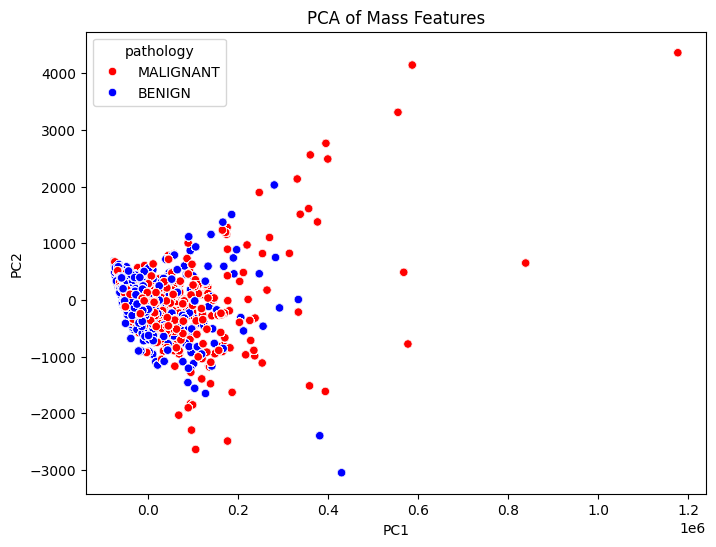

In [99]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the feature data in X (excluding 'y_prob' and categorical variables)
# Drop the specified columns from the DataFrame
X = lr_roi_result_df.drop(columns=['patient_id', 'image view', 'abnormality id', 'abnormality type', 'pathology',
                                    'subtlety', 'image file path', 'cropped image file path',
                                    'ROI mask file path', 'tumor_id', 'malignant', 'y_pred', 'y_prob',
                                    'fold_number', 'file_number','left or right breast','Image Path' ])

# Perform PCA, reducing to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with PCA components and the pathology
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['pathology'] = lr_roi_result_df['pathology']

# Plot the PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='pathology', data=pca_df, palette={'MALIGNANT': 'red', 'BENIGN': 'blue'})
plt.title('PCA of Mass Features')
plt.show()

In [100]:
component_loadings = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
component_loadings

breast_density  assessment  multiple_tumors  ARCHITECTURAL_DISTORTION  \
PC1    9.879968e-07    0.000003    -9.500624e-08              3.907999e-07   
PC2   -2.765933e-04   -0.000169     8.243618e-05             -1.340113e-04   

     ASYMMETRIC_BREAST_TISSUE  FOCAL_ASYMMETRIC_DENSITY     IRREGULAR  \
PC1              3.537691e-07              3.850426e-08  4.685551e-07   
PC2             -8.261736e-06             -1.304319e-05 -9.171948e-05   

        LOBULATED    LYMPH_NODE          OVAL  ...  CIRCUMSCRIBED  \
PC1 -1.035636e-07 -2.422758e-07 -5.744561e-07  ...  -8.702573e-07   
PC2  1.197109e-04  3.840877e-05  5.016650e-05  ...   1.941638e-04   

      ILL_DEFINED  MICROLOBULATED      OBSCURED    SPICULATED  Tumor Area  \
PC1  3.557775e-08    1.284539e-07 -1.476009e-07  7.659271e-07    0.999953   
PC2 -7.506521e-05    5.302804e-05 -1.023375e-06 -1.399795e-04    0.009669   

     Tumor Perimeter  Tumor Eccentricity  Tumor Solidity  Tumor Extent  
PC1         0.009669       -1.088073e-07    1.077088e-07  1.569816e-07  
PC2        -0.999953       -1.602613e-05    6.251089e-05  5.582646e-05  

[2 rows x 21 columns]

<Figure size 800x400 with 0 Axes>

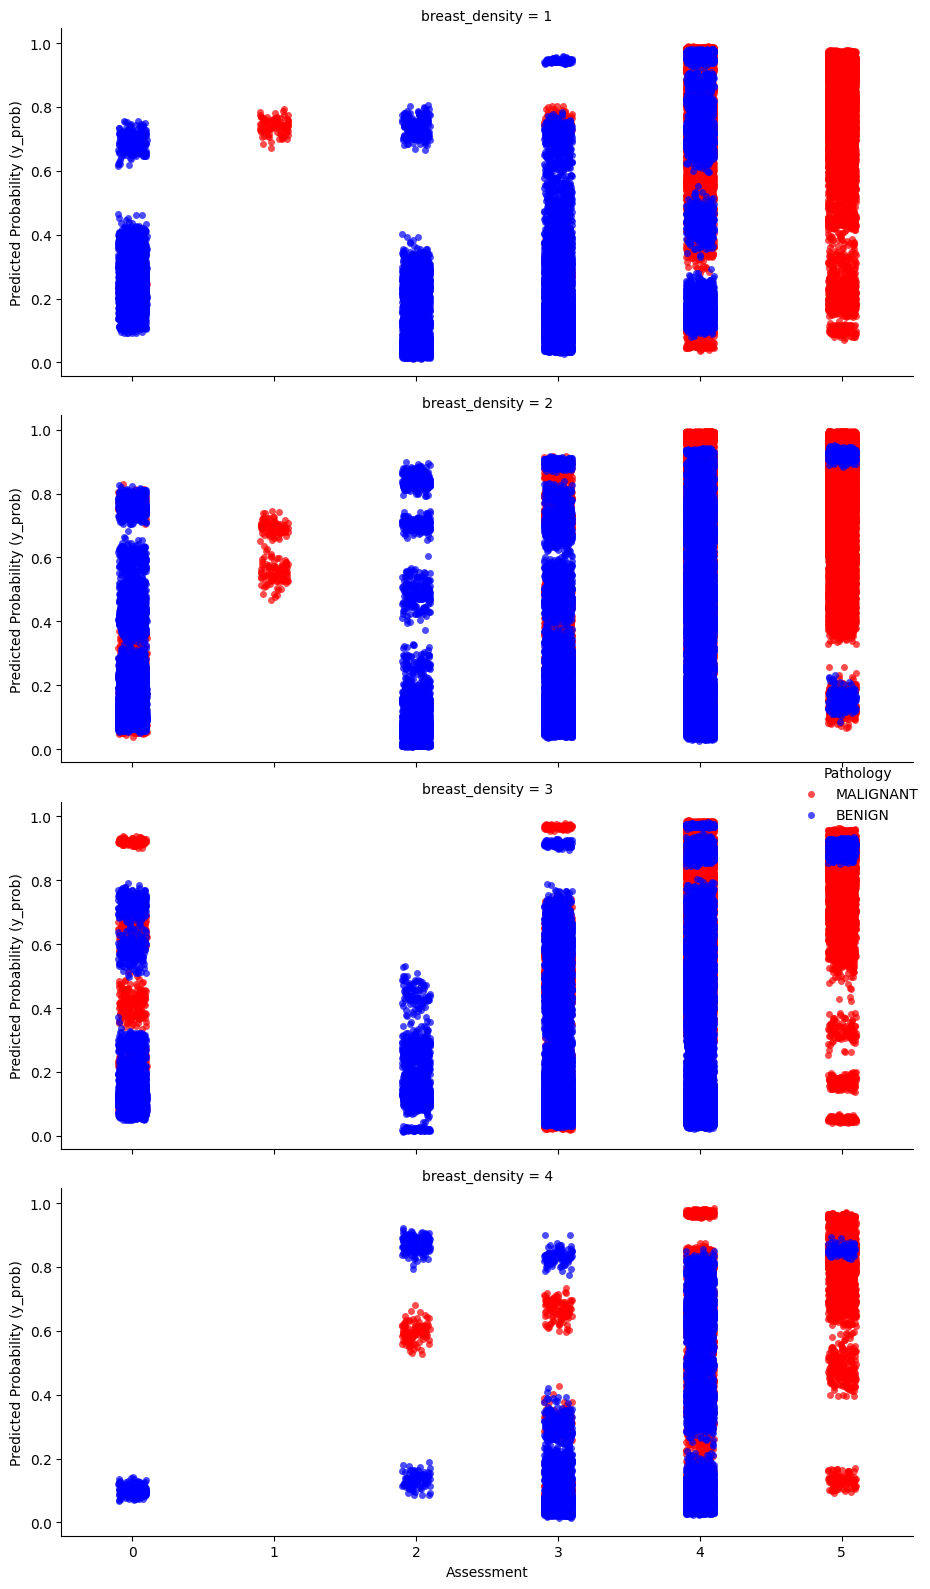

In [95]:
assessment_order = ['0','1', '2', '3', '4', '5']

plt.figure(figsize=(8, 4))
g = sns.FacetGrid(lr_roi_result_df, row='breast_density', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': 'red', 'BENIGN': 'blue'})
#g = sns.FacetGrid(lr_roi_result_df, row='breast_density', col='pathology', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': 'red', 'BENIGN': 'blue'})

# Map the stripplot onto the grid
g.map(sns.stripplot, 'assessment', 'y_prob', jitter=True, alpha=0.7, order=assessment_order)

# Add a legend and adjust layout
g.add_legend(title='Pathology')
g.set_axis_labels('Assessment', 'Predicted Probability (y_prob)')
plt.tight_layout()
plt.show()


<Figure size 800x400 with 0 Axes>

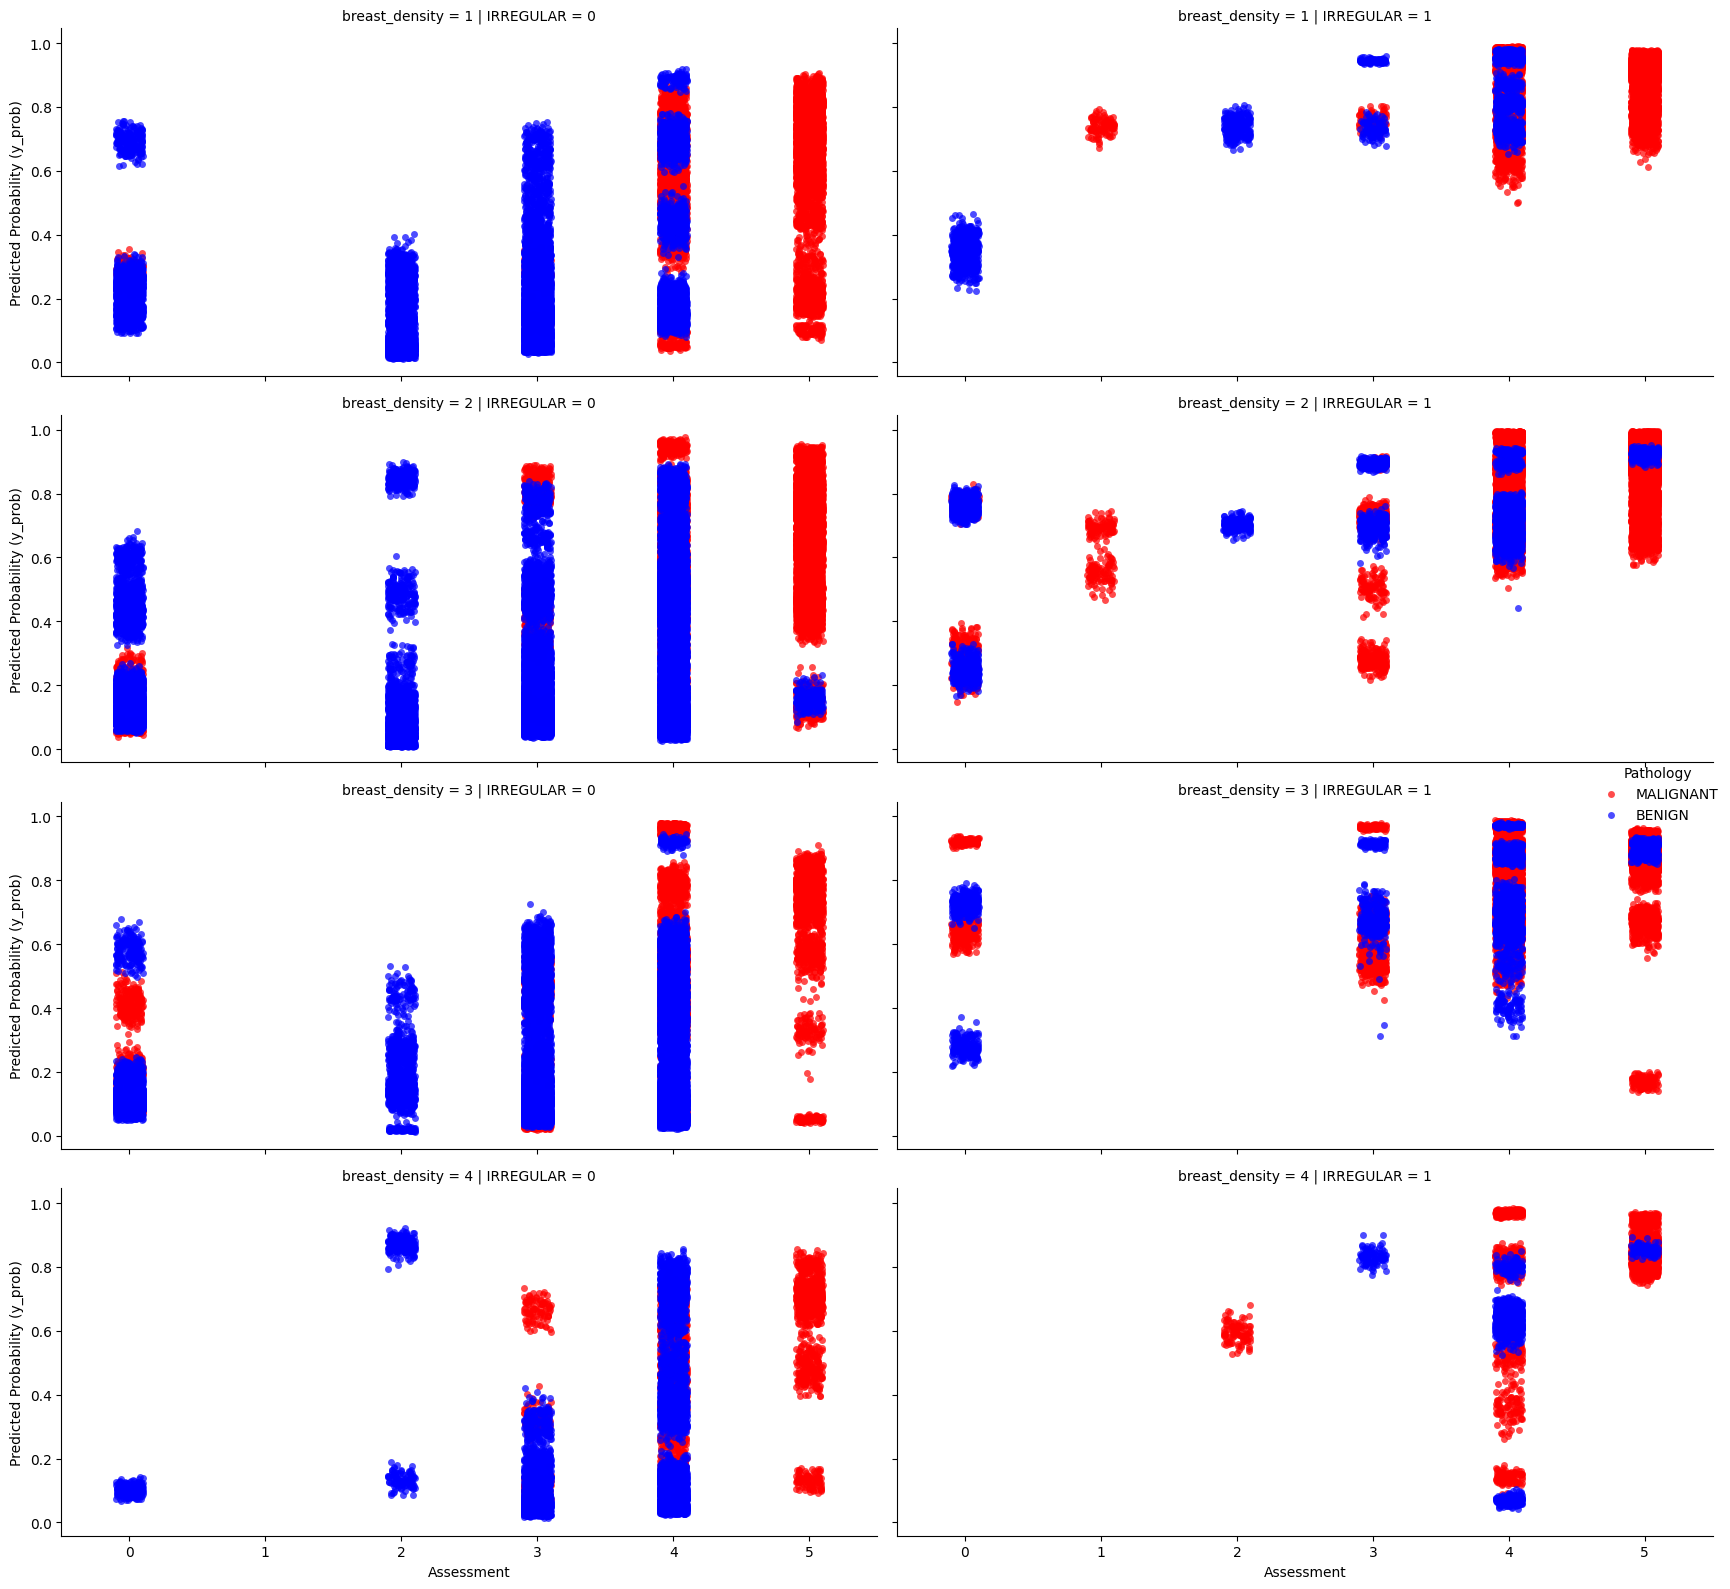

In [96]:
plt.figure(figsize=(8, 4))
g = sns.FacetGrid(lr_roi_result_df, row='breast_density', col='IRREGULAR', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': 'red', 'BENIGN': 'blue'})

g.map(sns.stripplot, 'assessment', 'y_prob', jitter=True, alpha=0.7, order=assessment_order)

g.add_legend(title='Pathology')
g.set_axis_labels('Assessment', 'Predicted Probability (y_prob)')
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

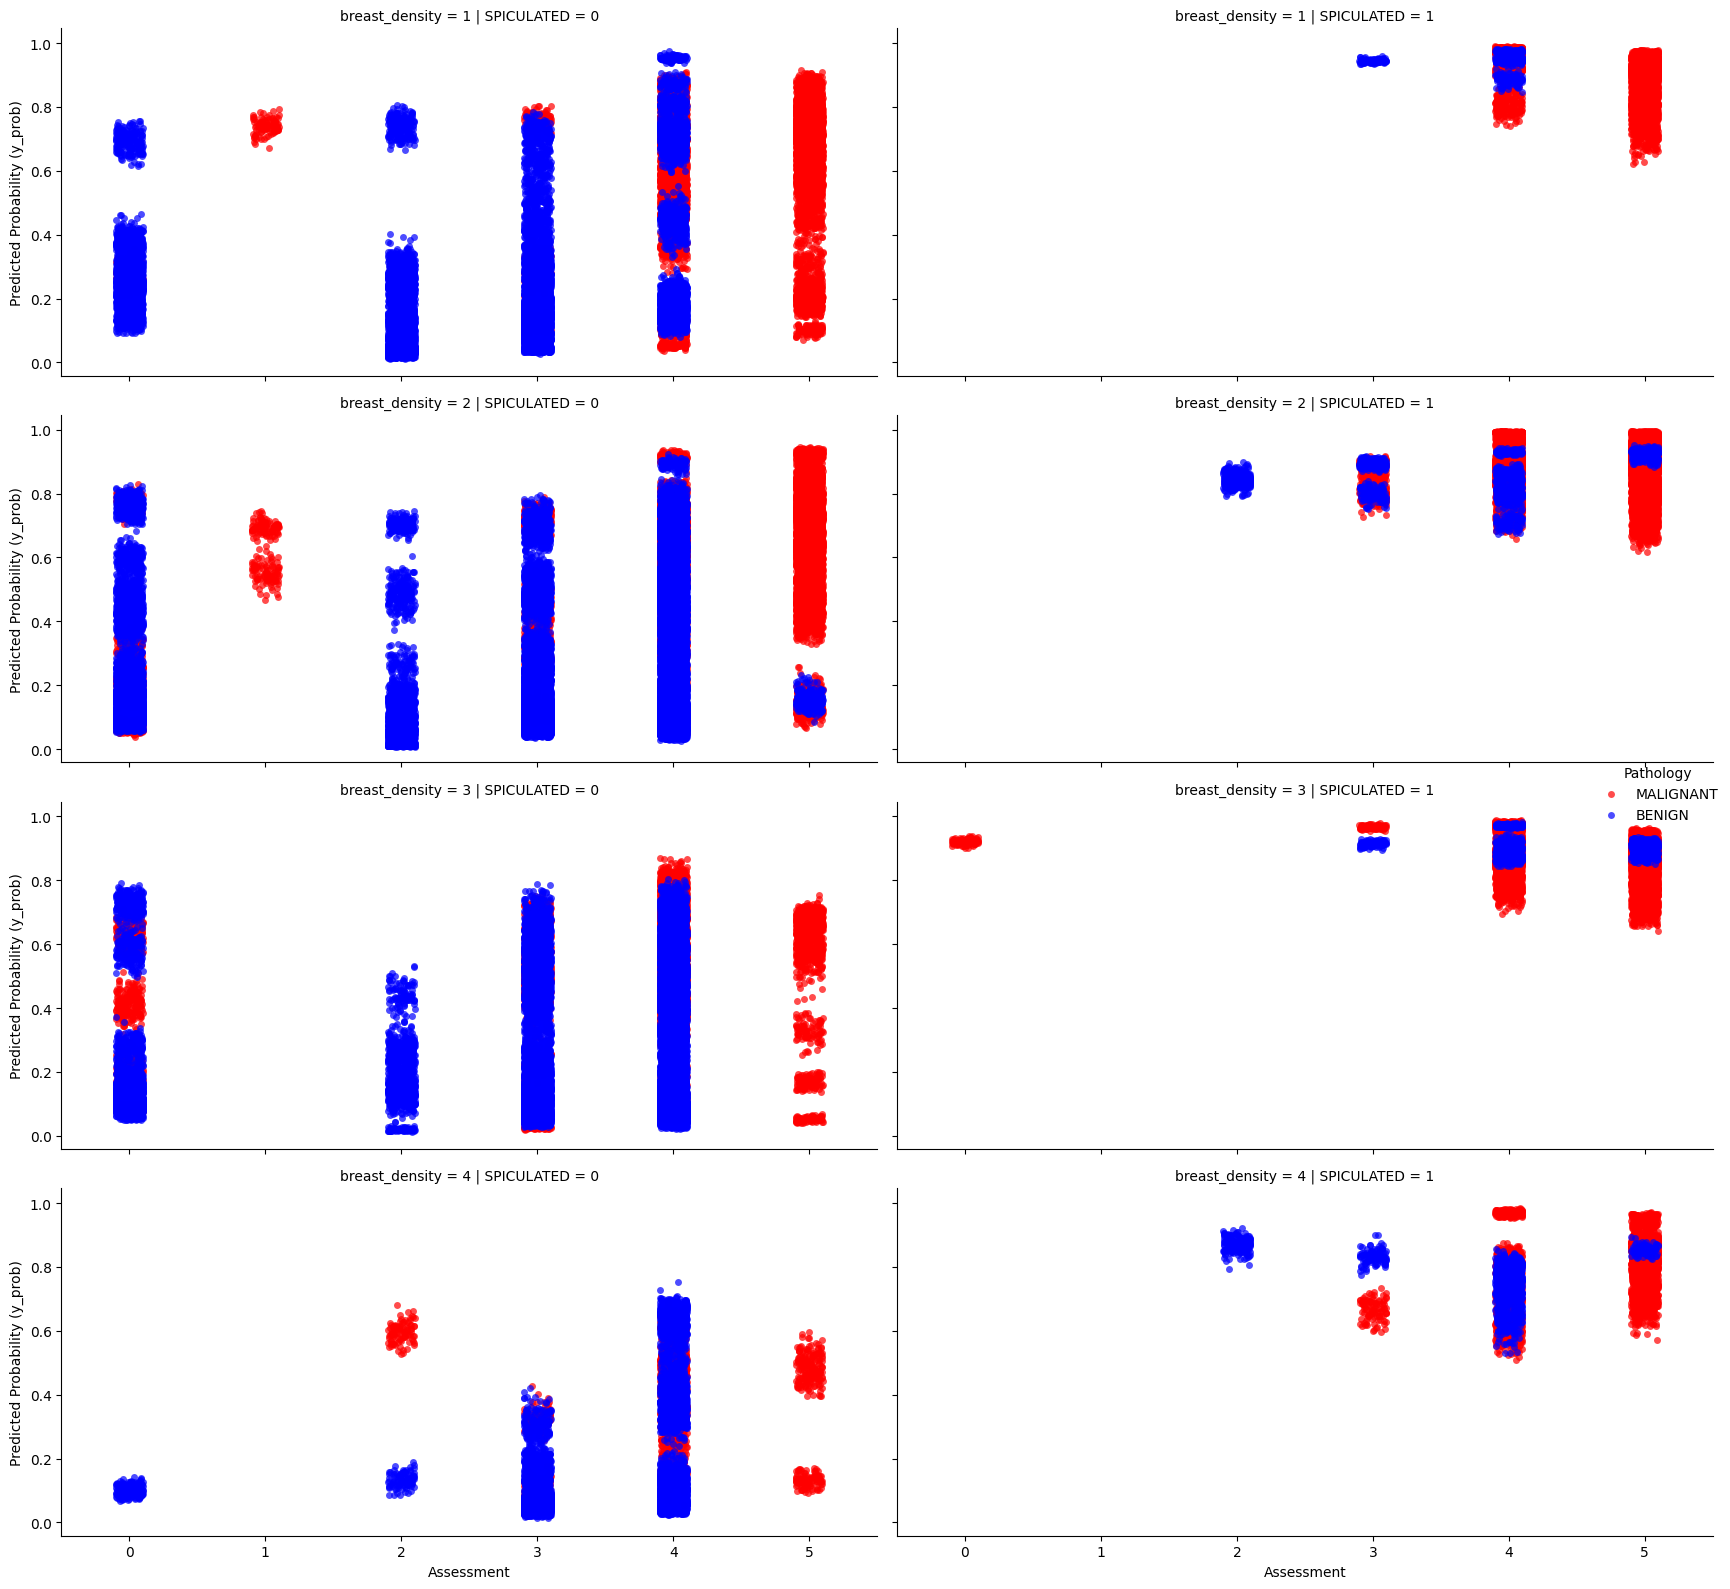

In [97]:
plt.figure(figsize=(8, 4))
g = sns.FacetGrid(lr_roi_result_df, row='breast_density', col='SPICULATED', height=4, aspect=2, hue='pathology', palette={'MALIGNANT': 'red', 'BENIGN': 'blue'})

# Map the stripplot onto the grid
g.map(sns.stripplot, 'assessment', 'y_prob', jitter=True, alpha=0.7, order=assessment_order)

# Add a legend and adjust layout
g.add_legend(title='Pathology')
g.set_axis_labels('Assessment', 'Predicted Probability (y_prob)')
plt.tight_layout()
plt.show()

# Extracting all features from images

In [29]:
tumor_features_df = pd.read_csv('/content/drive/MyDrive/DDSM data/tumor_all_features.csv', sep=',')
tumor_features_df

Image Path  Tumor Area  \
0      /kaggle/input/cbis-ddsm-breast-cancer-image-da...     73049.0   
1      /kaggle/input/cbis-ddsm-breast-cancer-image-da...    101746.0   
2      /kaggle/input/cbis-ddsm-breast-cancer-image-da...    589897.0   
3      /kaggle/input/cbis-ddsm-breast-cancer-image-da...     68385.0   
4      /kaggle/input/cbis-ddsm-breast-cancer-image-da...         2.0   
...                                                  ...         ...   
10117  /kaggle/input/cbis-ddsm-breast-cancer-image-da...         2.0   
10118  /kaggle/input/cbis-ddsm-breast-cancer-image-da...         1.0   
10119  /kaggle/input/cbis-ddsm-breast-cancer-image-da...    292333.0   
10120  /kaggle/input/cbis-ddsm-breast-cancer-image-da...    333417.0   
10121  /kaggle/input/cbis-ddsm-breast-cancer-image-da...         4.0   

       Tumor Perimeter  Tumor Eccentricity  Tumor Solidity  Tumor Extent  \
0          1283.009235            0.872245        0.937283      0.560807   
1          1789.962554            0.934355        0.770826      0.449973   
2          3774.552524            0.797159        0.915476      0.651739   
3          1511.267207            0.527071        0.876731      0.694440   
4             0.000000            1.000000        1.000000      1.000000   
...                ...                 ...             ...           ...   
10117         0.000000            1.000000        1.000000      1.000000   
10118         0.000000            0.000000        1.000000      1.000000   
10119      3959.809809            0.990917        0.767528      0.187401   
10120      3394.667494            0.559785        0.907205      0.705089   
10121         4.414214            0.924176        1.000000      0.666667   

       Major Axis Length  Minor Axis Length  Aspect Ratio  Circularity  \
0             447.173452         218.698499      2.044703     0.557654   
1             665.358041         237.096353      2.806277     0.399061   
2            1182.488723         713.950144      1.656262     0.520302   
3             325.659767         276.752523      1.176718     0.376260   
4               2.000000           0.000000           NaN          NaN   
...                  ...                ...           ...          ...   
10117           2.000000           0.000000           NaN          NaN   
10118           0.000000           0.000000           NaN          NaN   
10119        1851.883269         249.027050      7.436474     0.234282   
10120         724.304591         600.186070      1.206800     0.363583   
10121           3.236068           1.236068      2.618034     2.579664   

       Compactness  Convex Hull Area  Jaggedness  
0         1.793228           77376.0    1.163171  
1         2.505882          131312.5    1.194771  
2         1.921962          642880.0    1.209159  
3         2.657736           77519.5    1.493261  
4         0.000000               0.0    0.000000  
...            ...               ...         ...  
10117     0.000000               0.0    0.000000  
10118     0.000000               0.0         NaN  
10119     4.268359          379375.5    1.083102  
10120     2.750406          366520.5    1.561733  
10121     0.387647               1.0    0.914214  

[10122 rows x 13 columns]

In [30]:
tumor_features_df = tumor_features_df[tumor_features_df["Tumor Area"] > 70]

tumor_features_df['Image Path'] = tumor_features_df['Image Path'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
tumor_features_df['Image Path'] = tumor_features_df['Image Path'].str[:-10]
tumor_features_df

<ipython-input-30-1354ae176fa8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_features_df['Image Path'] = tumor_features_df['Image Path'].str.replace('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/', '', regex=False)
<ipython-input-30-1354ae176fa8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_features_df['Image Path'] = tumor_features_df['Image Path'].str[:-10]


Image Path  Tumor Area  \
0      1.3.6.1.4.1.9590.100.1.2.153339052913121382622...     73049.0   
1      1.3.6.1.4.1.9590.100.1.2.178994714611485132105...    101746.0   
2      1.3.6.1.4.1.9590.100.1.2.411833492612373627114...    589897.0   
3      1.3.6.1.4.1.9590.100.1.2.236373548712994183418...     68385.0   
5      1.3.6.1.4.1.9590.100.1.2.357008050412534761329...     90200.0   
...                                                  ...         ...   
10101  1.3.6.1.4.1.9590.100.1.2.374221285124370132151...     94457.0   
10102  1.3.6.1.4.1.9590.100.1.2.195242971118587811360...    159406.0   
10108  1.3.6.1.4.1.9590.100.1.2.263713351013050806016...     81122.0   
10119  1.3.6.1.4.1.9590.100.1.2.627982547125586065005...    292333.0   
10120  1.3.6.1.4.1.9590.100.1.2.285138900913160236325...    333417.0   

       Tumor Perimeter  Tumor Eccentricity  Tumor Solidity  Tumor Extent  \
0          1283.009235            0.872245        0.937283      0.560807   
1          1789.962554            0.934355        0.770826      0.449973   
2          3774.552524            0.797159        0.915476      0.651739   
3          1511.267207            0.527071        0.876731      0.694440   
5          1913.834703            0.789293        0.877466      0.688129   
...                ...                 ...             ...           ...   
10101      1310.943218            0.593089        0.969257      0.745723   
10102      2546.793252            0.565393        0.878585      0.665306   
10108      1903.221572            0.498715        0.840111      0.658821   
10119      3959.809809            0.990917        0.767528      0.187401   
10120      3394.667494            0.559785        0.907205      0.705089   

       Major Axis Length  Minor Axis Length  Aspect Ratio  Circularity  \
0             447.173452         218.698499      2.044703     0.557654   
1             665.358041         237.096353      2.806277     0.399061   
2            1182.488723         713.950144      1.656262     0.520302   
3             325.659767         276.752523      1.176718     0.376260   
5             438.207834         269.067080      1.628619     0.309462   
...                  ...                ...           ...          ...   
10101         386.907137         311.513354      1.242024     0.690679   
10102         505.790492         417.186898      1.212383     0.308835   
10108         360.710280         312.651486      1.153714     0.281430   
10119        1851.883269         249.027050      7.436474     0.234282   
10120         724.304591         600.186070      1.206800     0.363583   

       Compactness  Convex Hull Area  Jaggedness  
0         1.793228           77376.0    1.163171  
1         2.505882          131312.5    1.194771  
2         1.921962          642880.0    1.209159  
3         2.657736           77519.5    1.493261  
5         3.231413          102234.5    1.614166  
...            ...               ...         ...  
10101     1.447851           96864.0    1.172427  
10102     3.237970          180701.0    1.646926  
10108     3.553286           96028.0    1.673026  
10119     4.268359          379375.5    1.083102  
10120     2.750406          366520.5    1.561733  

[3247 rows x 13 columns]

In [31]:
tumor_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3247 entries, 0 to 10120
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image Path          3247 non-null   object 
 1   Tumor Area          3247 non-null   float64
 2   Tumor Perimeter     3247 non-null   float64
 3   Tumor Eccentricity  3247 non-null   float64
 4   Tumor Solidity      3247 non-null   float64
 5   Tumor Extent        3247 non-null   float64
 6   Major Axis Length   3247 non-null   float64
 7   Minor Axis Length   3247 non-null   float64
 8   Aspect Ratio        3247 non-null   float64
 9   Circularity         3247 non-null   float64
 10  Compactness         3247 non-null   float64
 11  Convex Hull Area    3247 non-null   float64
 12  Jaggedness          3247 non-null   float64
dtypes: float64(12), object(1)
memory usage: 355.1+ KB


In [32]:
def remove_up_to_second_slash(path):
    parts = path.split('/')
    return '/'.join(parts[2:])

In [33]:
mass_roi = result_mass
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].str[:-12]
mass_roi['ROI mask file path'] = mass_roi['ROI mask file path'].apply(remove_up_to_second_slash)
mass_roi['ROI mask file path']

0       1.3.6.1.4.1.9590.100.1.2.296736403313792599626...
1       1.3.6.1.4.1.9590.100.1.2.227955274711225756835...
2       1.3.6.1.4.1.9590.100.1.2.429120414011832984817...
3       1.3.6.1.4.1.9590.100.1.2.115134232113001553100...
4       1.3.6.1.4.1.9590.100.1.2.128573663126257012032...
                              ...                        
1691    1.3.6.1.4.1.9590.100.1.2.408076999112697002131...
1692    1.3.6.1.4.1.9590.100.1.2.183250739910949037237...
1693    1.3.6.1.4.1.9590.100.1.2.358302752911597447901...
1694    1.3.6.1.4.1.9590.100.1.2.299479312912648479419...
1695    1.3.6.1.4.1.9590.100.1.2.424889390711092892018...
Name: ROI mask file path, Length: 1696, dtype: object

In [34]:
tumor_features_df = mass_roi.merge(tumor_features_df, left_on='ROI mask file path', right_on='Image Path', how='left')
tumor_features_df = tumor_features_df[['patient_id', 'tumor_id', 'malignant','abnormality id', 'Tumor Eccentricity',	'Tumor Solidity',	'Tumor Extent',	'Major Axis Length',	'Minor Axis Length',	'Aspect Ratio',	'Circularity',	'Compactness',	'Convex Hull Area',	'Jaggedness']]
tumor_features_df

patient_id  tumor_id  malignant abnormality id  Tumor Eccentricity  \
0       P_00001         1          1              1            0.535633   
1       P_00001         2          1              1            0.316732   
2       P_00004         3          0              1            0.376866   
3       P_00004         4          0              1            0.384144   
4       P_00004         5          0              1            0.601576   
...         ...       ...        ...            ...                 ...   
1691    P_01825      1692          0              1            0.686809   
1692    P_01833      1693          1              1            0.449408   
1693    P_01865      1694          1              1            0.894507   
1694    P_01912      1695          1              1            0.528255   
1695    P_01912      1696          1              1            0.656511   

      Tumor Solidity  Tumor Extent  Major Axis Length  Minor Axis Length  \
0           0.827994      0.649056         438.509594         370.299735   
1           0.819758      0.591490         215.367568         204.279359   
2           0.853503      0.694309         403.421149         373.676030   
3           0.799239      0.605179         361.855144         334.091159   
4           0.837156      0.601337         390.051983         311.579584   
...              ...           ...                ...                ...   
1691        0.804664      0.598855         226.180892         164.396784   
1692        0.938265      0.726522         495.737735         442.855797   
1693        0.705994      0.564286         318.021972         142.172777   
1694        0.861811      0.647976         388.410288         329.793710   
1695        0.816588      0.635634         356.396736         268.835789   

      Aspect Ratio  Circularity  Compactness  Convex Hull Area  Jaggedness  
0         1.184202     0.178533     5.601221          144944.5    2.099815  
1         1.054280     0.291972     3.424987           38948.5    1.631383  
2         1.079601     0.208287     4.801058          132114.5    1.982364  
3         1.083103     0.142242     7.030258          111371.0    2.320501  
4         1.251853     0.224463     4.455083          109045.5    1.870133  
...            ...          ...          ...               ...         ...  
1691      1.375823     0.212291     4.710510           33468.5    1.865152  
1692      1.119411     0.453605     2.204562          179004.0    1.404976  
1693      2.236870     0.188480     5.305595           40567.0    1.731391  
1694      1.177737     0.212308     4.710140          112374.0    1.950939  
1695      1.325704     0.311391     3.211395           85909.0    1.570353  

[1696 rows x 14 columns]

Comparing the models using the images features only, without any information from the original table

In [35]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Ridge Classifier": RidgeClassifier(),
    "Ada Boost Classifier": AdaBoostClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    # "SVM - Linear": SVC(kernel='linear', probability=True),
    "Naive Bayes": GaussianNB()
}

num_runs = 100
n_splits = 10

for run in range(num_runs):
    # Shuffle and reset the index of the original DataFrame
    tumor_features_df_shuffled = tumor_features_df.sample(frac=1, random_state=42*run).reset_index(drop=True)

    # Features and target
    X = tumor_features_df_shuffled.drop(['malignant', 'patient_id', 'tumor_id', 'abnormality id'], axis=1)
    y = tumor_features_df_shuffled['malignant']
    groups = tumor_features_df_shuffled['patient_id']
    abnormality_ids = tumor_features_df_shuffled['abnormality id']
    tumor_id = tumor_features_df_shuffled['tumor_id']

    # Replace whitespaces in feature names with underscores
    X.columns = [col.replace(" ", "_") for col in X.columns]

    all_predictions = []

    # Get unique patient IDs
    unique_patient_ids = groups.unique()
    np.random.seed(42*run)  # Set seed for reproducibility

    # Shuffle the patient IDs
    np.random.shuffle(unique_patient_ids)

    # Split the patient IDs into folds
    fold_size = len(unique_patient_ids) // n_splits
    predefined_splits = []

    for fold in range(n_splits):
        test_ids = unique_patient_ids[fold * fold_size: (fold + 1) * fold_size]
        train_ids = np.setdiff1d(unique_patient_ids, test_ids)
        predefined_splits.append((train_ids, test_ids))

    # Handle any patient IDs not included in the folds
    all_test_ids = np.concatenate([test_ids for _, test_ids in predefined_splits])
    missing_ids = np.setdiff1d(unique_patient_ids, all_test_ids)
    print(missing_ids)
    if len(missing_ids) > 0:
        for missing_id in missing_ids:
            random_fold = np.random.choice(n_splits)
            train_ids, test_ids = predefined_splits[random_fold]
            test_ids = np.append(test_ids, missing_id)
            predefined_splits[random_fold] = (train_ids, test_ids)

    group_kfold = GroupKFold(n_splits=n_splits)

    for model_name, model in models.items():
        original_model = copy.deepcopy(model) # run folds on og
        fold_count = 1
        all_model_predictions = []

        for fold_idx, (train_ids, test_ids) in enumerate(predefined_splits):
            model = copy.deepcopy(original_model)
            train_idx = groups.isin(train_ids)
            test_idx = groups.isin(test_ids)

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            patient_ids = groups[test_idx]
            abnormality_test_ids = abnormality_ids[test_idx]
            tumor_id_test = tumor_id[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                for pid, ab_id, y_t, y_p, y_pr, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, y_prob, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, y_pr, fold_count, t_id))
            else:
                for pid, ab_id, y_t, y_p, t_id in zip(patient_ids, abnormality_test_ids, y_test, y_pred, tumor_id_test):
                    all_model_predictions.append((pid, ab_id, y_t, y_p, None, fold_count, t_id))

            fold_count += 1

        predictions_df = pd.DataFrame(all_model_predictions, columns=['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id'])

        # Include only the specified columns
        predictions_df = predictions_df[['patient_id', 'abnormality id', 'y_true', 'y_pred', 'y_prob', 'fold_number', 'tumor_id']]

        predictions_df.to_csv(f'/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Compare_models_image_features_only/Results_{model_name}_{run + 1}.csv', index=False)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Info] Start training from score -0.154758
[LightGBM] [Info] Number of positive: 694, number of negative: 839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1533, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452707 -> initscore=-0.189739
[LightGBM] [Info] Start training from score -0.189739
[LightGBM] [Info] Number of positive: 699, number of negative: 833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1532, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.4

In [37]:
# Define the path to your CSV files
base_path = '/content/drive/My Drive/DDSM data/DDSM_compareModels_Mass/Compare_models_image_features_only/'

# Define the models
models = [
    "Logistic Regression", "Linear Discriminant Analysis", "Ridge Classifier",
    "Ada Boost Classifier", "Extra Trees Classifier", "LightGBM",
    "XGBoost", "Random Forest", "K Neighbors Classifier",
    "Decision Tree", "Naive Bayes"
]

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob=None):
    metrics = {}
    if len(y_true) > 0:  # Check if y_true has at least one sample
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['recall'] = recall_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred)
        metrics['f1_score'] = f1_score(y_true, y_pred)
    else:
        metrics['accuracy'] = None
        metrics['recall'] = None
        metrics['precision'] = None
        metrics['f1_score'] = None

    if y_prob is not None:
        valid_indices = ~np.isnan(y_prob)  # Find indices where y_prob is not NaN
        if len(y_true[valid_indices]) > 0:  # Check if y_true has at least one non-NaN sample
            metrics['auc'] = roc_auc_score(y_true[valid_indices], y_prob[valid_indices])
        else:
            metrics['auc'] = None
    else:
        metrics['auc'] = None

    return metrics


# Initialize a dictionary to store the results
results = {model: [] for model in models}

# Read and process each CSV file
for model_name in models:
    for run in range(1, 101):
        file_path = os.path.join(base_path, f'Results_{model_name}_{run}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            y_true = df['y_true']
            y_pred = df['y_pred']
            y_prob = df['y_prob'] if 'y_prob' in df.columns else None
            metrics = calculate_metrics(y_true, y_pred, y_prob)
            results[model_name].append(metrics)

# Calculate the average metrics for each model
average_results = {}
for model_name, metrics_list in results.items():
    valid_auc_values = [d['auc'] for d in metrics_list if d['auc'] is not None]
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(valid_auc_values) / len(valid_auc_values) if len(valid_auc_values) > 0 else None
    }
    average_results[model_name] = avg_metrics

In [38]:
# Create empty DataFrame
results_df = pd.DataFrame(columns=['Model', 'Metric', 'Value'])

# Calculate average and std for each metric
rows_to_concat = []

for model_name, metrics_list in results.items():
    avg_metrics = {
        'accuracy': sum(d['accuracy'] for d in metrics_list) / len(metrics_list),
        'precision': sum(d['precision'] for d in metrics_list) / len(metrics_list),
        'recall': sum(d['recall'] for d in metrics_list) / len(metrics_list),
        'f1_score': sum(d['f1_score'] for d in metrics_list) / len(metrics_list),
        'auc': sum(d['auc'] for d in metrics_list if d['auc'] is not None) / len([d for d in metrics_list if d['auc'] is not None]) if len([d for d in metrics_list if d['auc'] is not None]) > 0 else None
    }

    # Calculate standard deviation
    std_metrics = {
        'accuracy': np.std([d['accuracy'] for d in metrics_list]),
        'precision': np.std([d['precision'] for d in metrics_list]),
        'recall': np.std([d['recall'] for d in metrics_list]),
        'f1_score': np.std([d['f1_score'] for d in metrics_list]),
        'auc': np.std([d['auc'] for d in metrics_list if d['auc'] is not None])
    }

    # Add average metrics to DataFrame
    for metric, value in avg_metrics.items():
        if value is not None:
            rows_to_concat.append({'Model': model_name, 'Metric': metric, 'Value': value})

    # Add std metrics to DataFrame
    for metric, value in std_metrics.items():
        rows_to_concat.append({'Model': model_name, 'Metric': metric + '_std', 'Value': value})

# Concatenate the rows
results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)

# Pivot the DataFrame for better readability
results_df = results_df.pivot(index='Model', columns='Metric', values='Value')

# Display the results DataFrame
results_df

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-38-bc0cd809715d>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(rows_to_concat)], ignore_index=True)


Metric                        accuracy  accuracy_std       auc   auc_std  \
Model                                                                      
Ada Boost Classifier          0.570195      0.007118  0.591212  0.007025   
Decision Tree                 0.526468      0.010748  0.523802  0.010830   
Extra Trees Classifier        0.567630      0.007769  0.584795  0.006468   
K Neighbors Classifier        0.556651      0.005443  0.552780  0.005193   
LightGBM                      0.549522      0.008175  0.564159  0.007017   
Linear Discriminant Analysis  0.591397      0.003417  0.620453  0.002958   
Logistic Regression           0.591816      0.003504  0.603494  0.007599   
Naive Bayes                   0.592942      0.001441  0.583556  0.006659   
Random Forest                 0.567583      0.006374  0.582924  0.006880   
Ridge Classifier              0.584481      0.003278       NaN       NaN   
XGBoost                       0.547099      0.008505  0.561120  0.007788   

Metric                        f1_score  f1_score_std  precision  \
Model                                                             
Ada Boost Classifier          0.488453      0.010447   0.542930   
Decision Tree                 0.488081      0.012992   0.487827   
Extra Trees Classifier        0.502120      0.009632   0.536823   
K Neighbors Classifier        0.504584      0.006161   0.521893   
LightGBM                      0.493883      0.010196   0.513782   
Linear Discriminant Analysis  0.479756      0.004770   0.583042   
Logistic Regression           0.370873      0.007104   0.645012   
Naive Bayes                   0.365785      0.002909   0.653722   
Random Forest                 0.498716      0.008274   0.537294   
Ridge Classifier              0.457956      0.004864   0.576809   
XGBoost                       0.493317      0.011128   0.510824   

Metric                        precision_std    recall  recall_std  
Model                                                              
Ada Boost Classifier               0.009376  0.444018    0.012731  
Decision Tree                      0.011664  0.488469    0.016395  
Extra Trees Classifier             0.009611  0.471709    0.011345  
K Neighbors Classifier             0.006404  0.488444    0.007979  
LightGBM                           0.009612  0.475548    0.012297  
Linear Discriminant Analysis       0.005429  0.407577    0.005097  
Logistic Regression                0.009919  0.260306    0.006392  
Naive Bayes                        0.003923  0.253941    0.002434  
Random Forest                      0.008016  0.465383    0.010242  
Ridge Classifier                   0.005458  0.379732    0.004997  
XGBoost                            0.009784  0.477054    0.013610